# import libraries

In [2]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator
import seaborn as sns
sns.set()

import time
import os.path

from statsmodels.tsa.stattools import adfuller
from datetime import datetime, date, timedelta, timezone
import yfinance as yf
from scipy import integrate
import random

import pandas_ta as ta

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from xgboost import XGBClassifier

# from tqdm import tnrange, notebook
from tqdm.notebook import tqdm
from dateutil import parser

import edge
import edge.edge_mean_reversion as a
import edge.edge_risk_kit as erk
import TMRW


from hmmlearn.hmm import GaussianHMM
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


#import talib.abstract as ta
#import freqtrade.vendor.qtpylib.indicators as qtpylib


# dates in correct format for yahoo finance.
today = date.today() 
today = datetime(today.year,today.month,today.day) #today
m1 = datetime(today.year,today.month-1,today.day)
m3 = datetime(today.year,today.month-3,today.day)
m6 = datetime(today.year,today.month-5,today.day)
one = datetime(today.year-1,today.month,today.day) #one year ago
three = datetime(today.year-3,today.month,today.day) #three years ago
five = datetime(today.year-5,today.month,today.day) #five years ago
ten = datetime(today.year-10,today.month,today.day) #ten years ago
twenty = datetime(today.year-20,today.month,today.day) #twenty years ago

PERIOD_PER_YEAR = 252 * 1
PERIOD_PER_DAY = 1

CUR = pd.read_excel(open('E:/Investering/Currencies.xlsx', 'rb'),sheet_name='Currencies')
#CUR = CUR[CUR['Type'] == "CRYPTOCURRENCY"]
CUR = list(CUR[CUR['BSYMBOL'].notnull()]['SYMBOL'])
lste = CUR

## trend tests

In [3]:
import math
import numpy as np
import pandas
from scipy.stats import norm, mstats


def mk_test(ts, mode = 'simple', window = 50, alpha = 0.00001):
    """
    Mann-Kendall test for trend
    Detects linear trends (in pair with cox_stuart)
    Optimal window = 50

    Input:
        x:   a vector of data
        alpha: significance level (0.001 default)
        window: last n values, for finding trend
        mode: 
            - 'full' - if you need to know trend direction; 
            - 'simple' - if just trend existance.

    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics 

    """
    x = ts[-window:]
    n = len(x)

    # calculate S 
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])
    #s = [-1 if x[j] < x[k] else 1 for j in xrange(k+1,n) for k in xrange(n-1)]

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)
    # calculate the var(s)
    n = float(n)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
        #print (var_s)
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test

    h = abs(z) > norm.ppf(1-alpha/2) 

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
    if mode == 'full':
        return trend, h, p, z
    else:
        return h, abs(z)


def cox_stuart(timeseries, window = 50, alpha = 0.0001, debug = False):
    """
    Cox-Stuart criterion
    H0: trend exists
    H1: otherwise

    Detects linear trends
    Optimal window = 50
    """
    n = window
    idx = np.arange(1,n+1)
    X = pandas.Series(timeseries[-n:], index=idx)
    
    S1 = [(n-2*i) if X[i] <= X[n-i+1] else 0 for i in range(1,n//2)]
    n = float(n)
    S1_ = (sum(S1) - n**2 / 8) / math.sqrt(n*(n**2-1)/24)
    u = norm.ppf(1-alpha/2)
    if debug:
        print ('|S1*|:', abs(S1_))
        print ("u:",u)
    
    return abs(S1_) > u, abs(S1_) #H0 accept

def abbe_criterion(timeseries, window = 40, alpha = .00001, debug = False):

    """
    Abbe-Linnik criterion
    Detects exponential trend (in pair with autocorrelation)
    If window >50 => too much True
    """
    if len(timeseries) < window:
        return False
    series = pandas.Series(timeseries)
    a = series[-window:]
    mean = a.mean()
    

    X = zip(a[:-1],a[1:])
    s1 = sum([math.pow((x[0]-x[1]),2) for x in X])
    s2 = sum([pow((x-mean),2) for x in a])
    q = 0.5 * s1 / s2
    q_a = 0.6814
    n = len(a)
    Q = -(1-q)*math.sqrt((2*n+1)/(2-pow((1-q),2)))
    u = norm.ppf(alpha) #kobzar page 26
    if debug:
        print ('mean:', mean)
        print ('q:', q)
        print ('Q*:', Q)
        print ('U_alpha-1:', u)
    return Q < u, abs(Q)


def autocorrelation(timeseries, window = 50, alpha = .00001, debug = False):
    """
    Detects exponential trend

    """
    n = window
    idx = np.arange(1,n+1)
    series = pandas.Series(list(timeseries[-n:]), index=idx)

    X = zip(series[:-1],series[1:])
    sqr_sum = pow(sum(series),2)
    n_f = float(n)
    r = (n_f * sum([x[0]*x[1] for x in X]) - sqr_sum + n_f*series[1]*series[n]) / \
        (n_f * sum([x**2 for x in series]) - sqr_sum)
    
    r_ = abs(r + 1./(n_f-1.)) / math.sqrt(n_f*(n_f-3)/(n_f+1)/pow((n_f-1),2))
    u = norm.ppf(1-alpha/2)
    
    return abs(r_) > u, abs(r_)

## mean reversion tests

In [4]:
# for hver invertering af MA5 og MA21. Hvor lang tid går der så indtil vi rammer samme pris som inverteringsprisen?
def mr_times(data):

    lstma5_times = []

    for i in range(1, len(data)):

        if (data.iloc[i,17] > data.iloc[i,3] and data.iloc[i-1,17] <= data.iloc[i-1,3]):
            lstma5_times.append(i)
        elif (data.iloc[i,17] < data.iloc[i,3] and data.iloc[i-1,17] >= data.iloc[i-1,3]):
            lstma5_times.append(i)

    lst1 = []
    for i in range(1, len(lstma5_times)):
        lst1.append(lstma5_times[i] - lstma5_times[i-1])


    lstma21_times = []

    for i in range(1, len(data)):

        if (data.iloc[i,27] > data.iloc[i,3] and data.iloc[i-1,27] < data.iloc[i-1,3]):
            lstma21_times.append(i)
        elif (data.iloc[i,27] < data.iloc[i,3] and data.iloc[i-1,27] > data.iloc[i-1,3]):
            lstma21_times.append(i)

    lst2 = []
    for i in range(1, len(lstma21_times)):
        lst2.append(lstma21_times[i] - lstma21_times[i-1])
        
    return([lst1,lst2])

def ed(data, bins = 10):

    bine = np.linspace(min(data), max(data), bins)
    counts = []

    for i in range(0,len(bine)):

        bine[i] = round(bine[i],3)
        count = 0

        for j in range(len(data)):

            if data.iloc[j] >= bine[i-1] and data.iloc[j] < bine[i]:

                count = count + 1

        counts.append(count/len(data))

    counts_df = pd.DataFrame(counts, index = bine)
    return(counts_df)

## correlation, co-integration and various statistical tests bundled

In [5]:
def corr_coint(data):
    correlations = data.corr()


    co_int = pd.DataFrame("", columns = data.columns, index = data.columns)

    for i in range(len(data.columns)):

        for j in range(len(data.columns)):

            if a.perform_coint_test(data.iloc[:,i], data.iloc[:,j], False)[1] == False:
                co_int.iloc[i,j] = "False"
            elif a.perform_coint_test(data.iloc[:,i], data.iloc[:,j], False)[1] == True:
                co_int.iloc[i,j] = "True"

    couplings = []
    for i in range(len(co_int.columns)):
        for j in range(len(co_int)):

            if i!=j:
                if co_int.iloc[j,i] == "True" and correlations.iloc[j,i] > 0.8:
                    couplings.append([co_int.columns[i], co_int.index[j]])
    return(couplings)

def corr_coint_list(lste, fra, til):
    prices = pd.DataFrame()

    for i in range(len(lste)):
        prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']

    prices = prices.fillna(0)

    lst = []
    for i in range(len(prices.columns)):
        if np.mean(prices.iloc[:,i]) == 0:
            lst.append(i)

    prices = prices.drop(prices.columns[lst], axis=1)

    returns = prices.pct_change()#.dropna()
    returns = returns.iloc[1:len(returns),:]
    returns.replace([np.inf, -np.inf], 0, inplace=True)
    returns = returns.fillna(0)

    prices_list = corr_coint(prices)
    returns_list = corr_coint(returns)

    lst = []
    for i in returns_list:
        for j in prices_list:
            if i == j:
                lst.append(i)
    return(lst)

def stat_test(fra, til, lste, typ, win):
    
    prices = pd.DataFrame()

    for i in range(len(lste)):
        prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']

    prices = prices.fillna(0)

    lst = []
    for i in range(len(prices.columns)):
        if np.mean(prices.iloc[:,i]) == 0:
            lst.append(i)

    prices = prices.drop(prices.columns[lst], axis=1)

    returns = prices.pct_change()#.dropna()
    returns = returns.iloc[1:len(returns),:]
    returns.replace([np.inf, -np.inf], 0, inplace=True)
    returns = returns.fillna(0)

    if typ == "prices":
        data = prices
    elif typ == "returns":
        data = returns
    
    df = []
    for i in range(len(data.columns)):
        if a.perform_adf_test(data.iloc[:,i])[2] == True:
            b = "Stationary"
        else:
            b = "Non-stationary"

        if a.perform_variance_ratio_test(data.iloc[:,i])[1] == True:
            c = "Random walk"
        else:
            c = "Not Random walk"

        if a.perform_hurst_exp_test(data.iloc[:,i])[0] < 0.25:
            d = "Mean reverting"
        elif a.perform_hurst_exp_test(data.iloc[:,i])[0] > 0.75:
            d = "Trending"
        else:
            d = "None"

        adf = adfuller(data.iloc[:,i], 1)

        if adf[1] < 0.2 and adf[0] > (adf[4]['10%'] - adf[4]['1%'])/adf[4]['1%'] * 20: 
            d_ = "Mean reverting"

        elif adf[1] < 0.1 and adf[0] > adf[4]['10%']:
            d_ = "not mean reverting"

        elif (adf[0] > dict(adf[4])['1%']) and (adf[0] > dict(adf[4])['5%']) and (adf[0] > dict(adf[4])['10%']):
            d_ = "not mean reverting"

        else:
            d_ = "Mean reverting"

        if mk_test(data.iloc[:,i], mode = 'simple', window = win, alpha = 0.05)[0] == False:
            e = "Non-Trending"
        elif mk_test(data.iloc[:,i], mode = 'simple', window = win, alpha = 0.05)[0] == True:
            e = "Trending"

        if cox_stuart(data.iloc[:,i], window = win, alpha = 0.00005)[0] == False:
            f = "Non-Trending"
        elif cox_stuart(data.iloc[:,i], window = win, alpha = 0.00005)[0] == True:
            f = "Trending"

        if abbe_criterion(data.iloc[:,i], window = win, alpha = 0.00005)[0] == False:
            g = "Non-Trending"
        elif abbe_criterion(data.iloc[:,i], window = win, alpha = 0.00005)[0] == True:
            g = "Trending"

        if autocorrelation(data.iloc[:,i], window = win, alpha = 0.0001)[0] == False:
            h = "Non-Trending"
        elif autocorrelation(data.iloc[:,i], window = win, alpha = 0.0001)[0] == True:
            h = "Trending"



        df.append([prices.columns[i],b,c,d,d_,e,f,g,h])
    df = pd.DataFrame(df, columns = ['Symbol', 'Stationarity', 'Randomwalk(yes/no)', 'Hurst Exponent', 'ADfuller test', 'MK test', 'Cox Stuart', 'Abbe Criterion', 'Autocorrelation'])
    return(df)

# Macroeconomic and long term model

## Macroeconomic
* Interest rates
* Unemployment
* Adaptation %
* Economic growth

## long term model - single vs market
* Which period are we in? Mean reverting or Trending?
* With CLT, what are the probabilities of +1 or -1 for all the scenarios
* What means and stds are there for each period?
* Does entropy increase? Can it be measured?
* Does supply/demand increase?

a. probs på 3, 5, 7 dage
b. levetid, entropi, general trend
c. perioder og statistikker

1. List of cryptocurrency to be checked with tests.
2. Selection of start and end data to be used as period for checking with tests.
3. Correlation of cryptocurrencies in pairs BTC to ETH, BTC to XRP and so on.
4. Cointegration test of cryptocurrency pairs.
---------------------------------------------------------------------------------
5. Stationarity test on BTC, ETH, XRP etc. singularly 
6. Randomwalk test on BTC, ETH, etc. singularly
7. Mean reversion test 1(Hurst exponent)
8. Mean reversion test 2(ADfuller test)
9. Linear trend test (MK test)
10. Linear trend test(Cox Stuart test)
11. Exponential Trend test (Abbe criterion)
12. Exponential Trend test (Auto-correlation test?)
---------------------------------------------------------------------------------
13. Trend detection test x
14. Mean reversion test y
15. resistance levels test?

In [6]:
# correlation og cointegration liste
m1_c = pd.DataFrame(corr_coint_list(lste, m1, today))
m3_c = pd.DataFrame(corr_coint_list(lste, m3, today))
m6_c = pd.DataFrame(corr_coint_list(lste, m6, today))

# stationarity, randomwalk, mean reversion check 1, mean reversion check 2, Linear trend, Linear Trend, Exponential trend?, auto-correlation?
m1_s = stat_test(m1, today, lste, "prices", 15)
m3_s = stat_test(m3, today, lste, "prices", 15)
m6_s = stat_test(m6, today, lste, "prices", 15)



# linear pairing mellem a og b currency
# Are there resistance levels?
# trend detection with returns mean
# Trend detection with autocorrelation loss?






with pd.ExcelWriter("E:/Investering/stats.xlsx") as writer:
    for i in range(6):
        if i == 0:
            m1_c.to_excel(writer, sheet_name="1m corr coint")
        elif i == 1:
            m1_s.to_excel(writer, sheet_name="1m stats")
        elif i == 2:
            m3_c.to_excel(writer, sheet_name="3m corr coint")
        elif i == 3:
            m3_s.to_excel(writer, sheet_name="3m stats")
        elif i == 4:
            m6_c.to_excel(writer, sheet_name="6m corr coint")
        elif i == 5:
            m6_s.to_excel(writer, sheet_name="6m stats")
            
            
# round(a.half_life_v2(x)/PERIOD_PER_DAY)

#detect overall markov chain

# detect overall mean reversion times

# detect overall mean reversion sizes

C:\Users\Markb\AppData\Local\Temp\ipykernel_1884\1936554229.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']
C:\Users\Markb\AppData\Local\Temp\ipykernel_1884\1936554229.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']
C:\Users\Markb\AppData\Local\Temp\ipykernel_1884\1936554229.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

# News analysis and medium model

In [ ]:
import selenium
from selenium import webdriver 
from selenium.webdriver.common.by import By
  
# Create object 
driver = webdriver.Chrome() 
  
# Assign URL 
url = "https://x.com/VitalikButerin"
  
# Fetching the Url 
driver.get(url) 

driver.implicitly_wait(10)

#driver.find_element(By.ID, "id__pho3k8o135")
element = driver.find_elements(By.XPATH, '/html/body/div[1]/div/div/div[2]/main/div/div/div/div/div/div[3]/div/div/section/div/div/div[1]/div/div/article/div/div/div[2]/div[2]/div[2]/div/span')
element[0].text

# Single target

In [12]:
BTC = data("BTC-USD", one, today)

In [13]:
BTC_r = returns(BTC['Close'])

## Bollinger RSI strength
mid band = 20 day rolling mean
std = 20 day rolling std
upper band = mid + 2*std
lower band = mid - 2*std

### entry
1. version 1
if rsi < 30
if slowk < 20
if bb_lowerband > close
if CDLHAMMER == 100

2. version 2
closeprice > upper band


### exit
1. version 1
if SAR > close
if fisher_rsi > 0.3

2. version 2
if closeprice < bottom band

## Mean reversion
when the short moving average is larger than long moving average, we long and hold
when the short moving average is smaller than long moving average, we clear positions
the logic behind this is that the momentum has more impact on short moving average
we can subtract short moving average from long moving average
the difference between is sometimes positive, it sometimes becomes negative
thats why it is named as moving average converge/diverge oscillator


sma long - 
sma short -

if statesma >0 and lastsma < 0 and position <0
then buy

if statesma <0 and lastsma >0 and position >0 then
sell


def signal_generation(df,method):
    
    signals=method(df)
    signals['positions']=0

    #positions becomes and stays one once the short moving average is above long moving average
    signals['positions'][ma1:]=np.where(signals['ma1'][ma1:]>=signals['ma2'][ma1:],1,0)

    #as positions only imply the holding
    #we take the difference to generate real trade signal
    signals['signals']=signals['positions'].diff()

    #oscillator is the difference between two moving average
    #when it is positive, we long, vice versa
    signals['oscillator']=signals['ma1']-signals['ma2']

    return signals


## Breakout




## Momentum/Trend

### Version 1.
Average Excess Returns is positive
is excess return of asset over 12 months positive or negative. 
position size is inversely proportional to vlatility
univariate garch model is used to estimate to model future volatility

go long 3 currencies with highest 12 month momentum against btc
go short 3 currencies with lowest 12 month momentum against btc

filter rules and moving average rules
filter, if we're already 1 or 2 percent up or down.
if short-term ma crosses long-term ma.

regression on excess returns with formula = r*x_t+1 = i_t - i_t - log(spot_rate_t+1)


### Version 2.
Hull moving average
Fisher RSI
CCI

BUY
If HMA < HMA.shift(1)?
CCI < -50
Fisher RSI < -0.5

SELL
If HMA > HMA.shift(1)?
CCI > 100
Fisher RSI > 0.5



### Version 3.
True range
Average True Range = True range.ewm(alpha = 1 / period) mean

basic upper bands = high + low / 2 + multiplier * ATR
basic lower band = high + low / 2 - multiplier * ATR

supertrend(dataframe, 3, 12)["STX"]
supertrend(dataframe, 1, 10)["STX"]
supertrend(dataframe, 2, 11)["STX"]
buy if all indicate up
sell if all indicate down




### Version 4.
has x gained 4% since previous day's close?
is MACD positive and increasing?
Is volume strong enough for a trade?

##
sells at stoploss or traget price?





## Risks
check for risks, exchange rate stability, check on idiosyncratic volatility HML FX factor. we find low idiosyncratic volatility currencties

In [ ]:
    df = dataframe.copy()

    df['TR'] = ta.TRANGE(df)
    df['ATR'] = df['TR'].ewm(alpha=1 / period).mean()

    # atr = 'ATR_' + str(period)
    st = 'ST_' + str(period) + '_' + str(multiplier)
    stx = 'STX_' + str(period) + '_' + str(multiplier)

    # Compute basic upper and lower bands
    df['basic_ub'] = (df['high'] + df['low']) / 2 + multiplier * df['ATR']
    df['basic_lb'] = (df['high'] + df['low']) / 2 - multiplier * df['ATR']

    # Compute final upper and lower bands
    df['final_ub'] = 0.00
    df['final_lb'] = 0.00
    for i in range(period, len(df)):
        df['final_ub'].iat[i] = df['basic_ub'].iat[i] if df['basic_ub'].iat[i] < df['final_ub'].iat[i - 1] or df['close'].iat[i - 1] > df['final_ub'].iat[i - 1] else df['final_ub'].iat[i - 1]
        df['final_lb'].iat[i] = df['basic_lb'].iat[i] if df['basic_lb'].iat[i] > df['final_lb'].iat[i - 1] or df['close'].iat[i - 1] < df['final_lb'].iat[i - 1] else df['final_lb'].iat[i - 1]

    # Set the Supertrend value
    df[st] = 0.00
    for i in range(period, len(df)):
        df[st].iat[i] = df['final_ub'].iat[i] if df[st].iat[i - 1] == df['final_ub'].iat[i - 1] and df['close'].iat[i] <= df['final_ub'].iat[i] else \
            df['final_lb'].iat[i] if df[st].iat[i - 1] == df['final_ub'].iat[i - 1] and df['close'].iat[i] > df['final_ub'].iat[i] else \
                df['final_lb'].iat[i] if df[st].iat[i - 1] == df['final_lb'].iat[i - 1] and df['close'].iat[i] >= df['final_lb'].iat[i] else \
                    df['final_ub'].iat[i] if df[st].iat[i - 1] == df['final_lb'].iat[i - 1] and df['close'].iat[i] < df['final_lb'].iat[i] else 0.00

    # Mark the trend direction up/down
    df[stx] = np.where((df[st] > 0.00), np.where((df['close'] < df[st]), 'down', 'up'), np.NaN)




In [ ]:
    def FineSelectionFunction(self, fine):
        fine = [x for x in fine if x.MarketCap != 0 and x.CompanyReference.IsREIT != 1 and  \
                    ((x.SecurityReference.ExchangeId == "NYS") or (x.SecurityReference.ExchangeId == "NAS") or (x.SecurityReference.ExchangeId == "ASE"))]
                    
        # if len(fine) > self.coarse_count:
        #     sorted_by_market_cap = sorted(fine, key = lambda x: x.MarketCap, reverse=True)
        #     top_by_market_cap = [x.Symbol for x in sorted_by_market_cap[:self.coarse_count]]
        # else:
        #     top_by_market_cap = [x.Symbol for x in fine]
        top_by_market_cap = [x.Symbol for x in fine]
        
        momentum_t71_t60 = { x : (self.data[x].performance_t7t1(), self.data[x].performance_t6t0()) for x in top_by_market_cap}
        
        # Momentum t-7 to t-1 sorting
        sorted_by_perf_t71 = sorted(momentum_t71_t60.items(), key = lambda x: x[1][0], reverse = True)
        decile = int(len(sorted_by_perf_t71) / 10)
        high_by_perf_t71 = [x[0] for x in sorted_by_perf_t71[:decile]]
        low_by_perf_t71 = [x[0] for x in sorted_by_perf_t71[-decile:]]

        # Momentum t-6 to t sorting
        sorted_by_perf_t60 = sorted(momentum_t71_t60.items(), key = lambda x: x[1][1], reverse = True)
        decile = int(len(sorted_by_perf_t60) / 10)
        high_by_perf_t60 = [x[0] for x in sorted_by_perf_t60[:decile]]
        low_by_perf_t60 = [x[0] for x in sorted_by_perf_t60[-decile:]]
        
        self.long = [x for x in high_by_perf_t71 if x in high_by_perf_t60]
        self.short = [x for x in low_by_perf_t71 if x in low_by_perf_t60]
        
        self.selection_flag = False
        
        return self.long + self.short

def signal_generation(data,method):
    
    #according to investopedia
    #for a double bottom pattern
    #we should use 3-month horizon which is 75
    period=75
    
    #alpha denotes the difference between price and bollinger bands
    #if alpha is too small, its unlikely to trigger a signal
    #if alpha is too large, its too easy to trigger a signal
    #which gives us a higher probability to lose money
    #beta denotes the scale of bandwidth
    #when bandwidth is larger than beta, it is expansion period
    #when bandwidth is smaller than beta, it is contraction period
    alpha=0.0001
    beta=0.0001
    
    df=method(data)
    df['signals']=0
    
    #as usual, cumsum denotes the holding position
    #coordinates store five nodes of w shape
    #later we would use these coordinates to draw a w shape
    df['cumsum']=0
    df['coordinates']=''
    
    for i in range(period,len(df)):
        
        #moveon is a process control
        #if moveon==true, we move on to verify the next condition
        #if false, we move on to the next iteration
        #threshold denotes the value of node k
        #we would use it for the comparison with node m
        #plz refer to condition 3
        moveon=False
        threshold=0.0
        
        #bottom w pattern recognition
        #there is another signal generation method called walking the bands
        #i personally think its too late for following the trend
        #after confirmation of several breakthroughs
        #maybe its good for stop and reverse
        #condition 4
        if (df['price'][i]>df['upper band'][i]) and \
        (df['cumsum'][i]==0):
            
            for j in range(i,i-period,-1):                
                
                #condition 2
                if (np.abs(df['mid band'][j]-df['price'][j])<alpha) and \
                (np.abs(df['mid band'][j]-df['upper band'][i])<alpha):
                    moveon=True
                    break
            
            if moveon==True:
                moveon=False
                for k in range(j,i-period,-1):
                    
                    #condition 1
                    if (np.abs(df['lower band'][k]-df['price'][k])<alpha):
                        threshold=df['price'][k]
                        moveon=True
                        break
                        
            if moveon==True:
                moveon=False
                for l in range(k,i-period,-1):
                    
                    #this one is for plotting w shape
                    if (df['mid band'][l]<df['price'][l]):
                        moveon=True
                        break
                    
            if moveon==True:
                moveon=False        
                for m in range(i,j,-1):
                    
                    #condition 3
                    if (df['price'][m]-df['lower band'][m]<alpha) and \
                    (df['price'][m]>df['lower band'][m]) and \
                    (df['price'][m]<threshold):
                        df.at[i,'signals']=1
                        df.at[i,'coordinates']='%s,%s,%s,%s,%s'%(l,k,j,m,i)
                        df['cumsum']=df['signals'].cumsum()
                        moveon=True
                        break
        
        #clear our positions when there is contraction on bollinger bands
        #contraction on the bandwidth is easy to understand
        #when price momentum exists, the price would move dramatically for either direction
        #which greatly increases the standard deviation
        #when the momentum vanishes, we clear our positions
        
        #note that we put moveon in the condition
        #just in case our signal generation time is contraction period
        #but we dont wanna clear positions right now
        if (df['cumsum'][i]!=0) and \
        (df['std'][i]<beta) and \
        (moveon==False):
            df.at[i,'signals']=-1
            df['cumsum']=df['signals'].cumsum()
            
    return df


## breakout
breakout strategy

def min2day(df,column,year,month,rg):
    
    #lets create a dictionary 
    #we use keys to classify different info we need
    memo={'date':[],'open':[],'close':[],'high':[],'low':[]}
    
    #no matter which month
    #the maximum we can get is 31 days
    #thus, we only need to run a traversal on 31 days
    #nevertheless, not everyday is a workday
    #assuming our raw data doesnt contain weekend prices
    #we use try function to make sure we get the info of workdays without errors
    #note that i put date at the end of the loop
    #the date appendix doesnt depend on our raw data
    #it only relies on the range function above
    #we could accidentally append weekend date if we put it at the beginning of try function
    #not until the program cant find price in raw data will the program stop
    #by that time, we have already appended weekend date
    #we wanna make sure the length of all lists in dictionary are the same
    #so that we can construct a structured table in the next step
    for i in range(1,32):
    
        try:
            temp=df['%s-%s-%s 3:00:00'%(year,month,i):'%s-%s-%s 12:00:00'%(year,month,i)][column]

            memo['open'].append(temp[0])
            memo['close'].append(temp[-1])
            memo['high'].append(max(temp))
            memo['low'].append(min(temp))
            memo['date'].append('%s-%s-%s'%(year,month,i))
       

        except Exception:
            pass
        
    intraday=pd.DataFrame(memo)
    intraday.set_index(pd.to_datetime(intraday['date']),inplace=True)
    
    
    #preparation
    intraday['range1']=intraday['high'].rolling(rg).max()-intraday['close'].rolling(rg).min()
    intraday['range2']=intraday['close'].rolling(rg).max()-intraday['low'].rolling(rg).min()
    intraday['range']=np.where(intraday['range1']>intraday['range2'],intraday['range1'],intraday['range2'])
    
    return intraday



def signal_generation(df,intraday,param,column,rg):
    
    #as the lags of days have been set to 5  
    #we should start our backtesting after 4 workdays of current month
    #cumsum is to control the holding of underlying asset
    #sigup and siglo are the variables to store the upper/lower threshold  
    #upper and lower are for the purpose of tracking sigup and siglo
    signals=df[df.index>=intraday['date'].iloc[rg-1]]
    signals['signals']=0
    signals['cumsum']=0
    signals['upper']=0.0
    signals['lower']=0.0
    sigup=float(0)
    siglo=float(0)
    
    #for traversal on time series
    #the tricky part is the slicing
    #we have to either use [i:i] or pd.Series
    #first we set up thresholds at the beginning of london market
    #which is est 3am
    #if the price exceeds either threshold
    #we will take long/short positions  
    
    for i in signals.index:
        
        #note that intraday and dataframe have different frequencies
        #obviously different metrics for indexes
        #we use variable date for index convertion
        date='%s-%s-%s'%(i.year,i.month,i.day)
        
        
        #market opening
        #set up thresholds
        if (i.hour==3 and i.minute==0):
            sigup=float(param*intraday['range'][date]+pd.Series(signals[column])[i])
            siglo=float(-(1-param)*intraday['range'][date]+pd.Series(signals[column])[i])

        #thresholds got breached
        #signals generating
        if (sigup!=0 and pd.Series(signals[column])[i]>sigup):
            signals.at[i,'signals']=1
        if (siglo!=0 and pd.Series(signals[column])[i]<siglo):
            signals.at[i,'signals']=-1


        #check if signal has been generated
        #if so, use cumsum to verify that we only generate one signal for each situation
        if pd.Series(signals['signals'])[i]!=0:
            signals['cumsum']=signals['signals'].cumsum()        
            if (pd.Series(signals['cumsum'])[i]>1 or pd.Series(signals['cumsum'])[i]<-1):
                signals.at[i,'signals']=0
               
            #if the price goes from below the lower threshold to above the upper threshold during the day
            #we reverse our positions from short to long
            if (pd.Series(signals['cumsum'])[i]==0):
                if (pd.Series(signals[column])[i]>sigup):
                    signals.at[i,'signals']=2
                if (pd.Series(signals[column])[i]<siglo):
                    signals.at[i,'signals']=-2
                    
        #by the end of london market, which is est 12pm
        #we clear all opening positions
        #the whole part is very similar to London Breakout strategy
        if i.hour==12 and i.minute==0:
            sigup,siglo=float(0),float(0)
            signals['cumsum']=signals['signals'].cumsum()
            signals.at[i,'signals']=-signals['cumsum'][i:i]
            
        #keep track of trigger levels
        signals.at[i,'upper']=sigup
        signals.at[i,'lower']=siglo

    return signals
    
    
    

def london_breakout(df):
    
    df['signals']=0

    #cumsum is the cumulated sum of signals
    #later we would use it to control our positions
    df['cumsum']=0

    #upper and lower are our thresholds
    df['upper']=0.0
    df['lower']=0.0

    return df


def signal_generation(df,method):
    
    #tokyo_price is a list to store average price of
    #the last trading hour of tokyo market
    #we use max, min to define the real threshold later
    tokyo_price=[]

    #risky_stop is a parameter set by us
    #it is to reduce the risk exposure to volatility
    #i am using 100 basis points
    #for instance, we have defined our upper and lower thresholds
    #however, when london market opens
    #the price goes skyrocketing 
    #say 200 basis points above upper threshold
    #i personally wouldnt get in the market as its too risky
    #also, my stop loss and target is 50 basis points
    #just half of my risk interval
    #i will use this variable for later stop loss set up
    risky_stop=0.01

    #this is another parameter set by us
    #it is about how long opening volatility would wear off
    #for me, 30 minutes after the market opening is the boundary
    #as long as its under 30 minutes after the market opening
    #if the price reaches threshold level, i will trade on signals
    open_minutes=30

    #this is the price when we execute a trade
    #we need to save it to set up the stop loss
    executed_price=float(0)
    
    signals=method(df)
    signals['date']=pd.to_datetime(signals['date'])
    
    #this is the core part
    #the time complexity for this part is extremely high
    #as there are too many constraints
    #if u have a better idea to optimize it
    #plz let me know

    for i in range(len(signals)):
        
        #as mentioned before
        #the dataset use eastern standard time
        #so est 2am is the last hour before london starts
        #we try to append all the price into the list called threshold
        if signals['date'][i].hour==2:
            tokyo_price.append(signals['price'][i])
            
        #est 3am which is gmt 8am
        #thats when london market starts
        #good morning city of london and canary wharf!
        #right at this moment
        #we get max and min of the price of tokyo trading hour
        #we set up the threshold as the way it is
        #alternatively, we can put 10 basis points above and below thresholds
        #we also use upper and lower list to keep track of our thresholds
        #and now we clear the list called threshold
        elif signals['date'][i].hour==3 and signals['date'][i].minute==0:

            upper=max(tokyo_price)
            lower=min(tokyo_price)

            signals.at[i,'upper']=upper
            signals.at[i,'lower']=lower

            tokyo_price=[]
            
        #prior to 30 minutes i have mentioned before
        #as long as its under 30 minutes after market opening
        #signals will be generated once conditions are met
        #this is a relatively risky way
        #alternatively, we can set the signal generation time at a fixed point
        #when its gmt 8 30 am, we check the conditions to see if there is any signal
        elif signals['date'][i].hour==3 and signals['date'][i].minute<open_minutes:

            #again, we wanna keep track of thresholds during signal generation periods
            signals.at[i,'upper']=upper
            signals.at[i,'lower']=lower
            
            #this is the condition of signals generation
            #when the price is above upper threshold
            #we set signals to 1 which implies long
            if signals['price'][i]-upper>0:
                signals.at[i,'signals']=1

                #we use cumsum to check the cumulated sum of signals
                #we wanna make sure that
                #only the first price above upper threshold triggers the signal
                #also, if it goes skyrocketing
                #say 200 basis points above, which is 100 above our risk tolerance
                #we set it as a false alarm
                signals['cumsum']=signals['signals'].cumsum()

                if signals['price'][i]-upper>risky_stop:
                    signals.at[i,'signals']=0

                elif signals['cumsum'][i]>1:
                    signals.at[i,'signals']=0

                else:

                    #we also need to store the price when we execute a trade
                    #its for stop loss calculation
                    executed_price=signals['price'][i]

            #vice versa    
            if signals['price'][i]-lower<0:
                signals.at[i,'signals']=-1

                signals['cumsum']=signals['signals'].cumsum()

                if lower-signals['price'][i]>risky_stop:
                    signals.at[i,'signals']=0

                elif signals['cumsum'][i]<-1:
                    signals.at[i,'signals']=0

                else:
                    executed_price=signals['price'][i]
                    
        #when its gmt 5 pm, london market closes
        #we use cumsum to see if there is any position left open
        #we take -cumsum as a signal
        #if there is no open position, -0 is still 0
        elif signals['date'][i].hour==12:
            signals['cumsum']=signals['signals'].cumsum()
            signals.at[i,'signals']=-signals['cumsum'][i]
            
        #during london trading hour after opening but before closing
        #we still use cumsum to check our open positions
        #if there is any open position
        #we set our condition at original executed price +/- half of the risk interval
        #when it goes above or below our risk tolerance
        #we clear positions to claim profit or loss
        else:
            signals['cumsum']=signals['signals'].cumsum()
            
            if signals['cumsum'][i]!=0:
                if signals['price'][i]>executed_price+risky_stop/2:
                    signals.at[i,'signals']=-signals['cumsum'][i]
                    
                if signals['price'][i]<executed_price-risky_stop/2:
                    signals.at[i,'signals']=-signals['cumsum'][i]
    
    return signals

## Momentum 




def heikin_ashi(data):
    
    df=data.copy()
    
    df.reset_index(inplace=True)
        
    #heikin ashi close
    df['HA close']=(df['Open']+df['Close']+df['High']+df['Low'])/4

    #initialize heikin ashi open
    df['HA open']=float(0)
    df['HA open'][0]=df['Open'][0]

    #heikin ashi open
    for n in range(1,len(df)):
        df.at[n,'HA open']=(df['HA open'][n-1]+df['HA close'][n-1])/2
        
    #heikin ashi high/low
    temp=pd.concat([df['HA open'],df['HA close'],df['Low'],df['High']],axis=1)
    df['HA high']=temp.apply(max,axis=1)
    df['HA low']=temp.apply(min,axis=1)

    del df['Adj Close']
    del df['Volume']
    
    return df


# In[4]:


#setting up signal generations
#trigger conditions can be found from the website mentioned above
#they kinda look like marubozu candles
#there s a short strategy as well
#the trigger condition of short strategy is the reverse of long strategy
#you have to satisfy all four conditions to long/short
#nevertheless, the exit signal only has three conditions
def signal_generation(df,method,stls):
        
    data=method(df)
    
    data['signals']=0

    #i use cumulated sum to check how many positions i have longed
    #i would ignore the exit signal prior if not holding positions
    #i also keep tracking how many long positions i have got
    #long signals cannot exceed the stop loss limit
    data['cumsum']=0

    for n in range(1,len(data)):
        
        #long triggered
        if (data['HA open'][n]>data['HA close'][n] and data['HA open'][n]==data['HA high'][n] and
            np.abs(data['HA open'][n]-data['HA close'][n])>np.abs(data['HA open'][n-1]-data['HA close'][n-1]) and
            data['HA open'][n-1]>data['HA close'][n-1]):
            
            data.at[n,'signals']=1
            data['cumsum']=data['signals'].cumsum()


            #accumulate too many longs
            if data['cumsum'][n]>stls:
                data.at[n,'signals']=0
        
        #exit positions
        elif (data['HA open'][n]<data['HA close'][n] and data['HA open'][n]==data['HA low'][n] and 
        data['HA open'][n-1]<data['HA close'][n-1]):
            
            data.at[n,'signals']=-1
            data['cumsum']=data['signals'].cumsum()
        

            #clear all longs
            #if there are no long positions in my portfolio
            #ignore the exit signal
            if data['cumsum'][n]>0:
                data.at[n,'signals']=-1*(data['cumsum'][n-1])

            if data['cumsum'][n]<0:
                data.at[n,'signals']=0
                
    return data


# In[5]:


#since matplotlib remove the candlestick
#plus we dont wanna install mpl_finance
#we implement our own version
#simply use fill_between to construct the bar
#use line plot to construct high and low
def candlestick(df,ax=None,titlename='',highcol='High',lowcol='Low',
                opencol='Open',closecol='Close',xcol='Date',
                colorup='r',colordown='g',**kwargs):  
    
    #bar width
    #use 0.6 by default
    dif=[(-3+i)/10 for i in range(7)]
    
    if not ax:
        ax=plt.figure(figsize=(10,5)).add_subplot(111)
    
    #construct the bars one by one
    for i in range(len(df)):
        
        #width is 0.6 by default
        #so 7 data points required for each bar
        x=[i+j for j in dif]
        y1=[df[opencol].iloc[i]]*7
        y2=[df[closecol].iloc[i]]*7

        barcolor=colorup if y1[0]>y2[0] else colordown
        
        #no high line plot if open/close is high
        if df[highcol].iloc[i]!=max(df[opencol].iloc[i],df[closecol].iloc[i]):
            
            #use generic plot to viz high and low
            #use 1.001 as a scaling factor
            #to prevent high line from crossing into the bar
            plt.plot([i,i],
                     [df[highcol].iloc[i],
                      max(df[opencol].iloc[i],
                          df[closecol].iloc[i])*1.001],c='k',**kwargs)
    
        #same as high
        if df[lowcol].iloc[i]!=min(df[opencol].iloc[i],df[closecol].iloc[i]):             
            
            plt.plot([i,i],
                     [df[lowcol].iloc[i],
                      min(df[opencol].iloc[i],
                          df[closecol].iloc[i])*0.999],c='k',**kwargs)
        
        #treat the bar as fill between
        plt.fill_between(x,y1,y2,
                         edgecolor='k',
                         facecolor=barcolor,**kwargs)

    #only show 5 xticks
    plt.xticks(range(0,len(df),len(df)//5),df[xcol][0::len(df)//5].dt.date)
    plt.title(titlename)
    
    
#plotting the backtesting result
def plot(df,ticker):    
    
    df.set_index(df['Date'],inplace=True)
    
    #first plot is Heikin-Ashi candlestick
    #use candlestick function and set Heikin-Ashi O,C,H,L
    ax1=plt.subplot2grid((200,1), (0,0), rowspan=120,ylabel='HA price')
    candlestick(df,ax1,titlename='',highcol='HA high',lowcol='HA low',
                opencol='HA open',closecol='HA close',xcol='Date',
                colorup='r',colordown='g')
    plt.grid(True)
    plt.xticks([])
    plt.title('Heikin-Ashi')


    #the second plot is the actual price with long/short positions as up/down arrows
    ax2=plt.subplot2grid((200,1), (120,0), rowspan=80,ylabel='price',xlabel='')
    df['Close'].plot(ax=ax2,label=ticker)

    #long/short positions are attached to the real close price of the stock
    #set the line width to zero
    #thats why we only observe markers
    ax2.plot(df.loc[df['signals']==1].index,df['Close'][df['signals']==1],marker='^',lw=0,c='g',label='long')
    ax2.plot(df.loc[df['signals']<0].index,df['Close'][df['signals']<0],marker='v',lw=0,c='r',label='short')

    plt.grid(True)
    plt.legend(loc='best')
    plt.show()



# In[6]:


#backtesting
#initial capital 10k to calculate the actual pnl  
#100 shares to buy of every position
def portfolio(data,capital0=10000,positions=100):   
        
    #cumsum column is created to check the holding of the position
    data['cumsum']=data['signals'].cumsum()

    portfolio=pd.DataFrame()
    portfolio['holdings']=data['cumsum']*data['Close']*positions
    portfolio['cash']=capital0-(data['signals']*data['Close']*positions).cumsum()
    portfolio['total asset']=portfolio['holdings']+portfolio['cash']
    portfolio['return']=portfolio['total asset'].pct_change()
    portfolio['signals']=data['signals']
    portfolio['date']=data['Date']
    portfolio.set_index('date',inplace=True)

    return portfolio


# In[7]:


#plotting the asset value change of the portfolio
def profit(portfolio):
        
    fig=plt.figure()
    bx=fig.add_subplot(111)
    
    portfolio['total asset'].plot(label='Total Asset')
    
    #long/short position markers related to the portfolio
    #the same mechanism as the previous one
    #replace close price with total asset value
    bx.plot(portfolio['signals'].loc[portfolio['signals']==1].index,portfolio['total asset'][portfolio['signals']==1],lw=0,marker='^',c='g',label='long')
    bx.plot(portfolio['signals'].loc[portfolio['signals']<0].index,portfolio['total asset'][portfolio['signals']<0],lw=0,marker='v',c='r',label='short')
    
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Asset Value')
    plt.title('Total Asset')
    plt.show()


# In[8]:


#omega ratio is a variation of sharpe ratio
#the risk free return is replaced by a given threshold
#in this case, the return of benchmark
#integral is needed to calculate the return above and below the threshold
#you can use summation to do approximation as well
#it is a more reasonable ratio to measure the risk adjusted return
#normal distribution doesnt explain the fat tail of returns
#so i use student T cumulated distribution function instead 
#to make our life easier, i do not use empirical distribution
#the cdf of empirical distribution is much more complex
#check wikipedia for more details
# https://en.wikipedia.org/wiki/Omega_ratio
def omega(risk_free,degree_of_freedom,maximum,minimum):

    y=scipy.integrate.quad(lambda g:1-scipy.stats.t.cdf(g,degree_of_freedom),risk_free,maximum)
    x=scipy.integrate.quad(lambda g:scipy.stats.t.cdf(g,degree_of_freedom),minimum,risk_free)

    z=(y[0])/(x[0])

    return z


#sortino ratio is another variation of sharpe ratio
#the standard deviation of all returns is substituted with standard deviation of negative returns
#sortino ratio measures the impact of negative return on return
#i am also using student T probability distribution function instead of normal distribution
#check wikipedia for more details
# https://en.wikipedia.org/wiki/Sortino_ratio
def sortino(risk_free,degree_of_freedom,growth_rate,minimum):

    v=np.sqrt(np.abs(scipy.integrate.quad(lambda g:((risk_free-g)**2)*scipy.stats.t.pdf(g,degree_of_freedom),risk_free,minimum)))
    s=(growth_rate-risk_free)/v[0]

    return s


#i use a function to calculate maximum drawdown
#the idea is simple
#for every day, we take the current asset value marked to market
#to compare with the previous highest asset value
#we get our daily drawdown
#it is supposed to be negative if the current one is not the highest
#we implement a temporary variable to store the minimum negative value
#which is called maximum drawdown
#for each daily drawdown that is smaller than our temporary value
#we update the temp until we finish our traversal
#in the end we return the maximum drawdown
def mdd(series):

    minimum=0
    for i in range(1,len(series)):
        if minimum>(series[i]/max(series[:i])-1):
            minimum=(series[i]/max(series[:i])-1)

    return minimum


# In[9]:
    

#stats calculation
def stats(portfolio,trading_signals,stdate,eddate,capital0=10000):

    stats=pd.DataFrame([0])

    #get the min and max of return
    maximum=np.max(portfolio['return'])
    minimum=np.min(portfolio['return'])    

    #growth_rate denotes the average growth rate of portfolio 
    #use geometric average instead of arithmetic average for percentage growth
    growth_rate=(float(portfolio['total asset'].iloc[-1]/capital0))**(1/len(trading_signals))-1

    #calculating the standard deviation
    std=float(np.sqrt((((portfolio['return']-growth_rate)**2).sum())/len(trading_signals)))

    #use S&P500 as benchmark
    benchmark=yf.download('^GSPC',start=stdate,end=eddate)

    #return of benchmark
    return_of_benchmark=float(benchmark['Close'].iloc[-1]/benchmark['Open'].iloc[0]-1)

    #rate_of_benchmark denotes the average growth rate of benchmark 
    #use geometric average instead of arithmetic average for percentage growth
    rate_of_benchmark=(return_of_benchmark+1)**(1/len(trading_signals))-1

    del benchmark

    #backtesting stats
    #CAGR stands for cumulated average growth rate
    stats['CAGR']=stats['portfolio return']=float(0)
    stats['CAGR'][0]=growth_rate
    stats['portfolio return'][0]=portfolio['total asset'].iloc[-1]/capital0-1
    stats['benchmark return']=return_of_benchmark
    stats['sharpe ratio']=(growth_rate-rate_of_benchmark)/std
    stats['maximum drawdown']=mdd(portfolio['total asset'])

    #calmar ratio is sorta like sharpe ratio
    #the standard deviation is replaced by maximum drawdown
    #it is the measurement of return after worse scenario adjustment
    #check wikipedia for more details
    # https://en.wikipedia.org/wiki/Calmar_ratio
    stats['calmar ratio']=growth_rate/stats['maximum drawdown']
    stats['omega ratio']=omega(rate_of_benchmark,len(trading_signals),maximum,minimum)
    stats['sortino ratio']=sortino(rate_of_benchmark,len(trading_signals),growth_rate,minimum)

    #note that i use stop loss limit to limit the numbers of longs
    #and when clearing positions, we clear all the positions at once
    #so every long is always one, and short cannot be larger than the stop loss limit
    stats['numbers of longs']=trading_signals['signals'].loc[trading_signals['signals']==1].count()
    stats['numbers of shorts']=trading_signals['signals'].loc[trading_signals['signals']<0].count()
    stats['numbers of trades']=stats['numbers of shorts']+stats['numbers of longs']  

    #to get the total length of trades
    #given that cumsum indicates the holding of positions
    #we can get all the possible outcomes when cumsum doesnt equal zero
    #then we count how many non-zero positions there are
    #we get the estimation of total length of trades
    stats['total length of trades']=trading_signals['signals'].loc[trading_signals['cumsum']!=0].count()
    stats['average length of trades']=stats['total length of trades']/stats['numbers of trades']
    stats['profit per trade']=float(0)
    stats['profit per trade'].iloc[0]=(portfolio['total asset'].iloc[-1]-capital0)/stats['numbers of trades'].iloc[0]

    del stats[0]
    print(stats)


# In[10]:

def main():
    
    #initializing

    #stop loss positions, the maximum long positions we can get
    #without certain constraints, you will long indefinites times 
    #as long as the market condition triggers the signal
    #in a whipsaw condition, it is suicidal
    stls=3
    ticker='NVDA'
    stdate='2015-04-01'
    eddate='2018-02-15'

    #slicer is used for plotting
    #a three year dataset with 750 data points would be too much
    slicer=700

    #downloading data
    df=yf.download(ticker,start=stdate,end=eddate)

    trading_signals=signal_generation(df,heikin_ashi,stls)

    viz=trading_signals[slicer:]
    plot(viz,ticker)

    portfolio_details=portfolio(viz)
    profit(portfolio_details)

    stats(portfolio_details,trading_signals,stdate,eddate)

    #note that this is the only py file with complete stats calculation
    
    
    
if __name__ == '__main__':
    main()

# -*- coding: utf-8 -*-
"""
Created on Tue Feb  6 11:57:46 2018

@author: Administrator
"""


# In[1]:


#grazie a my mentor Prof Giampiero M Gallo
#ex-professor in statistics currently a governor in Italy
#neither Lega Nord nor Movimento 5 Stelle but Partito Democratico
#and his mentor Robert Engle, the nobel laureate!
#for their tremendous contributions to VECM


# In[2]:


#pair trading is also called mean reversion trading
#we find two cointegrated assets, normally a stock and an ETF index
#or two stocks in the same industry or any pair that passes the test
#we run an cointegration test on the historical data
#we set the trigger condition for both stocks
#theoretically these two stocks cannot drift too far from each other
#its like a drunk man with a dog
#the invisible dog leash would keep both assets in check
#when one stock is getting too bullish
#we short the bullish one and long the bearish one, vice versa
#sooner or later, the dog would converge to the drunk man
#nevertheless, the backtest is based on historical datasets
#in real stock market, market conditions are dynamic
#two assets may seem cointegrated for the past two years
#they can completely diverge after one company launch a new product or whatsoever
#i am talking about nvidia and amd, two gpu companies
#after bitcoin mining boom and machine learning hype
#stock price of nvidia went skyrocketing
#on the contrary amd didnt change much 
#the cointegrated relationship just broke up
#so be extremely cautious with cointegration
#there is no such thing as riskless statistical arbitrage
#always check the cointegration status before trading execution
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm


# In[3]:


#use Engle-Granger two-step method to test cointegration
#the underlying method is straight forward and easy to implement
#a more important thing is the method is invented by the mentor of my mentor!!!
#the latest statsmodels package should ve included johansen test which is more common
#check sm.tsa.var.vecm.coint_johansen
#the malaise of two-step is the order of the cointegration
#unlike johansen test, two-step method can only detect the first order
#check the following material for further details
# https://warwick.ac.uk/fac/soc/economics/staff/gboero/personal/hand2_cointeg.pdf
def EG_method(X,Y,show_summary=False):
    
    #step 1
    #estimate long run equilibrium
    model1=sm.OLS(Y,sm.add_constant(X)).fit()
    epsilon=model1.resid
    
    if show_summary:
        print('\nStep 1\n')
        print(model1.summary())
    
    #check p value of augmented dickey fuller test
    #if p value is no larger than 5%, stationary test is passed
    if sm.tsa.stattools.adfuller(epsilon)[1]>0.05:
        return False,model1
    
    #take first order difference of X and Y plus the lagged residual from step 1
    X_dif=sm.add_constant(pd.concat([X.diff(),epsilon.shift(1)],axis=1).dropna())
    Y_dif=Y.diff().dropna()        
    
    #step 2
    #estimate error correction model
    model2=sm.OLS(Y_dif,X_dif).fit()
    
    if show_summary:
        print('\nStep 2\n')
        print(model2.summary())
    
    #adjustment coefficient must be negative
    if list(model2.params)[-1]>0:
        return False,model1
    else:
        return True,model1


# In[4]:


#first we verify the status of cointegration by checking historical datasets
#bandwidth determines the number of data points for consideration
#bandwidth is 250 by default, around one year's data points
#if the status is valid, we check the signals
#when z stat gets above the upper bound
#we long the bearish one and short the bullish one, vice versa
def signal_generation(asset1,asset2,method,bandwidth=250):    
    
    signals=pd.DataFrame()
    signals['asset1']=asset1['Close']
    signals['asset2']=asset2['Close']
    
    #signals only imply holding
    signals['signals1']=0    
    signals['signals2']=0
    
    #initialize
    prev_status=False
    signals['z']=np.nan
    signals['z upper limit']=np.nan
    signals['z lower limit']=np.nan
    signals['fitted']=np.nan    
    signals['residual']=np.nan
    
    #signal processing
    for i in range(bandwidth,len(signals)):
        
        #cointegration test
        coint_status,model=method(signals['asset1'].iloc[i-bandwidth:i],
                                  signals['asset2'].iloc[i-bandwidth:i])
                
        #cointegration breaks
        #clear existing positions
        if prev_status and not coint_status:           
            if signals.at[signals.index[i-1],'signals1']!=0:
                signals.at[signals.index[i],'signals1']=0
                signals.at[signals.index[i],'signals2']=0
                signals['z'].iloc[i:]=np.nan
                signals['z upper limit'].iloc[i:]=np.nan
                signals['z lower limit'].iloc[i:]=np.nan
                signals['fitted'].iloc[i:]=np.nan    
                signals['residual'].iloc[i:]=np.nan
        
        #cointegration starts
        #set the trigger conditions
        #this is no forward bias
        #just to minimize the calculation done in pandas
        if not prev_status and coint_status:
            
            #predict the price to compute the residual       
            signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:]))
            signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
            
            #normalize the residual to get z stat
            #z should be a white noise following N(0,1)
            signals['z'].iloc[i:]=(signals['residual'].iloc[i:]-np.mean(model.resid))/np.std(model.resid)
                        
            #create thresholds
            #conventionally one sigma is the threshold
            #two sigma reaches 95% which is relatively difficult to trigger
            signals['z upper limit'].iloc[i:]=signals['z'].iloc[i]+np.std(model.resid)
            signals['z lower limit'].iloc[i:]=signals['z'].iloc[i]-np.std(model.resid)
        
        #as z stat cannot exceed both upper and lower bounds at the same time
        #the lines below hold
        if coint_status and signals['z'].iloc[i]>signals['z upper limit'].iloc[i]:            
             signals.at[signals.index[i],'signals1']=1            
        if coint_status and signals['z'].iloc[i]<signals['z lower limit'].iloc[i]:            
             signals.at[signals.index[i],'signals1']=-1
                
        prev_status=coint_status    
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    #only need to generate trading signal of one asset
    #the other one should be the opposite direction
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()   
    
    return signals


# In[5]:


#position visualization
def plot(data,ticker1,ticker2):    
   
    fig=plt.figure(figsize=(10,5))
    bx=fig.add_subplot(111)   
    bx2=bx.twinx()
    
    #viz two different assets
    asset1_price,=bx.plot(data.index,data['asset1'],
                          c='#113aac',alpha=0.7)
    asset2_price,=bx2.plot(data.index,data['asset2'],
                          c='#907163',alpha=0.7)

    #viz positions
    asset1_long,=bx.plot(data.loc[data['positions1']==1].index,
                data['asset1'][data['positions1']==1],
                lw=0,marker='^',markersize=8,
                c='g',alpha=0.7)
    asset1_short,=bx.plot(data.loc[data['positions1']==-1].index,
                data['asset1'][data['positions1']==-1],
                lw=0,marker='v',markersize=8,
                c='r',alpha=0.7)
    asset2_long,=bx2.plot(data.loc[data['positions2']==1].index,
                 data['asset2'][data['positions2']==1],
                 lw=0,marker='^',markersize=8,
                 c='g',alpha=0.7)
    asset2_short,=bx2.plot(data.loc[data['positions2']==-1].index,
                 data['asset2'][data['positions2']==-1],
                 lw=0,marker='v',markersize=8,
                 c='r',alpha=0.7)

    #set labels
    bx.set_ylabel(ticker1,)
    bx2.set_ylabel(ticker2,rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15

    plt.legend([asset1_price,asset2_price,asset1_long,asset1_short],
               [ticker1,ticker2,
               'LONG','SHORT'],
               loc='lower left')

    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()
  


# In[6]:


#visualize overall portfolio performance
def portfolio(data):

    #initial capital to calculate the actual pnl
    capital0=20000

    #shares to buy of each position
    #this is no forward bias
    #just ensure we have enough €€€ to purchase shares when the price peaks
    positions1=capital0//max(data['asset1'])
    positions2=capital0//max(data['asset2'])

    #cumsum1 column is created to check the holding of the position
    data['cumsum1']=data['positions1'].cumsum()

    #since there are two assets, we calculate each asset separately
    #in the end we aggregate them into one portfolio
    portfolio=pd.DataFrame()
    portfolio['asset1']=data['asset1']
    portfolio['holdings1']=data['cumsum1']*data['asset1']*positions1
    portfolio['cash1']=capital0-(data['positions1']*data['asset1']*positions1).cumsum()
    portfolio['total asset1']=portfolio['holdings1']+portfolio['cash1']
    portfolio['return1']=portfolio['total asset1'].pct_change()
    portfolio['positions1']=data['positions1']
    
    data['cumsum2']=data['positions2'].cumsum()
    portfolio['asset2']=data['asset2']
    portfolio['holdings2']=data['cumsum2']*data['asset2']*positions2
    portfolio['cash2']=capital0-(data['positions2']*data['asset2']*positions2).cumsum()
    portfolio['total asset2']=portfolio['holdings2']+portfolio['cash2']
    portfolio['return2']=portfolio['total asset2'].pct_change()
    portfolio['positions2']=data['positions2']
 
    portfolio['z']=data['z']
    portfolio['total asset']=portfolio['total asset1']+portfolio['total asset2']
    portfolio['z upper limit']=data['z upper limit']
    portfolio['z lower limit']=data['z lower limit']
    
    #plotting the asset value change of the portfolio
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    ax2=ax.twinx()
 
    total_asset_performance,=ax.plot(portfolio['total asset'],c='#46344e')
    z_stats,=ax2.plot(portfolio['z'],c='#4f4a41',alpha=0.2)
 
    threshold=ax2.fill_between(portfolio.index,portfolio['z upper limit'],
                       portfolio['z lower limit'],
                       alpha=0.2,color='#ffb48f')
     
    #due to the opposite direction of trade for 2 assets
    #we will not plot positions on asset performance    
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    
    plt.legend([z_stats,threshold,total_asset_performance],
               ['Z Statistics', 'Z Statistics +-1 Sigma',
                'Total Asset Performance'],loc='best')

    plt.grid(True)   
    plt.title('Total Asset')
    plt.show()

    return portfolio


# In[7]:


def main():
    
    #the sample i am using are NVDA and AMD from 2013 to 2014
    stdate='2013-01-01'
    eddate='2014-12-31'
    ticker1='NVDA'
    ticker2='AMD'

    #extract data
    asset1=yf.download(ticker1,start=stdate,end=eddate)
    asset2=yf.download(ticker2,start=stdate,end=eddate)  

    #create signals
    signals=signal_generation(asset1,asset2,EG_method)

    #only viz the part where trading signals occur
    ind=signals['z'].dropna().index[0]

    #viz positions
    plot(signals[ind:],ticker1,ticker2)    

    #viz portfolio performance
    portfolio_details=portfolio(signals[ind:])
    
    #the performance metrics of investment could be found in another strategy called Heikin-Ashi
    # https://github.com/je-suis-tm/quant-trading/blob/master/heikin%20ashi%20backtest.py


# In[8]:


if __name__ == '__main__':
    main()


## entry
if cci - buy_ccitime.value < buy_cci.value
if rsi - buy_rsitime.value < buy_rsi.value

## exit
if cci-sell - sell_ccitime.value > sell_cci.value
if rsi-sell - sell_rsitime.value > sell_rsi.value

hl2 = close + open / 2
ema5, ema10
adx

entry
if rsi crossed above 50
if ema5 crossed above ema10
if adx > 25
and volume > 0


exit
rsi crossed below 50
if ema5 crossed below ema10
if adx > 25
and volume > 0

entry
if close >= max(close), then buy tomorrow

exit
average true range trailing stops. this is a derivative of the true range indicator
find the greatest of
today's high minus today's low.
today's high minus yesterday's close
yesterday's close minus today's low.
when the 10 ATR reaches 10%, 20% or 55%?

minimum distance between normalized historical prices

pairs trading of downtrend with bounce on resistance
## buy
RMI, Momentum Pinball, PCC, MA Streak
average day range, don't buy when near daily peak, 


informative pair? BTC/USD. we only buy alt coins, when BTC is doing well.
alt coins do well even when BTC is doing poorly. We try to only make trades when BTC is looking bullish.


## sell

dynamic roi table?
Csell_roi_start
decay between csell_roi_start to csell_end over time
step, will do a step 1 of roi start and step 2 of roi end


    def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
        if not metadata['pair'] in self.custom_trade_info:
            self.custom_trade_info[metadata['pair']] = {}
            if not 'had-trend' in self.custom_trade_info[metadata["pair"]]:
                self.custom_trade_info[metadata['pair']]['had-trend'] = False

        ## Base Timeframe / Pair

        # Kaufmann Adaptive Moving Average
        dataframe['kama'] = ta.KAMA(dataframe, length=233)
    
        # RMI: https://www.tradingview.com/script/kwIt9OgQ-Relative-Momentum-Index/
        dataframe['rmi'] = cta.RMI(dataframe, length=24, mom=5)

        # Momentum Pinball: https://www.tradingview.com/script/fBpVB1ez-Momentum-Pinball-Indicator/
        dataframe['roc-mp'] = ta.ROC(dataframe, timeperiod=1)
        dataframe['mp']  = ta.RSI(dataframe['roc-mp'], timeperiod=3)

        # MA Streak: https://www.tradingview.com/script/Yq1z7cIv-MA-Streak-Can-Show-When-a-Run-Is-Getting-Long-in-the-Tooth/
        dataframe['mastreak'] = cta.mastreak(dataframe, period=4)

        # Percent Change Channel: https://www.tradingview.com/script/6wwAWXA1-MA-Streak-Change-Channel/
        upper, mid, lower = cta.pcc(dataframe, period=40, mult=3)
        dataframe['pcc-lowerband'] = lower
        dataframe['pcc-upperband'] = upper

        lookup_idxs = dataframe.index.values - (abs(dataframe['mastreak'].values) + 1)
        valid_lookups = lookup_idxs >= 0
        dataframe['sbc'] = np.nan
        dataframe.loc[valid_lookups, 'sbc'] = dataframe['close'].to_numpy()[lookup_idxs[valid_lookups].astype(int)]

        dataframe['streak-roc'] = 100 * (dataframe['close'] - dataframe['sbc']) / dataframe['sbc']

        # Trends, Peaks and Crosses
        dataframe['candle-up'] = np.where(dataframe['close'] >= dataframe['open'],1,0)
        dataframe['candle-up-trend'] = np.where(dataframe['candle-up'].rolling(5).sum() >= 3,1,0)

        dataframe['rmi-up'] = np.where(dataframe['rmi'] >= dataframe['rmi'].shift(),1,0)      
        dataframe['rmi-up-trend'] = np.where(dataframe['rmi-up'].rolling(5).sum() >= 3,1,0)      

        dataframe['rmi-dn'] = np.where(dataframe['rmi'] <= dataframe['rmi'].shift(),1,0)
        dataframe['rmi-dn-count'] = dataframe['rmi-dn'].rolling(8).sum()

        dataframe['streak-bo'] = np.where(dataframe['streak-roc'] < dataframe['pcc-lowerband'],1,0)
        dataframe['streak-bo-count'] = dataframe['streak-bo'].rolling(8).sum()

        # Indicators used only for ROI and Custom Stoploss
        ssldown, sslup = cta.SSLChannels_ATR(dataframe, length=21)
        dataframe['sroc'] = cta.SROC(dataframe, roclen=21, emalen=13, smooth=21)
        dataframe['ssl-dir'] = np.where(sslup > ssldown,'up','down')

        # Base pair informative timeframe indicators
        informative = self.dp.get_pair_dataframe(pair=metadata['pair'], timeframe=self.inf_timeframe)
        
        # Get the "average day range" between the 1d high and 1d low to set up guards
        informative['1d-high'] = informative['close'].rolling(24).max()
        informative['1d-low'] = informative['close'].rolling(24).min()
        informative['adr'] = informative['1d-high'] - informative['1d-low']

        dataframe = merge_informative_pair(dataframe, informative, self.timeframe, self.inf_timeframe, ffill=True)

        # Other stake specific informative indicators
        # e.g if stake is BTC and current coin is XLM (pair: XLM/BTC)
        if self.config['stake_currency'] in ('BTC', 'ETH'):
            coin, stake = metadata['pair'].split('/')
            fiat = self.custom_fiat
            coin_fiat = f"{coin}/{fiat}"
            stake_fiat = f"{stake}/{fiat}"

            # Informative COIN/FIAT e.g. XLM/USD - Base Timeframe
            coin_fiat_tf = self.dp.get_pair_dataframe(pair=coin_fiat, timeframe=self.timeframe)
            dataframe[f"{fiat}_rmi"] = cta.RMI(coin_fiat_tf, length=55, mom=5)

            # Informative STAKE/FIAT e.g. BTC/USD - Base Timeframe
            stake_fiat_tf = self.dp.get_pair_dataframe(pair=stake_fiat, timeframe=self.timeframe)
            dataframe[f"{stake}_rmi"] = cta.RMI(stake_fiat_tf, length=55, mom=5)

        # Informatives for BTC/STAKE if not in whitelist
        else:
            pairs = self.dp.current_whitelist()
            btc_stake = f"BTC/{self.config['stake_currency']}"
            if not btc_stake in pairs:
                self.custom_btc_inf = True
                # BTC/STAKE - Base Timeframe
                btc_stake_tf = self.dp.get_pair_dataframe(pair=btc_stake, timeframe=self.timeframe)
                dataframe['BTC_rmi'] = cta.RMI(btc_stake_tf, length=55, mom=5)
                dataframe['BTC_close'] = btc_stake_tf['close']
                dataframe['BTC_kama'] = ta.KAMA(btc_stake_tf, length=144)

        return dataframe

    """
    Buy Signal
    """ 
    def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
        conditions = []

        # Informative Timeframe Guards
        conditions.append(
            (dataframe['close'] <= dataframe[f"1d-low_{self.inf_timeframe}"] + 
            (self.inf_pct_adr.value * dataframe[f"adr_{self.inf_timeframe}"]))
        )

        # Base Timeframe Guards
        conditions.append(
            (dataframe['rmi-dn-count'] >= self.base_rmi_streak.value) &
            (dataframe['streak-bo-count'] >= self.base_ma_streak.value) &
            (dataframe['rmi'] <= self.base_rmi_max.value) &
            (dataframe['rmi'] >= self.base_rmi_min.value) &
            (dataframe['mp'] <= self.base_mp.value)        
        )

        # Base Timeframe Trigger
        if self.base_trigger.value == 'pcc':
            conditions.append(qtpylib.crossed_above(dataframe['streak-roc'], dataframe['pcc-lowerband']))

        if self.base_trigger.value == 'rmi':
            conditions.append(dataframe['rmi-up-trend'] == 1)

        # Extra conditions for */BTC and */ETH stakes on additional informative pairs
        if self.config['stake_currency'] in ('BTC', 'ETH'):
            conditions.append(
                (dataframe[f"{self.custom_fiat}_rmi"] > self.xtra_base_fiat_rmi.value) |
                (dataframe[f"{self.config['stake_currency']}_rmi"] < self.xtra_base_stake_rmi.value)
            )
        # Extra conditions for BTC/STAKE if not in whitelist
        else:
            if self.custom_btc_inf:
                if self.xbtc_guard.value == 'strict':
                    conditions.append(
                        (
                            (dataframe['BTC_rmi'] > self.xbtc_base_rmi.value) &
                            (dataframe['BTC_close'] > dataframe['BTC_kama'])
                        )
                    )
                if self.xbtc_guard.value == 'lazy':
                    conditions.append(
                        (dataframe['close'] > dataframe['kama']) |
                        (
                            (dataframe['BTC_rmi'] > self.xbtc_base_rmi.value) &
                            (dataframe['BTC_close'] > dataframe['BTC_kama'])
                        )
                    )

        conditions.append(dataframe['volume'].gt(0))

        if conditions:
            dataframe.loc[
                reduce(lambda x, y: x & y, conditions),
                'buy'] = 1

        return dataframe

    """
    Sell Signal
    """
    def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
  
        dataframe['sell'] = 0

        return dataframe

    """
    Custom Stoploss
    """
    def custom_stoploss(self, pair: str, trade: 'Trade', current_time: datetime, current_rate: float, current_profit: float, **kwargs) -> float:

        dataframe, _ = self.dp.get_analyzed_dataframe(pair=pair, timeframe=self.timeframe)
        last_candle = dataframe.iloc[-1].squeeze()
        trade_dur = int((current_time.timestamp() - trade.open_date_utc.timestamp()) // 60)
        in_trend = self.custom_trade_info[trade.pair]['had-trend']

        # Determine how we sell when we are in a loss
        if current_profit < self.cstop_loss_threshold.value:
            if self.cstop_bail_how.value == 'roc' or self.cstop_bail_how.value == 'any':
                # Dynamic bailout based on rate of change
                if last_candle['sroc'] <= self.cstop_bail_roc.value:
                    return 0.01
            if self.cstop_bail_how.value == 'time' or self.cstop_bail_how.value == 'any':
                # Dynamic bailout based on time, unless time_trend is true and there is a potential reversal
                if trade_dur > self.cstop_bail_time.value:
                    if self.cstop_bail_time_trend.value == True and in_trend == True:
                        return 1
                    else:
                        return 0.01
        return 1

    """
    Custom Sell
    """
    def custom_sell(self, pair: str, trade: 'Trade', current_time: 'datetime', current_rate: float,
                    current_profit: float, **kwargs):
                    
        dataframe, _ = self.dp.get_analyzed_dataframe(pair=pair, timeframe=self.timeframe)
        last_candle = dataframe.iloc[-1].squeeze()

        trade_dur = int((current_time.timestamp() - trade.open_date_utc.timestamp()) // 60)
        max_profit = max(0, trade.calc_profit_ratio(trade.max_rate))
        pullback_value = max(0, (max_profit - self.csell_pullback_amount.value))
        in_trend = False

        # Determine our current ROI point based on the defined type
        if self.csell_roi_type.value == 'static':
            min_roi = self.csell_roi_start.value
        elif self.csell_roi_type.value == 'decay':
            min_roi = cta.linear_decay(self.csell_roi_start.value, self.csell_roi_end.value, 0, self.csell_roi_time.value, trade_dur)
        elif self.csell_roi_type.value == 'step':
            if trade_dur < self.csell_roi_time.value:
                min_roi = self.csell_roi_start.value
            else:
                min_roi = self.csell_roi_end.value

        # Determine if there is a trend
        if self.csell_trend_type.value == 'rmi' or self.csell_trend_type.value == 'any':
            if last_candle['rmi-up-trend'] == 1:
                in_trend = True
        if self.csell_trend_type.value == 'ssl' or self.csell_trend_type.value == 'any':
            if last_candle['ssl-dir'] == 'up':
                in_trend = True
        if self.csell_trend_type.value == 'candle' or self.csell_trend_type.value == 'any':
            if last_candle['candle-up-trend'] == 1:
                in_trend = True

        # Don't sell if we are in a trend unless the pullback threshold is met
        if in_trend == True and current_profit > 0:
            # Record that we were in a trend for this trade/pair for a more useful sell message later
            self.custom_trade_info[trade.pair]['had-trend'] = True
            # If pullback is enabled and profit has pulled back allow a sell, maybe
            if self.csell_pullback.value == True and (current_profit <= pullback_value):
                if self.csell_pullback_respect_roi.value == True and current_profit > min_roi:
                    return 'intrend_pullback_roi' 
                elif self.csell_pullback_respect_roi.value == False: 
                    if current_profit > min_roi:
                        return 'intrend_pullback_roi'
                    else:
                        return 'intrend_pullback_noroi'
            # We are in a trend and pullback is disabled or has not happened or various criteria were not met, hold
            return None
        # If we are not in a trend, just use the roi value
        elif in_trend == False:
            if self.custom_trade_info[trade.pair]['had-trend']:
                if current_profit > min_roi:
                    self.custom_trade_info[trade.pair]['had-trend'] = False
                    return 'trend_roi'
                elif self.csell_endtrend_respect_roi.value == False:
                    self.custom_trade_info[trade.pair]['had-trend'] = False
                    return 'trend_noroi'
            elif current_profit > min_roi: 
                return 'notrend_roi'
        else:
            return None


In [ ]:
# coding: utf-8

# In[1]:

#relative strength index(rsi) is another popular indicator for technical analysis
#actually i believe its kinda bull shit
#normally i read stuff on trading view wiki
#its not like i work there and try to promote it
#trading view wiki is a very detailed encyclopedia for different indicators
#plz refer to the following link for more details
# https://www.tradingview.com/wiki/Relative_Strength_Index_(RSI)

#on trading view wiki, there are a couple of strategies to use rsi
#the simplest one is overbought/oversold
#that is what this script is about
#we just set upper/lower boundaries capped at 30/70 for rsi
#if rsi exceeds the bound, we bet the stock would go under price correction

#another one is called divergence
#rsi goes up and price actually goes down
#the inventor of rsi called wilder believes bearish rsi divergence creates a selling opportunity 
#but his protege cardwell believes bearish divergence only occurs in a bullish trend
#so their ideas basically contradict to each other
#i would undoubtedly give up on this bs divergence strategy

#the last one is called failure swing
#its kinda like a double bottom pattern in price itself
#except this strategy is a pattern recognition on rsi
#since i have written bottom w pattern for bollinger bands
#i would not do it here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf


# In[2]:

#smoothed moving average
#for details plz refer to wikipedia
# https://en.wikipedia.org/wiki/Moving_average#Modified_moving_average
def smma(series,n):
    
    output=[series[0]]
    
    for i in range(1,len(series)):
        temp=output[-1]*(n-1)+series[i]
        output.append(temp/n)
        
    return output


# In[3]:

#calculating rsi is very simple
#except there are several versions of moving average for rsi
#simple moving average, exponentially weighted moving average, etc
#in this script, we use smoothed moving average(the authentic way)
def rsi(data,n=14):
    
    delta=data.diff().dropna()
    
    up=np.where(delta>0,delta,0)
    down=np.where(delta<0,-delta,0)
    
    rs=np.divide(smma(up,n),smma(down,n))
    
    output=100-100/(1+rs)
    
    return output[n-1:]


# In[4]:

#signal generation
#it is really easy
#when rsi goes above 70, we short the stock
#we bet the stock price would fall
#vice versa
def signal_generation(df,method,n=14):
    
    df['rsi']=0.0
    df['rsi'][n:]=method(df['Close'],n=14)
    
    df['positions']=np.select([df['rsi']<30,df['rsi']>70], \
                              [1,-1],default=0)
    df['signals']=df['positions'].diff()
    
    return df[n:]


# In[5]:

#plotting
def plot(new,ticker):
    
    #the first plot is the actual close price with long/short positions
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(211)
    
    new['Close'].plot(label=ticker)
    ax.plot(new.loc[new['signals']==1].index,
            new['Close'][new['signals']==1],
            label='LONG',lw=0,marker='^',c='g')
    ax.plot(new.loc[new['signals']==-1].index,
            new['Close'][new['signals']==-1],
            label='SHORT',lw=0,marker='v',c='r')

    
    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')
    plt.xlabel('Date')
    plt.ylabel('price')
    
    plt.show()
    
    #the second plot is rsi with overbought/oversold interval capped at 30/70
    bx=plt.figure(figsize=(10,10)).add_subplot(212,sharex=ax)
    new['rsi'].plot(label='relative strength index',c='#522e75')
    bx.fill_between(new.index,30,70,alpha=0.5,color='#f22f08')
    
    bx.text(new.index[-45],75,'overbought',color='#594346',size=12.5)
    bx.text(new.index[-45],25,'oversold',color='#594346',size=12.5)
    
    plt.xlabel('Date')
    plt.ylabel('value')
    plt.title('RSI')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


# In[6]:

#pattern recognition
#do u really think i would write such an easy script?
#dont be naive, here is another way of using rsi
#unlike double bottom pattern for bollinger bands
#this is head-shoulder pattern directly on rsi instead of price
#well, it is actually named head and shoulders
#but i refused to do free marketing for the shampoo
#cuz that shampoo doesnt work at all!
#the details of head-shoulder pattern could be found in this link
# https://www.investopedia.com/terms/h/head-shoulders.asp

#any way, this pattern recognition is similar to the one in bollinger bands
#plz refer to bollinger bands for a detailed explanation
# https://github.com/je-suis-tm/quant-trading/blob/master/Bollinger%20Bands%20Pattern%20Recognition%20backtest.py
def pattern_recognition(df,method,lag=14):
    
    df['rsi']=0.0
    df['rsi'][lag:]=method(df['Close'],lag)    
    
    #as usual, period is defined as the horizon for finding the pattern
    period=25    
    
    #delta is the threshold of the difference between two prices
    #if the difference is smaller than delta
    #we can conclude two prices are not significantly different from each other
    #the significant level is defined as delta
    delta=0.2
    
    #these are the multipliers of delta
    #we wanna make sure there is head and shoulders are significantly larger than other nodes
    #the significant level is defined as head/shoulder multiplier*delta
    head=1.1
    shoulder=1.1
    
    df['signals']=0
    df['cumsum']=0
    df['coordinates']=''
    
    #now these are the parameters set by us based on experience
    #entry_rsi is the rsi when we enter a trade
    #we would exit the trade based on two conditions
    #one is that we hold the stock for more than five days
    #the variable for five days is called exit_days
    #we use a variable called counter to keep track of it
    #two is that rsi has increased more than 4 since the entry
    #the variable for 4 is called exit_rsi
    #when either condition is triggered, we exit the trade
    #this is a lazy way to exit the trade
    #cuz i dont wanna import indicators from other scripts
    #i would suggest people to use other indicators such as macd or bollinger bands
    #exiting trades based on rsi is definitely inefficient and unprofitable
    entry_rsi=0.0
    counter=0
    exit_rsi=4
    exit_days=5
    
    #signal generation
    #plz refer to the following link for pattern visualization
    # https://github.com/je-suis-tm/quant-trading/blob/master/preview/rsi%20head-shoulder%20pattern.png
    #the idea is to start with the first node i
    #we look backwards and find the head node j with maximum value in pattern finding period
    #between node i and node j, we find a node k with its value almost the same as node i
    #started from node j to left, we find a node l with its value almost the same as node i
    #between the left beginning and node l, we find a node m with its value almost the same as node i
    #after that, we find the shoulder node n with maximum value between node m and node l
    #finally, we find the shoulder node o with its value almost the same as node n
    for i in range(period+lag,len(df)):
        
        #this is pretty much the same idea as in bollinger bands
        #except we have two variables
        #one for shoulder and one for the bottom nodes
        moveon=False
        top=0.0
        bottom=0.0
        
        #we have to make sure no holding positions
        #and the close price is not the maximum point of pattern finding horizon
        if (df['cumsum'][i]==0) and  \
        (df['Close'][i]!=max(df['Close'][i-period:i])):
            
            #get the head node j with maximum value in pattern finding period
            #note that dataframe is in datetime index
            #we wanna convert the result of idxmax to a numerical index number
            j=df.index.get_loc(df['Close'][i-period:i].idxmax())
            
            #if the head node j is significantly larger than node i
            #we would move on to the next phrase
            if (np.abs(df['Close'][j]-df['Close'][i])>head*delta):
                bottom=df['Close'][i]
                moveon=True
            
            #we try to find node k between node j and node i
            #if node k is not significantly different from node i
            #we would move on to the next phrase
            if moveon==True:
                moveon=False
                for k in range(j,i):    
                    if (np.abs(df['Close'][k]-bottom)<delta):
                        moveon=True
                        break
            
            #we try to find node l between node j and the end of pattern finding horizon
            #note that we start from node j to the left
            #cuz we need to find another bottom node m later which would start from the left beginning
            #this way we can make sure we would find a shoulder node n between node m and node l
            #if node l is not significantly different from node i
            #we would move on to the next phrase
            if moveon==True:
                moveon=False
                for l in range(j,i-period+1,-1):
                    if (np.abs(df['Close'][l]-bottom)<delta):
                        moveon=True
                        break
                    
            #we try to find node m between node l and the end of pattern finding horizon
            #this time we start from left to right as usual
            #if node m is not significantly different from node i
            #we would move on to the next phrase
            if moveon==True:
                moveon=False        
                for m in range(i-period,l):
                    if (np.abs(df['Close'][m]-bottom)<delta):
                        moveon=True
                        break
            
            #get the shoulder node n with maximum value between node m and node l
            #note that dataframe is in datetime index
            #we wanna convert the result of idxmax to a numerical index number
            #if node n is significantly larger than node i and significantly smaller than node j
            #we would move on to the next phrase
            if moveon==True:
                moveon=False        
                n=df.index.get_loc(df['Close'][m:l].idxmax())
                if (df['Close'][n]-bottom>shoulder*delta) and \
                (df['Close'][j]-df['Close'][n]>shoulder*delta):
                    top=df['Close'][n]
                    moveon=True
                    
            #we try to find shoulder node o between node k and node i
            #if node o is not significantly different from node n
            #we would set up the signals and coordinates for visualization
            #we also need to refresh cumsum and entry_rsi for exiting the trade
            #note that moveon is still set as True
            #it would help the algo to ignore this round of iteration for exiting the trade
            if moveon==True:        
                for o in range(k,i):
                    if (np.abs(df['Close'][o]-top)<delta):
                        df.at[df.index[i],'signals']=-1
                        df.at[df.index[i],'coordinates']='%s,%s,%s,%s,%s,%s,%s'%(m,n,l,j,k,o,i)
                        df['cumsum']=df['signals'].cumsum()
                        entry_rsi=df['rsi'][i]
                        moveon=True
                        break
        
        #each time we have a holding position
        #counter would steadily increase
        #if either of the exit conditions is met
        #we exit the trade with long position
        #and we refresh counter, entry_rsi and cumsum
        #you may wonder why do we need cumsum?
        #well, this is for holding positions in case you wanna check on portfolio performance
        if entry_rsi!=0 and moveon==False:
            counter+=1
            if (df['rsi'][i]-entry_rsi>exit_rsi) or \
            (counter>exit_days):
                df.at[df.index[i],'signals']=1
                df['cumsum']=df['signals'].cumsum()
                counter=0
                entry_rsi=0
            
    return df


#visualize the pattern
def pattern_plot(new,ticker):
    
    #this part is to get a small slice of dataframe
    #so we can get a clear view of head-shoulder pattern
    a,b=list(new[new['signals']!=0].iloc[2:4].index)
    
    #extract coordinates for head-shoulder pattern visualization
    temp=list(map(int,new['coordinates'][a].split(',')))
    indexlist=list(map(lambda x:new.index[x],temp))
    
    #slicing
    c=new.index.get_loc(b)
    newbie=new[temp[0]-30:c+20]
    
    #first plot is always price with positions
    ax=plt.figure(figsize=(10,10)).add_subplot(211)
        
    newbie['Close'].plot(label=ticker)
    ax.plot(newbie['Close'][newbie['signals']==1],marker='^',markersize=12, \
            lw=0,c='g',label='LONG')
    ax.plot(newbie['Close'][newbie['signals']==-1],marker='v',markersize=12, \
            lw=0,c='r',label='SHORT')
    
    plt.legend(loc=0)
    plt.title('Positions')
    plt.xlabel('Date')
    plt.ylabel('price')
    plt.grid(True)
    plt.show()
    
    #second plot is head-shoulder pattern on rsi
    bx=plt.figure(figsize=(10,10)).add_subplot(212,sharex=ax)
    
    newbie['rsi'].plot(label='relative strength index',c='#f4ed71')
    
    #we plot the overbought/oversold interval, positions and pattern
    bx.fill_between(newbie.index,30,70,alpha=0.6,label='overbought/oversold range',color='#000d29')
    bx.plot(newbie['rsi'][indexlist], \
            lw=3,alpha=0.7,marker='o', \
            markersize=6,c='#8d2f23',label='head-shoulder pattern')
    bx.plot(newbie['rsi'][newbie['signals']==1],marker='^',markersize=12, \
            lw=0,c='g',label='LONG')
    bx.plot(newbie['rsi'][newbie['signals']==-1],marker='v',markersize=12, \
            lw=0,c='r',label='SHORT')

    #put some captions on head and shoulders
    for i in [(1,'Shoulder'),(3,'Head'),(5,'Shoulder')]:
        plt.text(indexlist[i[0]], newbie['rsi'][indexlist[i[0]]]+2, \
             '%s'%i[1],fontsize=10,color='#e4ebf2', \
             horizontalalignment='center', \
            verticalalignment='center')
        
    plt.title('RSI')
    plt.legend(loc=1)
    plt.xlabel('Date')
    plt.ylabel('value')
    plt.grid(True)
    plt.show()
    
    
# In[7]:


def main():
    
    ticker='FCAU'
    startdate='2016-01-01'
    enddate='2018-01-01'
    df=yf.download(ticker,start=startdate,end=enddate)
    new=signal_generation(df,rsi,n=14)

    plot(new,ticker)


#how to calculate stats could be found from my other code called Heikin-Ashi
# https://github.com/je-suis-tm/quant-trading/blob/master/heikin%20ashi%20backtest.py

if __name__ == '__main__':
    main()
    
    
# coding: utf-8

# In[1]:


#parabolic stop and reverse is very useful for trend following
#sar is an indicator below the price when its an uptrend 
#and above the price when its a downtrend
#it is very painful to calculate sar, though
#and many explanations online including wiki cannot clearly explain the process
#hence, the good idea would be to read info on wikipedia
#and download an excel spreadsheet made by joeu2004
#formulas are always more straight forward than descriptions
#links are shown below
# https://en.wikipedia.org/wiki/Parabolic_SAR
# https://www.box.com/s/gbtrjuoktgyag56j6lv0

import matplotlib.pyplot as plt
import numpy as np
import fix_yahoo_finance as yf
import pandas as pd


# In[2]:

#the calculation of sar
#as rules are very complicated
#plz check the links above to understand more about it

def parabolic_sar(new):
    
    #this is common accelerating factors for forex and commodity
    #for equity, af for each step could be set to 0.01
    initial_af=0.02
    step_af=0.02
    end_af=0.2
    
    
    new['trend']=0
    new['sar']=0.0
    new['real sar']=0.0
    new['ep']=0.0
    new['af']=0.0

    #initial values for recursive calculation
    new['trend'][1]=1 if new['Close'][1]>new['Close'][0] else -1
    new['sar'][1]=new['High'][0] if new['trend'][1]>0 else new['Low'][0]
    new.at[1,'real sar']=new['sar'][1]
    new['ep'][1]=new['High'][1] if new['trend'][1]>0 else new['Low'][1]
    new['af'][1]=initial_af

    #calculation
    for i in range(2,len(new)):
        
        temp=new['sar'][i-1]+new['af'][i-1]*(new['ep'][i-1]-new['sar'][i-1])
        if new['trend'][i-1]<0:
            new.at[i,'sar']=max(temp,new['High'][i-1],new['High'][i-2])
            temp=1 if new['sar'][i]<new['High'][i] else new['trend'][i-1]-1
        else:
            new.at[i,'sar']=min(temp,new['Low'][i-1],new['Low'][i-2])
            temp=-1 if new['sar'][i]>new['Low'][i] else new['trend'][i-1]+1
        new.at[i,'trend']=temp
    
        
        if new['trend'][i]<0:
            temp=min(new['Low'][i],new['ep'][i-1]) if new['trend'][i]!=-1 else new['Low'][i]
        else:
            temp=max(new['High'][i],new['ep'][i-1]) if new['trend'][i]!=1 else new['High'][i]
        new.at[i,'ep']=temp
    
    
        if np.abs(new['trend'][i])==1:
            temp=new['ep'][i-1]
            new.at[i,'af']=initial_af
        else:
            temp=new['sar'][i]
            if new['ep'][i]==new['ep'][i-1]:
                new.at[i,'af']=new['af'][i-1]
            else:
                new.at[i,'af']=min(end_af,new['af'][i-1]+step_af)
        new.at[i,'real sar']=temp
       
        
    return new

# In[3]:

#generating signals
#idea is the same as macd oscillator
#check the website below to learn more
# https://github.com/je-suis-tm/quant-trading/blob/master/MACD%20oscillator%20backtest.py

def signal_generation(df,method):
    
        new=method(df)

        new['positions'],new['signals']=0,0
        new['positions']=np.where(new['real sar']<new['Close'],1,0)
        new['signals']=new['positions'].diff()
        
        return new

    



# In[4]:

#plotting of sar and trading positions
#still similar to macd

def plot(new,ticker):
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    
    new['Close'].plot(lw=3,label='%s'%ticker)
    new['real sar'].plot(linestyle=':',label='Parabolic SAR',color='k')
    ax.plot(new.loc[new['signals']==1].index,new['Close'][new['signals']==1],marker='^',color='g',label='LONG',lw=0,markersize=10)
    ax.plot(new.loc[new['signals']==-1].index,new['Close'][new['signals']==-1],marker='v',color='r',label='SHORT',lw=0,markersize=10)
    
    plt.legend()
    plt.grid(True)
    plt.title('Parabolic SAR')
    plt.ylabel('price')
    plt.show()


# In[5]:

def main():
    
    #download data via fix yahoo finance library
    stdate=('2016-01-01')
    eddate=('2018-01-01')
    ticker=('EA')

    #slice is used for plotting
    #a two year dataset with 500 variables would be too much for a figure
    slicer=450

    df=yf.download(ticker,start=stdate,end=eddate)
    
    #delete adj close and volume
    #as we dont need them
    del df['Adj Close']
    del df['Volume']

    #no need to iterate over timestamp index
    df.reset_index(inplace=True)

    new=signal_generation(df,parabolic_sar)

    #convert back to time series for plotting
    #so that we get a date x axis
    new.set_index(new['date'],inplace=True)

    #shorten our plotting horizon and plot
    new=new[slicer:]
    plot(new,ticker) 

#how to calculate stats could be found from my other code called Heikin-Ashi
# https://github.com/je-suis-tm/quant-trading/blob/master/heikin%20ashi%20backtest.py


# In[6]:

if __name__ == '__main__':
    main()

In [ ]:

# coding: utf-8

# In[1]:


#shooting star is my friend's fav indicator
#the name is poetic and romantic
#it is merely a vertical flipped hammer
#hammer and shooting star could be confusing
#since both of them can be inverted
#i memorize them via a simple tune
#if u see thor (with hammer),price shall soar
#if u see star (shooting star),price shall fall
#details of shooting star can be found in investopedia
# https://www.investopedia.com/terms/s/shootingstar.asp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance


# In[2]:


#criteria of shooting star
def shooting_star(data,lower_bound,body_size):

    df=data.copy()

    #open>close,red color
    df['condition1']=np.where(df['Open']>=df['Close'],1,0)

    #a candle with little or no lower wick
    df['condition2']=np.where(
        (df['Close']-df['Low'])<lower_bound*abs(
            df['Close']-df['Open']),1,0)

    #a candle with a small lower body
    df['condition3']=np.where(abs(
        df['Open']-df['Close'])<abs(
        np.mean(df['Open']-df['Close']))*body_size,1,0)

    #a long upper wick that is at least two times the size of the lower body
    df['condition4']=np.where(
        (df['High']-df['Open'])>=2*(
            df['Open']-df['Close']),1,0)

    #price uptrend
    df['condition5']=np.where(
        df['Close']>=df['Close'].shift(1),1,0)
    df['condition6']=np.where(
        df['Close'].shift(1)>=df['Close'].shift(2),1,0)

    #the next candle's high must stay 
    #below the high of the shooting star 
    df['condition7']=np.where(
        df['High'].shift(-1)<=df['High'],1,0)

    #the next candle's close below 
    #the close of the shooting star
    df['condition8']=np.where(
        df['Close'].shift(-1)<=df['Close'],1,0)
    
    return df


# In[3]:


#signal generation
#there are eight criteria according to investopedia
def signal_generation(df,method,
                      lower_bound=0.2,body_size=0.5,
                      stop_threshold=0.05,
                      holding_period=7):

    #get shooting star conditions
    data=method(df,lower_bound,body_size)

    #shooting star should suffice all conditions
    #in practise,you may find the definition too rigid
    #its important to relax a bit on the body size
    data['signals']=data['condition1']*data[
        'condition2']*data['condition3']*data[
        'condition4']*data['condition5']*data[
        'condition6']*data['condition7']*data[
        'condition8']

    #shooting star is a short signal
    data['signals']=-data['signals']
    
    #find exit position
    idxlist=data[data['signals']==-1].index
    for ind in idxlist:

        #entry point
        entry_pos=data['Close'].loc[ind]

        stop=False
        counter=0
        while not stop:
            ind+=1
            counter+=1

            #set stop loss/profit at +-5%
            if abs(data['Close'].loc[
                ind]/entry_pos-1)>stop_threshold:
                stop=True
                data['signals'].loc[ind]=1

            #set maximum holding period at 7 workdays
            if counter>=holding_period:
                stop=True
                data['signals'].loc[ind]=1

    #create positions
    data['positions']=data['signals'].cumsum()
    
    return data


# In[4]:


#since matplotlib remove the candlestick
#plus we dont wanna install mpl_finance
#we implement our own version
#simply use fill_between to construct the bar
#use line plot to construct high and low
def candlestick(df,ax=None,highlight=None,titlename='',
                highcol='High',lowcol='Low',
                opencol='Open',closecol='Close',xcol='Date',
                colorup='r',colordown='g',highlightcolor='y',
                **kwargs):  
    
    #bar width
    #use 0.6 by default
    dif=[(-3+i)/10 for i in range(7)]
    
    if not ax:
        ax=plt.figure(figsize=(10,5)).add_subplot(111)
    
    #construct the bars one by one
    for i in range(len(df)):
        
        #width is 0.6 by default
        #so 7 data points required for each bar
        x=[i+j for j in dif]
        y1=[df[opencol].iloc[i]]*7
        y2=[df[closecol].iloc[i]]*7

        barcolor=colorup if y1[0]>y2[0] else colordown
        
        #no high line plot if open/close is high
        if df[highcol].iloc[i]!=max(df[opencol].iloc[i],df[closecol].iloc[i]):
            
            #use generic plot to viz high and low
            #use 1.001 as a scaling factor
            #to prevent high line from crossing into the bar
            plt.plot([i,i],
                     [df[highcol].iloc[i],
                      max(df[opencol].iloc[i],
                          df[closecol].iloc[i])*1.001],c='k',**kwargs)
    
        #same as high
        if df[lowcol].iloc[i]!=min(df[opencol].iloc[i],df[closecol].iloc[i]):             
            
            plt.plot([i,i],
                     [df[lowcol].iloc[i],
                      min(df[opencol].iloc[i],
                          df[closecol].iloc[i])*0.999],c='k',**kwargs)
        
        #treat the bar as fill between
        plt.fill_between(x,y1,y2,
                         edgecolor='k',
                         facecolor=barcolor,**kwargs)
        
        if highlight:
            if df[highlight].iloc[i]==-1:
                plt.fill_between(x,y1,y2,
                         edgecolor='k',
                         facecolor=highlightcolor,**kwargs)

    #only show 5 xticks
    plt.xticks([])
    plt.grid(True)
    plt.title(titlename)


# In[5]:


#plotting the backtesting result
def plot(data,name):   
    
    #first plot is candlestick to showcase
    ax1=plt.subplot2grid((250,1),(0,0),
                         rowspan=120,
                         ylabel='Candlestick')
    candlestick(data,ax1,
                highlight='signals',
                highlightcolor='#FFFF00')

    #the second plot is the actual price 
    #with long/short positions as up/down arrows
    ax2=plt.subplot2grid((250,1),(130,0),
                         rowspan=120,
                         ylabel='£ per share',
                         xlabel='Date')
    ax2.plot(data.index,
             data['Close'],
             label=name)

    #long/short positions are attached to 
    #the real close price of the stock
    #set the line width to zero
    #thats why we only observe markers
    ax2.plot(data.loc[data['signals']==-1].index,
             data['Close'].loc[data['signals']==-1],
             marker='v',lw=0,c='r',label='short',
             markersize=10)
    ax2.plot(data.loc[data['signals']==1].index,
             data['Close'].loc[data['signals']==1],
             marker='^',lw=0,c='g',label='long',
             markersize=10)

    #only show five tickers
    plt.xticks(range(0,len(data),len(data)//5),
               data['Date'][0::len(data)//5].dt.date)
    
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.tight_layout(pad=0.1)
    plt.show()


# In[6]:


def main():
    
    #initializing
    stdate='2000-01-01'
    eddate='2021-11-04'
    name='Vodafone'
    ticker='VOD.L'

    df=yfinance.download(ticker,start=stdate,end=eddate)
    df.reset_index(inplace=True)
    df['Date']=pd.to_datetime(df['Date'])

    #signal generation
    new=signal_generation(df,shooting_star)

    #get subset for better viz to highlight shooting star
    subset=new.loc[5268:5283].copy()
    subset.reset_index(inplace=True,drop=True)

    #viz
    plot(subset,name)


# In[7]:


if __name__ == '__main__':
    main()

## Single target
* period or status?
* 1 day or 3 day probabilities for up or down.
* p-values for 1-3 days

### All time

In [4]:
prices = pd.DataFrame()

for i in range(len(lste)):
    prices[lste[i]] = TMRW.DATA.data(lste[i],'2014-01-01','2024-05-26')['Close']

prices = prices.fillna(0)

lst = []
for i in range(len(prices.columns)):
    if np.mean(prices.iloc[:,i]) == 0:
        lst.append(i)
    
prices = prices.drop(prices.columns[lst], axis=1)

returns = prices.pct_change()#.dropna()
returns = returns.iloc[1:len(returns),:]
returns.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

lst = []
for i in range(len(returns.columns)):
    if np.mean(returns.iloc[:,i]) == 0:
        lst.append(i)
    
    
returns = returns.drop(returns.columns[lst], axis=1)
corr = returns.corr()

lst = []
for i in range(len(corr)):
    
    for j in range(len(corr.columns)):
        
        if i!=j and corr.iloc[i,j] > 0.7:
            lst.append([corr.index[i], corr.columns[j]])
            
co_int = pd.DataFrame("", columns = prices.columns, index = prices.columns)

lst2 = []

for i in range(len(prices.columns)):
    
    for j in range(len(prices.columns)):
        
        if a.perform_coint_test(prices.iloc[:,i], prices.iloc[:,j], False)[1] == False:
            co_int.iloc[i,j] = "False"
        elif a.perform_coint_test(prices.iloc[:,i], prices.iloc[:,j], False)[1] == True:
            co_int.iloc[i,j] = "True"
            lst2.append([co_int.index[i], co_int.columns[j]])

lst3 = []
for i in lst2:
    for j in lst:
        
        if i == j:
            lst3.append(i)
            
lst3

C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not relia

[['ETC-USD', 'ETH-USD']]

### 1 year

In [5]:
prices = pd.DataFrame()

for i in range(len(lste)):
    prices[lste[i]] = TMRW.DATA.data(lste[i],'2023-05-01','2024-05-26')['Close']

prices = prices.fillna(0)

lst = []
for i in range(len(prices.columns)):
    if np.mean(prices.iloc[:,i]) == 0:
        lst.append(i)
    
prices = prices.drop(prices.columns[lst], axis=1)

returns = prices.pct_change()#.dropna()
returns = returns.iloc[1:len(returns),:]
returns.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

lst = []
for i in range(len(returns.columns)):
    if np.mean(returns.iloc[:,i]) == 0:
        lst.append(i)
    
    
returns = returns.drop(returns.columns[lst], axis=1)
corr = returns.corr()

lst = []
for i in range(len(corr)):
    
    for j in range(len(corr.columns)):
        
        if i!=j and corr.iloc[i,j] > 0.7:
            lst.append([corr.index[i], corr.columns[j]])
            
co_int = pd.DataFrame("", columns = prices.columns, index = prices.columns)

lst2 = []

for i in range(len(prices.columns)):
    
    for j in range(len(prices.columns)):
        
        if a.perform_coint_test(prices.iloc[:,i], prices.iloc[:,j], False)[1] == False:
            co_int.iloc[i,j] = "False"
        elif a.perform_coint_test(prices.iloc[:,i], prices.iloc[:,j], False)[1] == True:
            co_int.iloc[i,j] = "True"
            lst2.append([co_int.index[i], co_int.columns[j]])

lst3 = []
for i in lst2:
    for j in lst:
        
        if i == j:
            lst3.append(i)
            
lst3

C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not relia

[['BTC-USD', 'ETH-USD'],
 ['BTC-USD', 'WBTC-USD'],
 ['BTC-USD', 'WBETH-USD'],
 ['ETH-USD', 'BTC-USD'],
 ['ETH-USD', 'WBTC-USD'],
 ['ETH-USD', 'ETC-USD'],
 ['ETH-USD', 'GNO-USD'],
 ['ETH-USD', 'NEXO-USD'],
 ['XRP-USD', 'XLM-USD'],
 ['DOT-USD', 'AVAX-USD'],
 ['WBTC-USD', 'BTC-USD'],
 ['WBTC-USD', 'ETH-USD'],
 ['WBTC-USD', 'WBETH-USD'],
 ['MATIC-USD', 'ATOM-USD'],
 ['MATIC-USD', 'SAND-USD'],
 ['ETC-USD', 'ETH-USD'],
 ['ETC-USD', 'WBETH-USD'],
 ['ATOM-USD', 'MATIC-USD'],
 ['FIL-USD', 'XTZ-USD'],
 ['GRT6719-USD', 'OCEAN-USD'],
 ['WBETH-USD', 'BTC-USD'],
 ['WBETH-USD', 'WBTC-USD'],
 ['WBETH-USD', 'ETC-USD'],
 ['WBETH-USD', 'GNO-USD'],
 ['WBETH-USD', 'NEXO-USD'],
 ['LDO-USD', 'ARB11841-USD'],
 ['ALGO-USD', 'ADA-USD'],
 ['ALGO-USD', 'AXS-USD'],
 ['AXS-USD', 'DOT-USD'],
 ['AXS-USD', 'ALGO-USD'],
 ['AXS-USD', 'FLOW-USD'],
 ['AXS-USD', 'XTZ-USD'],
 ['SAND-USD', 'MATIC-USD'],
 ['XTZ-USD', 'AXS-USD'],
 ['EOS-USD', 'ADA-USD'],
 ['EOS-USD', 'DOT-USD'],
 ['EOS-USD', 'ALGO-USD'],
 ['EOS-USD', 'FLOW-USD

### 3 months

In [6]:
prices = pd.DataFrame()

for i in range(len(lste)):
    prices[lste[i]] = TMRW.DATA.data(lste[i],'2024-02-01','2024-05-26')['Close']

prices = prices.fillna(0)

lst = []
for i in range(len(prices.columns)):
    if np.mean(prices.iloc[:,i]) == 0:
        lst.append(i)
    
prices = prices.drop(prices.columns[lst], axis=1)

returns = prices.pct_change()#.dropna()
returns = returns.iloc[1:len(returns),:]
returns.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

lst = []
for i in range(len(returns.columns)):
    if np.mean(returns.iloc[:,i]) == 0:
        lst.append(i)
    
    
returns = returns.drop(returns.columns[lst], axis=1)
corr = returns.corr()

lst = []
for i in range(len(corr)):
    
    for j in range(len(corr.columns)):
        
        if i!=j and corr.iloc[i,j] > 0.7:
            lst.append([corr.index[i], corr.columns[j]])
            
co_int = pd.DataFrame("", columns = prices.columns, index = prices.columns)

lst2 = []

for i in range(len(prices.columns)):
    
    for j in range(len(prices.columns)):
        
        if a.perform_coint_test(prices.iloc[:,i], prices.iloc[:,j], False)[1] == False:
            co_int.iloc[i,j] = "False"
        elif a.perform_coint_test(prices.iloc[:,i], prices.iloc[:,j], False)[1] == True:
            co_int.iloc[i,j] = "True"
            lst2.append([co_int.index[i], co_int.columns[j]])

lst3 = []
for i in lst2:
    for j in lst:
        
        if i == j:
            lst3.append(i)
            
lst3

BTT-USD: No price data found, symbol may be delisted (1d 2024-02-01 -> 2024-05-26)
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
C:\Users\Markb\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1721: Collinearit

[['BTC-USD', 'WBTC-USD'],
 ['XRP-USD', 'ADA-USD'],
 ['XRP-USD', 'DOT-USD'],
 ['XRP-USD', 'XLM-USD'],
 ['XRP-USD', 'XTZ-USD'],
 ['ADA-USD', 'MATIC-USD'],
 ['ADA-USD', 'ATOM-USD'],
 ['AVAX-USD', 'ALGO-USD'],
 ['DOT-USD', 'XRP-USD'],
 ['DOT-USD', 'ALGO-USD'],
 ['DOT-USD', 'SAND-USD'],
 ['WBTC-USD', 'BTC-USD'],
 ['MATIC-USD', 'ADA-USD'],
 ['ETC-USD', 'FLOW-USD'],
 ['IMX10603-USD', 'MINA-USD'],
 ['ATOM-USD', 'ADA-USD'],
 ['XLM-USD', 'QNT-USD'],
 ['XLM-USD', 'SAND-USD'],
 ['ARB11841-USD', 'MINA-USD'],
 ['LDO-USD', 'MINA-USD'],
 ['ALGO-USD', 'DOT-USD'],
 ['ALGO-USD', 'XLM-USD'],
 ['ALGO-USD', 'FLOW-USD'],
 ['ALGO-USD', 'EOS-USD'],
 ['FLOW-USD', 'ALGO-USD'],
 ['FLOW-USD', 'EOS-USD'],
 ['AGIX-USD', 'OCEAN-USD'],
 ['QNT-USD', 'XLM-USD'],
 ['QNT-USD', 'SAND-USD'],
 ['AXS-USD', 'SAND-USD'],
 ['SAND-USD', 'DOT-USD'],
 ['SAND-USD', 'QNT-USD'],
 ['SAND-USD', 'AXS-USD'],
 ['SAND-USD', 'XTZ-USD'],
 ['XTZ-USD', 'SAND-USD'],
 ['CFX-USD', 'XTZ-USD'],
 ['EOS-USD', 'ALGO-USD'],
 ['EOS-USD', 'FLOW-USD'],
 ['

## data extraction

In [ ]:
# time, bid, bid size, ask, ask_size - between two 
# mid = bid + ask / 2
# ols on mid

In [3]:
lste = ['BTC-USD']

for k in range(len(lste)):
    t = yf.Ticker(lste[k])
    info = pd.DataFrame.from_dict(t.info.items())
    info.index = info.iloc[:,0]
    info = info.iloc[:,1]
    TD = TMRW.DATA.data_object(t)
    try:
        TD.insert_data(t, "1d", '2014-01-01', '2024-06-05')
        data = TD.data.copy()
    except:
        next
data

C:\Users\Markb\TMRW\MATH\__init__.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s += np.sign(x[j] - x[k])
C:\Users\Markb\TMRW\MATH\__init__.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s += np.sign(x[j] - x[k])
C:\Users\Markb\TMRW\FINANCE\__init__.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace([np.inf, -np.inf, np.nan], 1, inplace=True)


data has been read as yahoo finance Ticker


,Open,High,Low,Close,Volume,Dividends,Stock Splits,velocity,acceleration,volume velocity,...,Trend,Trend2,VWmean21,VWvelocity21,indicator5,indicator10,indicator35,indicator60,indicator120,States
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-09,352.747986,382.726013,347.687012,365.026001,83641104,0.0,0.0,0.034244,-0.312820,0.528074,...,no trend,decreasing,392.811528,0.000165,1,1,1,0,0,1
2014-10-10,364.687012,375.066986,352.963013,361.562012,43665700,0.0,0.0,-0.009490,-1.277122,-0.477940,...,no trend,decreasing,370.568497,0.002842,1,1,1,0,0,1
2014-10-11,361.362000,367.191010,355.950989,362.299011,13345200,0.0,0.0,0.002038,-1.214799,-0.694378,...,no trend,no trend,355.794182,0.001282,1,1,1,0,0,1
2014-10-12,362.605988,379.433014,356.144012,378.549011,17552800,0.0,0.0,0.044852,21.004009,0.315289,...,no trend,decreasing,361.216435,0.003092,1,1,1,0,0,1
2014-10-13,377.920990,397.226013,368.897003,390.414001,35221400,0.0,0.0,0.031343,-0.301190,1.006597,...,no trend,no trend,370.300360,0.004248,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,68362.515625,68999.562500,66633.421875,67491.414062,27387283769,0.0,0.0,-0.012778,-2.097375,-0.071923,...,no trend,no trend,67290.956920,0.007602,-1,-1,-1,-1,-1,5
2024-06-01,67489.609375,67839.765625,67386.195312,67706.937500,11641495604,0.0,0.0,0.003193,-1.249907,-0.574931,...,no trend,increasing,67248.019302,0.007671,-1,-1,-1,-1,-1,5
2024-06-02,67710.273438,68409.164062,67315.523438,67751.601562,17110588415,0.0,0.0,0.000660,-0.793424,0.469793,...,no trend,increasing,68033.232108,0.007465,-1,-1,-1,-1,-1,5


## autoregressive test

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf

fra = one
til = today

prices = pd.DataFrame()

for i in range(1):
    prices[lste[i]] = TMRW.DATA.data(lste[i],fra,til)['Close']

prices = prices.fillna(0)

lst = []
for i in range(len(prices.columns)):
    if np.mean(prices.iloc[:,i]) == 0:
        lst.append(i)

prices = prices.drop(prices.columns[lst], axis=1)

returns = prices.pct_change()#.dropna()
returns = returns.iloc[1:len(returns),:]
returns.replace([np.inf, -np.inf], 0, inplace=True)
returns = returns.fillna(0)

values = pd.DataFrame(prices.values)
dataframe = pd.concat([values.shift(-5),values.shift(-4),values.shift(-3), values.shift(-2),values.shift(-1), values], axis=1)
dataframe.columns = ['t', 't-1', 't-2', 't-3','t-4','t-5']
result = dataframe.corr()

data = pd.DataFrame({
    'value': values[0]
})
#data['autocorr_20'] = data['value'].rolling(window=20).apply(lambda x: x.autocorr())
#data['autocorr_5'] = data['value'].rolling(window=5).apply(lambda x: x.autocorr())
data['autocorr_30'] = data['value'].rolling(window=30).apply(lambda x: x.autocorr())
threshold = 0.5

data['long_signal'] = (data['autocorr_30'] >= threshold) & (data['value'].diff() < 0) #& (data['value'].diff() < -1000)
# Generate short (sell) signals
data['short_signal'] = (data['autocorr_30'] >= threshold) & (data['value'].diff() > 0) #& (data['value'].diff() > 1000)

fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
long_signal_dates = data[data['long_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=12, ha='center')

# Add arrows for short (sell) signals
short_signal_dates = data[data['short_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

# Plot the time series
data['value'][-20:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')

import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_pacf

# Visualise autocorrelation using the plot_acf function
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(data['value'], lags=30, ax=ax)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')

plt.show()

# Plot the PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(data['value'], lags=30, ax=ax)

plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')

plt.show()

## bollinger bands

In [ ]:
if above xxx and below yyy then buy?

if below xxx and above yyy then sell?

In [ ]:
markov switching regression does it right, but only right now
we need machine learning to predict the regime switching.


## returns and mean reversion 5 days

In [ ]:
## 

cumulated velociy empirical distribution

cumulative mean reversion time distribution

cumulative mean reversion size distribution


In [ ]:
    if k == 0:
        v = ed(data['velocity'], 100)
    else:
        v1 = ed(data['velocity'], 100)
        for i in range(len(v1)):
            for j in range(1,len(v)-1):

                if np.sqrt(v1.iloc[i,0]**2 + v.iloc[j,0]**2) > np.sqrt(v1.iloc[i,0]**2 + v.iloc[j-1,0]**2) and np.sqrt(v1.iloc[i,0]**2 + v.iloc[j+1,0]**2) > np.sqrt(v1.iloc[i,0]**2 + v.iloc[j,0]**2):
                    v.iloc[j,0] = v.iloc[j,0] + v1.iloc[i,0]
        
    lstma5_times = []

    for i in range(1, len(data)):

        if (data.iloc[i,17] > data.iloc[i,3] and data.iloc[i-1,17] <= data.iloc[i-1,3]):
            lstma5_times.append(i)
        elif (data.iloc[i,17] < data.iloc[i,3] and data.iloc[i-1,17] >= data.iloc[i-1,3]):
            lstma5_times.append(i)

    lstma21_times = []

    for i in range(1, len(data)):

        if (data.iloc[i,27] > data.iloc[i,3] and data.iloc[i-1,27] <= data.iloc[i-1,3]):
            lstma21_times.append(i)
        elif (data.iloc[i,27] < data.iloc[i,3] and data.iloc[i-1,27] >= data.iloc[i-1,3]):
            lstma21_times.append(i)

    ma5_sizes = []

    for i in range(1,len(lstma5_times)):

        if (sum(data.iloc[i-1:i, 3]) - sum(data.iloc[i-1:i, 17])) < 0:
            ma5_sizes.append(min((data.iloc[i-1:i, 3] - data.iloc[i-1:i, 17])))
        elif (sum(data.iloc[i-1:i, 3]) - sum(data.iloc[i-1:i, 17])) > 0:
            ma5_sizes.append(max((data.iloc[i-1:i, 3] - data.iloc[i-1:i, 17])))

    ma21_sizes = []

    for i in range(1,len(lstma21_times)):

        if (sum(data.iloc[i-1:i, 3]) - sum(data.iloc[i-1:i, 27])) < 0:
            ma21_sizes.append(min((data.iloc[i-1:i, 3] - data.iloc[i-1:i, 27])))
        elif (sum(data.iloc[i-1:i, 3]) - sum(data.iloc[i-1:i, 27])) > 0:
            ma21_sizes.append(max((data.iloc[i-1:i, 3] - data.iloc[i-1:i, 27])))

    if k == 0:
        mat1 = ed(pd.DataFrame([lstma5_times, lstma21_times])[0],100)
        mat2 = ed(pd.DataFrame([lstma5_times, lstma21_times])[1],100) 

        mas1 = ed(pd.DataFrame([ma5_sizes, ma21_sizes])[0],100)
        mas2 = ed(pd.DataFrame([ma5_sizes, ma21_sizes])[1],100)
        
    else:
        _mat1 = ed(pd.DataFrame([lstma5_times, lstma21_times])[0],100)
        for i in range(len(_mat1)):
            for j in range(1,len(mat1-1)):

                if np.sqrt(_mat1.iloc[i,0]**2 + mat1.iloc[j,0]**2) > np.sqrt(_mat1.iloc[i,0]**2 + mat1.iloc[j-1,0]**2) and np.sqrt(_mat1.iloc[i,0]**2 + mat1.iloc[j+1,0]**2) > np.sqrt(_mat1.iloc[i,0]**2 + mat1.iloc[j,0]**2):
                    mat1.iloc[j,0] = mat1.iloc[j,0] + _mat1.iloc[i,0]
        
        
        _mat2 = ed(pd.DataFrame([lstma5_times, lstma21_times])[1],100)
        for i in range(len(_mat2)):
            for j in range(1,len(mat2)-1):

                if np.sqrt(_mat2.iloc[i,0]**2 + mat2.iloc[j,0]**2) > np.sqrt(_mat2.iloc[i,0]**2 + mat2.iloc[j-1,0]**2) and np.sqrt(_mat2.iloc[i,0]**2 + mat2.iloc[j+1,0]**2) > np.sqrt(_mat2.iloc[i,0]**2 + mat2.iloc[j,0]**2):
                    mat2.iloc[j,0] = mat2.iloc[j,0] + _mat2.iloc[i,0]

        _mas1 = ed(pd.DataFrame([ma5_sizes, ma21_sizes])[0],100)
        for i in range(len(_mas1)):
            for j in range(1,len(mas1)-1):

                if np.sqrt(_mas1.iloc[i,0]**2 + mas1.iloc[j,0]**2) > np.sqrt(_mas1.iloc[i,0]**2 + mas1.iloc[j-1,0]**2) and np.sqrt(_mas1.iloc[i,0]**2 + mas1.iloc[j+1,0]**2) > np.sqrt(_mas1.iloc[i,0]**2 + mas1.iloc[j,0]**2):
                    mas1.iloc[j,0] = mas1.iloc[j,0] + _mas1.iloc[i,0]
        
        _mas2 = ed(pd.DataFrame([ma5_sizes, ma21_sizes])[1],100)      
        for i in range(len(_mas2)):
            for j in range(1,len(mas2)-1):

                if np.sqrt(_mas2.iloc[i,0]**2 + mas2.iloc[j,0]**2) > np.sqrt(_mas2.iloc[i,0]**2 + mas2.iloc[j-1,0]**2) and np.sqrt(_mas2.iloc[i,0]**2 + mas2.iloc[j+1,0]**2) > np.sqrt(_mas2.iloc[i,0]**2 + mas2.iloc[j,0]**2):
                    mas2.iloc[j,0] = mas2.iloc[j,0] + _mas2.iloc[i,0]
        

    
    
plt.plot(v.index, v[0])
plt.title("returns distribution")
plt.show()    

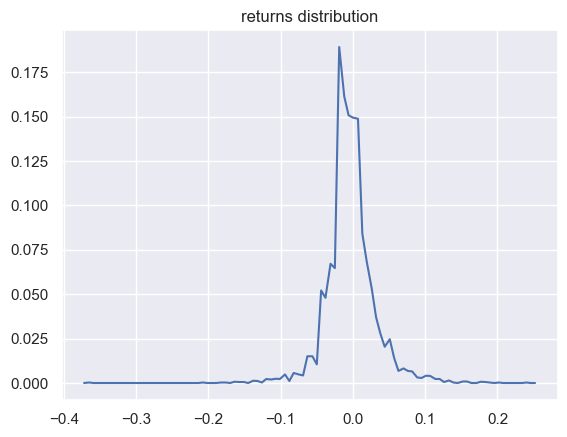

In [132]:
plt.plot(v.index, v[0])
plt.title("returns distribution")
plt.show() 

In [ ]:

plt.plot(e.index, e[0])
plt.title("mean reversion size distribution")
plt.show()


a = pd.DataFrame(mr_times(data), index = ["MA5", "MA21"]).T
e = ed(a['MA5'],100)
plt.bar(e.index, e[0])
plt.title("mean reversion time distribution")
plt.show()


In [ ]:

plt.plot(e.index, e[0])
plt.title("mean reversion size distribution")
plt.show()



a21 = list(a21['MA21'].copy())
a21 = pd.DataFrame([x for x in a21 if str(x) != 'nan'])
e21 = ed(a21[0],100)
plt.bar(e21.index, e21[0], width = 0.5,linewidth = 0.5)
plt.title("mean reversion time distribution")
plt.show()
print([sum(e[e.index <= 5][0]), sum(e[(e.index > 5)&(e.index < 15)][0]), sum(e[e.index >= 15][0])])

## processes

In [95]:
sp = np.mean(data[['MVSTD3', 'MVSTD5', 'MVSTD10', 'MVSTD21']].tail(5))

In [96]:
m = 1+np.mean(data[['MV3', 'MV5', 'MV10', 'MV21']].tail(5))

In [147]:
def vg(timeframe = 7, runs = 1000, mu = 1, sigma = 0.5, T = 1.0, S0 = 1.0, rate = 0.05):
        #variance gamma
        dt = T/timeframe
        kappa = 1/rate
        dG = np.random.gamma(dt/kappa, kappa, (timeframe, runs))
        
        dS = mu*dG+sigma*np.random.randn(timeframe, runs)*np.sqrt(dG)
        
        dS = np.insert(dS, 0, S0, axis=0)
        S = np.cumsum(dS, axis=0)
        
        S = pd.DataFrame(S).T
        return S

def srd(timeframe = 7, runs = 1000,  x0 = 1, theta = 0.5, mu = 1 ,sigma = 0.25, typ = 'Euler'):
    #square root diffusion
    walkh = np.zeros((timeframe, runs))
    walks = np.zeros((timeframe, runs))
    walkh[0] = x0
    walks[0] = x0
    dt = 1.0

    if typ.lower() =="euler":
        for t in range(1, timeframe):
            walkh[t] = (walkh[t - 1] +
                     theta * (mu - np.maximum(walkh[t - 1], 0)) * dt +
                     sigma * np.sqrt(np.maximum(walkh[t - 1], 0)) *
                     np.sqrt(dt) * np.random.standard_normal(runs))
        walks = np.maximum(walkh, 0)

    elif typ.lower() =="exact":
        for t in range(1, timeframe):
            df = 4 * mu * theta / sigma ** 2
            c = (sigma ** 2 * (1 - np.exp(-theta * dt))) / (4 * theta)
            nc = np.exp(-theta * dt) / c * walks[t - 1] 
            walks[t] = c * np.random.noncentral_chisquare(df, nc, size=runs)
    
    walks = pd.DataFrame(walks).T
    return walks

def emou(timeframe = 7, runs = 1000, x0 = 1, theta = 0.5, mu = 1, sigma = 0.25):
    dt = 1.0 / timeframe 
    walks = np.zeros((timeframe, runs))
    walks[0] = x0
    for t in range(1, timeframe):
        walks[t] = walks[t-1] + theta *(mu - walks[t-1]) * dt + sigma *np.sqrt(dt)* np.random.standard_normal(runs)
    walks = pd.DataFrame(walks).T
    return walks  
  
def ctou(T = 30, runs = 10, alpha = 1, gamma = 1, beta = 1, X_0 = 1, random_state = 1,) -> np.ndarray:
    
    lst = []
    for i in range(runs):
        
        t = np.arange(T, dtype=np.float64)
        exp_alpha_t = np.exp(-alpha * t)
        dW = np.random.normal(0.0, 1.0, T)
        exp_alpha_s = np.exp(alpha * t)
        integral_W = np.cumsum(exp_alpha_s * dW)
        integral_W = np.insert(integral_W, 0, 0)[:-1]
        if X_0 is not None:
            _X_0 = X_0
        else:
            _X_0 = gamma

        l = ( _X_0 * exp_alpha_t + gamma * (1 - exp_alpha_t) + beta * exp_alpha_t * integral_W) 
        lst.append(l)
    
    return pd.DataFrame(lst)

def fsr(timeframe = 7, runs = 1000, alpha = 1, mu = 1, sigma = 0.25, t = 0, T = 7, S0 = 1, sim_type = "EM", analytic_EM = True):
    dt = 1.0 
    N = np.random.randn(timeframe, runs)
    S = np.concatenate((S0*np.ones((1, runs)), np.zeros((timeframe, runs))), axis=0)
    
    
    if sim_type=="EM":
        if analytic_EM==True:
            a = (sigma**2)/alpha*(np.exp(-alpha*dt)-np.exp(-2*alpha*dt))
            b = mu*(sigma**2)/(2*alpha)*(1-np.exp(-alpha*dt))**2
            for i in range(0, timeframe):
                S[i+1,:] = mu + (S[i,:]-mu)*np.exp(-alpha*dt) + np.sqrt(a*S[i,:]+b)*N[i,:]
                S[i+1,:] = np.maximum(S[i+1,:], np.zeros((1, runs)))
        else:
            for i in range(0, timeframe):
                S[i+1,:] = S[i,:] + alpha*(mu-S[i,:])*dt + sigma*np.sqrt(S[i,:]*dt)*N[i,:]
                S[i+1,:] = np.maximum(S[i+1,:], np.zeros((1, runs)))
    elif sim_type=="E":
        d = 4*alpha*mu/(sigma**2)
        k = (sigma**2)*(1-np.exp(-alpha*dt))/(4*alpha)
        for i in range(0, timeframe):
            delta = 4*alpha*S[i,:]/((sigma**2)*(np.exp(alpha*dt)-1))
            S[i+1,:] = np.random.noncentral_chisquare(d, delta, (1, runs))*k
    else:
        raise TypeError("sim_type can only take values in [EM, E]")
    
    S = pd.DataFrame(S).T
    return S

def cev(timeframe = 7, runs = 1000, mu = (m-1), sigma = sp, t = 1, T = 1, S0 = 1, beta = 0.12):
    # constant elasticity volatility
    dt = T/timeframe
    dW = np.sqrt(dt)*np.random.randn(timeframe, runs)
    S = np.concatenate((S0*np.ones((1, runs)), np.zeros((timeframe, runs))), axis=0) 

    for i in range(0, timeframe):
        S[i+1,:] = S[i,:] + mu*S[i,:]*dt + sigma*(S[i,:]**(beta+1))*dW[i,:]
        S[i+1,:] = np.maximum(S[i+1,:], np.zeros((1, runs)))
    
    S = pd.DataFrame(S).T
    return S


def heston(timeframe = 7, runs = 1000, mu = m, k = 1, theta = 1, epsilon = sp, t = 1, T = 1, S0 = 1, V0 = 1, rho = 0.05):
    
        dt = T/timeframe
        Nv = np.random.randn(timeframe, runs)
        N = np.random.randn(timeframe, runs)
        NS = rho*Nv + np.sqrt(1-rho**2)*N
        
        v = np.concatenate((V0*np.ones((1, runs)), np.zeros((timeframe, runs))), axis=0)
        S = np.concatenate((V0*np.ones((1, runs)), np.zeros((timeframe, runs))), axis=0)
        
        a = (epsilon**2)/k*(np.exp(-k*dt)-np.exp(-2*k*dt))
        b = theta*(epsilon**2)/(2*k)*(1-np.exp(-k*dt))**2
        for i in range(0, timeframe):
            v[i+1,:] = theta + (v[i,:]-theta)*np.exp(-k*dt) + np.sqrt(a*v[i,:]+b)*Nv[i,:]
            v[i+1,:] = np.maximum(v[i+1,:], np.zeros((1, runs)))
        
        for j in range(0, timeframe):
            S[j+1,:] = S[j,:] + (mu-0.5*v[j,:])*dt + epsilon*np.sqrt(v[j,:]*dt)*NS[j,:]
            S[j+1,:] = np.maximum(S[j+1,:], np.zeros((1, runs)))
        
        S = pd.DataFrame(S).T
        v = pd.DataFrame(v).T
        return S, v

(       0         1         2         3         4         5         6         7
 0    1.0  1.071039  1.145327  1.210767  1.278854  1.347359  1.429881  1.500037
 1    1.0  1.074076  1.152345  1.225757  1.286038  1.350059  1.431593  1.503192
 2    1.0  1.068152  1.135651  1.204958  1.288619  1.359057  1.423380  1.499688
 3    1.0  1.067806  1.144656  1.233048  1.305550  1.367771  1.440430  1.514471
 4    1.0  1.075483  1.135583  1.194043  1.254987  1.328388  1.410556  1.485444
 ..   ...       ...       ...       ...       ...       ...       ...       ...
 995  1.0  1.057211  1.127533  1.195044  1.260199  1.349867  1.439187  1.520272
 996  1.0  1.059716  1.124670  1.185793  1.254651  1.320944  1.397524  1.465988
 997  1.0  1.076927  1.153782  1.223095  1.300894  1.385900  1.457782  1.515214
 998  1.0  1.069163  1.145963  1.227334  1.290112  1.358764  1.426001  1.501290
 999  1.0  1.068467  1.136544  1.201910  1.272138  1.339999  1.402587  1.459823
 
 [1000 rows x 8 columns],
        0   

In [152]:
mean = []
std = []
cvar = []


srd(7,1000, x0 = 1, theta = 0.05, mu = m, sigma = sp, typ = "Euler")
srd(7,1000, x0 = 1, theta = 0.05, mu = m, sigma = sp, typ = "exact")
fsr(7, 1000, 0.06, 1,0.06, 0, 6, 1)
emou(7, 1000, x0 = 1, theta = 0.05, mu = m, sigma = sp)
ctou(7, 1000, beta = 0.125)
vg(7,1000)
cev(7, 1000, mu = 0, sigma = 0.05)
heston(7, 1000, mu = 0.5)

(       0         1         2         3         4         5         6         7
 0    1.0  0.992960  0.991323  0.992694  0.980225  0.984079  0.988687  0.997077
 1    1.0  0.998797  0.997442  0.990215  0.993926  0.993104  1.006151  1.007679
 2    1.0  0.998664  0.999542  0.997803  1.005935  1.017148  1.009260  0.998136
 3    1.0  0.981385  0.979502  0.976830  0.979112  0.976266  0.970760  0.975553
 4    1.0  0.998460  1.008521  1.006852  0.997224  1.007179  0.998966  1.001896
 ..   ...       ...       ...       ...       ...       ...       ...       ...
 995  1.0  0.996350  0.982413  0.975980  0.972307  0.971028  0.971902  0.963996
 996  1.0  0.997788  1.011028  1.004051  1.002398  1.007737  1.012879  1.013644
 997  1.0  1.010257  0.998115  0.995104  0.990272  0.979818  0.967351  0.969640
 998  1.0  1.003781  1.002797  0.996206  0.998001  1.000372  0.997560  0.996133
 999  1.0  0.996427  0.998079  0.995115  1.000064  1.007857  0.997107  0.997650
 
 [1000 rows x 8 columns],
        0   

## check for periods

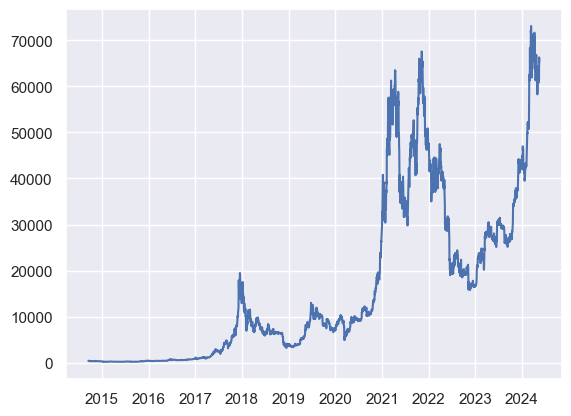

In [227]:
prices = pd.DataFrame()
prices['BTC-USD'] = TMRW.DATA.data('BTC-USD','2014-01-01','2024-05-17')['Close']
prices['ETH-USD'] = TMRW.DATA.data('ETH-USD','2014-01-01','2024-05-17')['Close']
returns = prices.pct_change()#.dropna()
plt.plot(prices['BTC-USD'].index, prices['BTC-USD'])
plt.show()

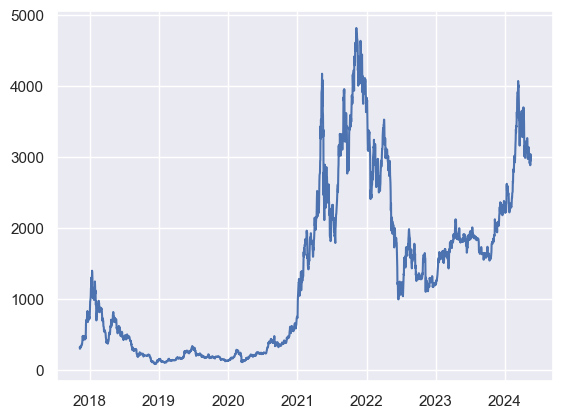

In [228]:
plt.plot(prices['ETH-USD'].index, prices['ETH-USD'])
plt.show()

mean of interval 1: 0.005428993861531186 mean of interval 2: 0.004853252384988107


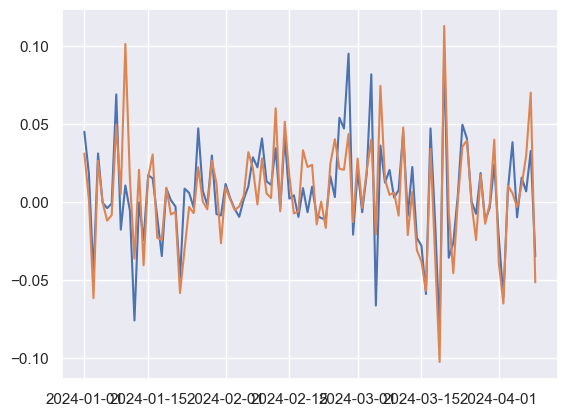

True 0.9006463113301119


In [239]:
import pandas as pd
from scipy.stats import ttest_ind

t = returns[returns.index >= '2024-01-01'].head(100)

t1 = t['BTC-USD']
t2 = t['ETH-USD']

plt.plot(t1.index, t1)
print("mean of interval 1:", np.mean(t1),"mean of interval 2:", np.mean(t2))
plt.plot(t2.index, t2)
plt.show()

print(ttest_ind(t1,t2)[1] > 0.50, ttest_ind(t1,t2)[1])

mean of interval 1: 0.0007415442092159141 mean of interval 2: -0.0057405981861820485


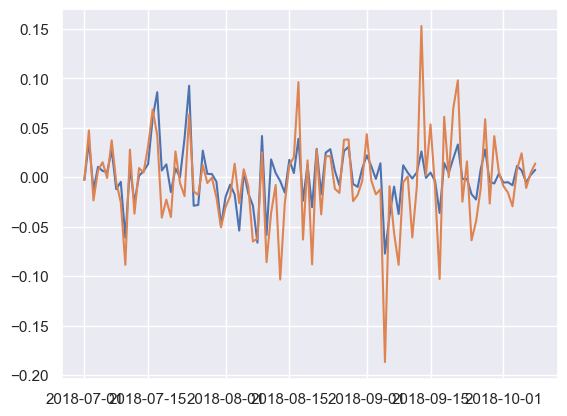

False 0.23018814757937636


In [245]:
import pandas as pd
from scipy.stats import ttest_ind

t = returns[returns.index >= '2018-07-01'].head(100)

t1 = t['BTC-USD']
t2 = t['ETH-USD']

plt.plot(t1.index, t1)
print("mean of interval 1:", np.mean(t1),"mean of interval 2:", np.mean(t2))
plt.plot(t2.index, t2)
plt.show()

print(ttest_ind(t1,t2)[1] > 0.50, ttest_ind(t1,t2)[1])

# test

In [ ]:
data['VWV5'] = TMRW.FINANCE.volume_weighted_velocity(data, window = 5)
data['VWV10'] = TMRW.FINANCE.volume_weighted_velocity(data, window = 10)
data['VWV60'] = TMRW.FINANCE.volume_weighted_velocity(data, window = 60)

data['VWM5'] = TMRW.FINANCE.volume_weighted_mean(data, window = 5)
data['VWM10'] = TMRW.FINANCE.volume_weighted_mean(data, window = 10)
data['VWM60'] = TMRW.FINANCE.volume_weighted_mean(data, window = 60)

MA = data[['Close','MA5', 'MA10', 'MA21', 'MA60']] # time moving averages
VWA = data[['Close','VWM5','VWM10','VWmean21','VWM60']] # volume moving averages

MR = data[['velocity', 'MV5','MV10','MV21', 'MV60']]
VWR = data[['velocity', 'VWV5','VWV10','VWvelocity21','VWV60']]

plt.scatter((data['acceleration']/data['volume velocity'])[-100:], data['velocity'].shift(2)[-100:])
plt.xlim(-100,100)
plt.show()

plt.plot(MA.index[-100:-50], MA.Close[-100:-50], color = "k", linewidth = 2, label = "Close")

#plt.plot(MA.index[-100:], MA.MA5[-100:], color = "r", linewidth = 1, label = "MA5")
#plt.plot(MA.index[-100:], MA.MA10[-100:], color = "g", linewidth = 1, label = "MA10")
#plt.plot(MA.index[-100:], MA.MA21[-100:], color = "y", linewidth = 1, label = "MA21")
#plt.plot(MA.index[-100:], MA.MA60[-100:], color = "b", linewidth = 1, label = "MA60")

plt.plot(MA.index[-100:-50], VWA.VWM10[-100:-50], color = "r", linewidth = 1, label = "VA5")
#plt.plot(MA.index[-100:], VWA.VWM10[-100:], color = "g", linewidth = 1, label = "VA10")
#plt.plot(MA.index[-100:], VWA.VWmean21[-100:], color = "y", linewidth = 1, label = "VA21")
#plt.plot(MA.index[-100:], VWA.VWM60[-100:], color = "b", linewidth = 1, label = "VA60")

plt.legend()
plt.show()



plt.scatter(MA.Close, MR['MV5']/MA['MA5'], color = "r", linewidth = 1, label = "MA5")
plt.ylim(-0.00002, 0.00002)

plt.scatter(MA.Close[-300:], MA.MA5[-300:], color = "r", linewidth = 1, label = "MA5", )
plt.scatter(MA.Close[-300:], VWA.VWM5[-300:], color = "g", linewidth = 2, label = "Close vs VA5")
plt.scatter(MA.MA5[-300:], VWA.VWM5[-300:], color = "b", linewidth = 1, label = "MA5")
plt.scatter(MR.MV21[-300:].shift(-1), VWR.VWvelocity21[-300:], color = "b", linewidth = 1, label = "MV5 vs VV5")

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

diabetes = load_diabetes()
X_train, X_val, y_train, y_val = train_test_split(
  diabetes.data, diabetes.target, random_state=0)

model = Ridge(alpha=1e-2).fit(X_train, y_train)

# Fetch the importances from model.coef_
for i in range(len(model.coef_)):
  print(f"{diabetes.feature_names[i]:<8}"
  f"{abs(model.coef_[i]):.3f}")

In [ ]:
from sklearn.datasets import load_diabetes
from numpy import cov
from numpy import transpose


diabetes = load_diabetes()
for i in range(len(transpose(diabetes.data))):
  covariance = cov(transpose(diabetes.data)[i], diabetes.target)
  # Fetch the importances in covariance[0][1]
  print(f"{diabetes.feature_names[i]:<8}"
          f"{abs(covariance[0][1]):.3f}")

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv("D://Blogs//train.csv")
X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
data = pd.read_csv("D://Blogs//train.csv")
X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
from sklearn.tree import DecisionTreeClassifier

y = x['indicator1']

X = x.loc[:, x.columns != 'indicator1']
X = X.loc[:, X.columns != 'indicator3']
X = X.loc[:, X.columns != 'indicator7']
X = X.loc[:, X.columns != 'indicator21']
#X = x[['mean velocity 3', 'mean velocity 5', 'UD3indicator', 'UD5indicator', 'volume velocity', 'mean std 3']]
X = x[['volume velocity', 'volume acceleration', 'MSTD3', 'MSTD5', 'MSTD10', 'mean velocity 3', 'mean velocity 5', 'mean velocity 10', 'mean std 3', 'mean std 5', 'mean std 10']]

clf3 = DecisionTreeClassifier(max_depth=1000)
clf3 = clf3.fit(X, y)
scores = cross_val_score(clf3, X, y, scoring='accuracy', cv=10)
print("Accuracy:",(scores.mean(), scores.std()))

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from xgboost import XGBClassifier

y = x['indicator1']
X = x.loc[:, x.columns != 'indicator1']
X = X.loc[:, X.columns != 'indicator3']
X = X.loc[:, X.columns != 'indicator7']
X = X.loc[:, X.columns != 'indicator21']

#X = x[['volume velocity', 'volume acceleration', 'MSTD3', 'MSTD5', 'MSTD10', 'mean velocity 3', 'mean velocity 5', 'mean velocity 10', 'mean std 3', 'mean std 5', 'mean std 10']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=1) # random sampling

model = XGBClassifier()
model.fit(X_train, y_train)#, xgb_model=model.load_model('XGB.json'))


feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

#plot feature importance
plot_importance(model)
plt.show()

#for at lave predictions skal modellen have alle de satte features

#model.save_model('XGB.json')


# mean std 10(3), mean std 5(2), mstd21, volume velocity(2), mean velocity 10(3), mean velocity 5(2), mean velocity 3(2). MSTD35

In [ ]:
#%%
"""
Created on January 30, 2022
Heston Model Simulation
@author: Nicholas Burgess
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum 

# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

# European Option Price evaluating Characteristic Function using COSine Method
def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of cosine expansion terms
    # L    - size of truncation domain (type:L=8 or L=10)  
        
    # reshape K to a column vector
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    #assigning i=sqrt(-1)
    i = np.complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for Put Prices  
    H_k = CallPutCoefficients(CP,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))     
    return value

# Chi and Psi Evaluation Method
def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

# Determine coefficients for Call or Put Prices 
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)                  
    return H_k    

# Evaluate Heston model using closed-form characteristic function approach
def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
    i = np.complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))\
        *(kappa-gamma*rho*i*u-D1(u))
        
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A  = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
        - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
    
    # Characteristic function for the Heston's model    
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf 

# European Option Price given Monte Carlo Paths
# Here we specify our option payoff
def EuropeanOptionPriceFromMCPaths(CP,S,K,T,r):
    # S is a vector of Monte Carlo samples at T
    result = np.zeros([len(K),1])
    if CP == OptionType.CALL:
        for (idx,k) in enumerate(K):
            result[idx] = np.exp(-r*T)*np.mean(np.maximum(S-k,0.0))
    elif CP == OptionType.PUT:
        for (idx,k) in enumerate(K):
            result[idx] = np.exp(-r*T)*np.mean(np.maximum(k-S,0.0))
    return result

# Generate Heston Paths using Euler Discretization
def GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):
    
    # Vector Initialization
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)
    
    time = np.zeros([NoOfSteps+1])
    dt = T / float(NoOfSteps)

    for i in range(0,NoOfSteps):
        # Apply Central Limit Theorem: Standard Normal dist'n has better convergence
        # Make sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0-rho**2)*Z2[:,i]
        
        # Compute Correlated Brownian Motions using Cholesky Decomposition
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
        
        # Variance cannot be negative so we use apply the truncation boundary condition
        # Truncated boundary condition: v((i+1) = max(v(i+1),0)
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i])
        V[:,i+1] = np.maximum(V[:,i+1],0.0)
        
        # Euler Discretization of Log-Normal Asset Process
        X[:,i+1] = X[:,i] + (r - 0.5*V[:,i])*dt + np.sqrt(V[:,i])*(W2[:,i+1]-W2[:,i])
        time[i+1] = time[i] +dt
        
    #Compute exponent
    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

def CIR_Sample(NoOfPaths,kappa,gamma,vbar,s,t,v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    sample = c* np.random.noncentral_chisquare(delta,kappaBar,NoOfPaths)
    return  sample

# Generate Heston Monte Carlo Paths using Almost Exact Simulation
def GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):    
    
    # Vector Initialization
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        
        # Apply Central Limit Theorem - Standard Normal dist'n has better convergence
        # Make sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
        
        # Evaluate the Browniam Motion: W = Z.sqrt(dt)
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        
        # Exact samples for the variance process
        V[:,i+1] = CIR_Sample(NoOfPaths,kappa,gamma,vbar,0,dt,V[:,i])
        
        # AES Constant Terms
        k0 = (r -rho/gamma*kappa*vbar)*dt
        k1 = (rho*kappa/gamma -0.5)*dt - rho/gamma
        k2 = rho / gamma
        
        # Almost Exact Simulation for Log-Normal Asset Process
        X[:,i+1] = X[:,i] + k0 + k1*V[:,i] + k2 *V[:,i+1] + np.sqrt((1.0-rho**2)*V[:,i])*(W1[:,i+1]-W1[:,i])
        
        time[i+1] = time[i] +dt
        
    #Compute exponent
    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

# Black-Scholes Call option price
def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):
    #print('Maturity T={0} and t={1}'.format(T,t))
    #print(float(sigma * np.sqrt(T-t)))
    #print('strike K ={0}'.format(K))
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * (T-t)) / (sigma * np.sqrt(T-t))
    d2    = d1 - sigma * np.sqrt(T-t)
    
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * (T-t))
     #   print(value)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * (T-t)) - st.norm.cdf(-d1)*S_0
      #  print(value)
    return value

# Run Simulation Processes
def RunSimulation(CP,ResultsChart):
    # CP = CALL or PUT
    # ChartNumber = The results chart number (use the same number to overlay charts)
    
    # Simulation Paths and Euler Timesteps
    NoOfPaths = 2500
    NoOfSteps = 1000
    
    # Heston model parameters from calibration process
    gamma = 1.0     # vol of vol
    kappa = 0.5     # speed of mean reversion
    vbar  = 0.04    # long-term variance
    rho   = -0.9    # correlation (negative as variance moves in opposiste direction to asset)
    T     = 1.0     # maturity
    r     = 0.1     # interest rate
    S_0   = 100.0   # initial asset value
    v0    = 0.04    # initial variance
    
    CP_String = "*** CALL OPTIONS ***"
    if CP==OptionType.PUT:
        CP_String = "*** PUT OPTIONS ***"
    
    # First we define a range of strikes and check the convergence
    # min strike, max strike and number of abscissae
    K = np.linspace(S_0*0.8, S_0*1.4, 25)
    
    # Exact solution with the COSine method
    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)
    
    # The COSine method with 1,000 expansion terms to approx characteristic function
    optValueExact = CallPutOptionPriceCOSMthd(cf, CP, S_0, r, T, K, 1000, 8)
    
    # Euler simulation
    pathsEULER = GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    S_Euler = pathsEULER["S"]
    
    # Almost exact simulation
    pathsAES = GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    S_AES = pathsAES["S"]
    
    # Here we evaluate the option payoff - can be modified for exotics et al.
    OptPrice_EULER = EuropeanOptionPriceFromMCPaths(CP,S_Euler[:,-1],K,T,r)
    OptPrice_AES   = EuropeanOptionPriceFromMCPaths(CP,S_AES[:,-1],K,T,r)
    
    # Plot Simulated Option Prices for Exact, Euler and AES Schemes
    plt.figure(ResultsChart)
    plt.plot(K,optValueExact,'-r')
    plt.plot(K,OptPrice_EULER,'--k')
    plt.plot(K,OptPrice_AES,'.b')
    plt.legend(['Exact (COS)','Euler','AES'])
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('option price')
    plt.title('Simulated Option Prices')
    
    # Here we will analyze the convergence a variety of variance time steps dtV
    dtV = np.array([1.0, 1.0/4.0, 1.0/8.0,1.0/16.0,1.0/32.0,1.0/64.0])
    NoOfStepsV = [int(T/x) for x in dtV]
    
    # Specify strike for analysis
    K = np.array([140])
    
    # 1. Pricing using Exact Simulation
    ###################################
    optValueExact = CallPutOptionPriceCOSMthd(cf, CP, S_0, r, T, K, 1000, 8)
    
    # Initialize Standard Error Vectors
    errorEuler = np.zeros([len(dtV),1])
    errorAES = np.zeros([len(dtV),1])
    
    for (idx,NoOfSteps) in enumerate(NoOfStepsV):
        
        # 2. Euler Discretization
        #########################
        np.random.seed(3)
        pathsEULER = GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
        S_Euler = pathsEULER["S"]
        
        # Evaluate the option payoff - can be modified to exotics et al.
        OptPriceEULER = EuropeanOptionPriceFromMCPaths(CP,S_Euler[:,-1],K,T,r)
        errorEuler[idx] = OptPriceEULER-optValueExact
        
        # 3. Almost Exact Simulation (AES)
        ##################################
        np.random.seed(3)
        pathsAES = GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
        S_AES = pathsAES["S"]
        
        # Evaluate the option payoff - can be modified to exotics et al.
        OptPriceAES   = EuropeanOptionPriceFromMCPaths(CP,S_AES[:,-1],K,T,r)
        errorAES[idx] = OptPriceAES-optValueExact

    print()
    print(CP_String)

    print()
    print("Euler Scheme")
    print("------------")
    print("Strike (K), Timestep (dt), Standard Error (eps)")
    for i in range(0,len(NoOfStepsV)):
        print("Euler Scheme, K = {0}, dt = {1}, eps = {2}".format(K,dtV[i],errorEuler[i]))
    
    print()
    print("Almost Exact Simulation (AES)")
    print("-----------------------------")
    print("Strike (K), Timestep (dt), Standard Error (eps)")
    for i in range(0,len(NoOfStepsV)):
        print("AES Scheme, K = {0}, dt = {1}, eps = {2}".format(K,dtV[i],errorAES[i]))
        
# Run Simulation for Calls then Puts        
RunSimulation(OptionType.CALL,1)
RunSimulation(OptionType.PUT,2)

In [ ]:
def calculate_spread_zscore(pairs, symbols, lookback=100):
    """
    Creates a hedge ratio between the two symbols by calculating
    a rolling linear regression with a defined lookback period. This
    is then used to create a z-score of the 'spread' between the two
    symbols based on a linear combination of the two.

    Parameters
    ----------
    pairs : `pd.DataFrame`
        A DataFrame containing Close price for SPY and IWM. Index is a 
        Datetime object.
    symbols : `tup`
        Tuple containing ticker symbols as `str`.
    lookback : `int`, optional (default: 100)
        Lookback preiod for rolling linear regression.

    Returns
    -------
    pairs : 'pd.DataFrame'
        Updated DataFrame containing the spread and z score between
        the two symbols based on the rolling linear regression.    
    """

    # Use the statsmodels Rolling Ordinary Least Squares method to fit
    # a rolling linear regression between the two closing price time series
    print("Fitting the rolling Linear Regression...")

    model = RollingOLS(
        endog=pairs['%s_close' % symbols[0].lower()],
        exog=sm.add_constant(pairs['%s_close' % symbols[1].lower()]),
        window=lookback
    )
    rres = model.fit()
    params = rres.params.copy()
    
    
    # Construct the hedge ratio and eliminate the first 
    # lookback-length empty/NaN period
    pairs['hedge_ratio'] = params['iwm_close']
    pairs.dropna(inplace=True)

    # Create the spread and then a z-score of the spread
    print("Creating the spread/zscore columns...")
    pairs['spread'] = (
        pairs['spy_close'] - pairs['hedge_ratio']*pairs['iwm_close']
    )
    pairs['zscore'] = (
        pairs['spread'] - np.mean(pairs['spread']))/np.std(pairs['spread']
    )
    return pairs

def create_long_short_market_signals(
        pairs, symbols, z_entry_threshold=2.0, z_exit_threshold=1.0
    ):
    """
    Create the entry/exit signals based on the exceeding of z_entry_threshold
    for entering a position and falling below z_exit_threshold for exiting
    a position.

    Parameters
    ----------
    pairs : `pd.DataFrame`
        Updated DataFrame containing the close price, spread and z score
        between the two symbols.
    symbols : `tup`
        Tuple containing ticker symbols as `str`.
    z_entry_threshold : `float`, optional (default:2.0)
        Z Score threshold for market entry. 
    z_exit_threshold : `float`, optional (default:1.0)
        Z Score threshold for market exit.

    Returns
    -------
    pairs : `pd.DataFrame`
        Updated DataFrame containing long, short and exit signals.
    """

    # Calculate when to be long, short and when to exit
    pairs['longs'] = (pairs['zscore'] <= -z_entry_threshold)*1.0
    pairs['shorts'] = (pairs['zscore'] >= z_entry_threshold)*1.0
    pairs['exits'] = (np.abs(pairs['zscore']) <= z_exit_threshold)*1.0

    # These signals are needed because we need to propagate a
    # position forward, i.e. we need to stay long if the zscore
    # threshold is less than z_entry_threshold by still greater
    # than z_exit_threshold, and vice versa for shorts.
    pairs['long_market'] = 0.0
    pairs['short_market'] = 0.0

    # These variables track whether to be long or short while
    # iterating through the bars
    long_market = 0
    short_market = 0

    # Calculates when to actually be "in" the market, i.e. to have a
    # long or short position, as well as when not to be.
    # Since this is using iterrows to loop over a dataframe, it will
    # be significantly less efficient than a vectorised operation,
    # i.e. slow!
    print("Calculating when to be in the market (long and short)...")
    for i, b in enumerate(pairs.iterrows()):
        # Calculate longs
        if b[1]['longs'] == 1.0:
            long_market = 1            
        # Calculate shorts
        if b[1]['shorts'] == 1.0:
            short_market = 1
        # Calculate exists
        if b[1]['exits'] == 1.0:
            long_market = 0
            short_market = 0
        # This directly assigns a 1 or 0 to the long_market/short_market
        # columns, such that the strategy knows when to actually stay in!
        pairs.iloc[i]['long_market'] = long_market
        pairs.iloc[i]['short_market'] = short_market
    return pairs

In [ ]:
# coding: utf-8

# In[1]:

#assuming you already know how monte carlo works
#if not, plz click the link below
# https://datascienceplus.com/how-to-apply-monte-carlo-simulation-to-forecast-stock-prices-using-python/

#monte carlo simulation is a buzz word for people outside of financial industry
#in the industry, everybody jokes about it but no one actually uses it
#including my risk quant friends, they be like why the heck use that
#you may argue its application in option pricing to monitor fat tail events
#seriously, did anyone predict 2008 financial crisis?
#or did anyone foresee the vix surging in early 2018?

#the weakness of monte carlo, perhaps in every forecast methodology
#is that our pseudo random number is generated via empirical distribution
#in another word, we use the past to predict the future
#if something has never happened in the past
#how can you predict it with our limited imagination
#its like muggles trying to understand the wizard world
#laplace smoothing is actually better than monte carlo in this case

#the idea presented here is very straight forward
#we construct a model to get mean and variance of its residual (return)
#we generate the next possible price by geometric brownian motion
#we run this simulations as many times as possible
#naturally we should acquire a large amount of data in the end
#we pick the forecast that has the least std against the original data series
#we would check if the best forecast can predict the future direction (instead of actual price)
#and how well monte carlo catches black swans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf
import random as rd
from sklearn.model_selection import train_test_split


# In[2]:

#this list is purely designed to generate gradient color 
global colorlist
colorlist=['#fffb77',
 '#fffa77',
 '#fff977',
 '#fff876',
 '#fff776',
 '#fff676',
 '#fff576',
 '#fff475',
 '#fff375',
 '#fff275',
 '#fff175',
 '#fff075',
 '#ffef74',
 '#ffef74',
 '#ffee74',
 '#ffed74',
 '#ffec74',
 '#ffeb73',
 '#ffea73',
 '#ffe973',
 '#ffe873',
 '#ffe772',
 '#ffe672',
 '#ffe572',
 '#ffe472',
 '#ffe372',
 '#ffe271',
 '#ffe171',
 '#ffe071',
 '#ffdf71',
 '#ffde70',
 '#ffdd70',
 '#ffdc70',
 '#ffdb70',
 '#ffda70',
 '#ffd96f',
 '#ffd86f',
 '#ffd76f',
 '#ffd66f',
 '#ffd66f',
 '#ffd56e',
 '#ffd46e',
 '#ffd36e',
 '#ffd26e',
 '#ffd16d',
 '#ffd06d',
 '#ffcf6d',
 '#ffce6d',
 '#ffcd6d',
 '#ffcc6c',
 '#ffcb6c',
 '#ffca6c',
 '#ffc96c',
 '#ffc86b',
 '#ffc76b',
 '#ffc66b',
 '#ffc56b',
 '#ffc46b',
 '#ffc36a',
 '#ffc26a',
 '#ffc16a',
 '#ffc06a',
 '#ffbf69',
 '#ffbe69',
 '#ffbd69',
 '#ffbd69',
 '#ffbc69',
 '#ffbb68',
 '#ffba68',
 '#ffb968',
 '#ffb868',
 '#ffb768',
 '#ffb667',
 '#ffb567',
 '#ffb467',
 '#ffb367',
 '#ffb266',
 '#ffb166',
 '#ffb066',
 '#ffaf66',
 '#ffad65',
 '#ffac65',
 '#ffab65',
 '#ffa964',
 '#ffa864',
 '#ffa763',
 '#ffa663',
 '#ffa463',
 '#ffa362',
 '#ffa262',
 '#ffa062',
 '#ff9f61',
 '#ff9e61',
 '#ff9c61',
 '#ff9b60',
 '#ff9a60',
 '#ff9860',
 '#ff975f',
 '#ff965f',
 '#ff955e',
 '#ff935e',
 '#ff925e',
 '#ff915d',
 '#ff8f5d',
 '#ff8e5d',
 '#ff8d5c',
 '#ff8b5c',
 '#ff8a5c',
 '#ff895b',
 '#ff875b',
 '#ff865b',
 '#ff855a',
 '#ff845a',
 '#ff8259',
 '#ff8159',
 '#ff8059',
 '#ff7e58',
 '#ff7d58',
 '#ff7c58',
 '#ff7a57',
 '#ff7957',
 '#ff7857',
 '#ff7656',
 '#ff7556',
 '#ff7455',
 '#ff7355',
 '#ff7155',
 '#ff7054',
 '#ff6f54',
 '#ff6d54',
 '#ff6c53',
 '#ff6b53',
 '#ff6953',
 '#ff6852',
 '#ff6752',
 '#ff6552',
 '#ff6451',
 '#ff6351',
 '#ff6250',
 '#ff6050',
 '#ff5f50',
 '#ff5e4f',
 '#ff5c4f',
 '#ff5b4f',
 '#ff5a4e',
 '#ff584e',
 '#ff574e',
 '#ff564d',
 '#ff544d',
 '#ff534d',
 '#ff524c',
 '#ff514c',
 '#ff4f4b',
 '#ff4e4b',
 '#ff4d4b',
 '#ff4b4a',
 '#ff4a4a']


# In[3]:


#this is where the actual simulation happens
#testsize denotes how much percentage of dataset would be used for testing
#simulation denotes the number of simulations
#theoretically speaking, the larger the better
#given the constrained computing power
#we have to take a balance point between efficiency and effectiveness
def monte_carlo(data,testsize=0.5,simulation=100,**kwargs):    
    
    #train test split as usual
    df,test=train_test_split(data,test_size=testsize,shuffle=False,**kwargs)
    forecast_horizon=len(test)
    
    #we only care about close price
    #if there has been dividend issued
    #we use adjusted close price instead
    df=df.loc[:,['Close']]
        
    #here we use log return
    returnn=np.log(df['Close'].iloc[1:]/df['Close'].shift(1).iloc[1:])
    drift=returnn.mean()-returnn.var()/2
    
    #we use dictionary to store predicted time series
    d={}
    
    #we use geometric brownian motion to compute the next price
    # https://en.wikipedia.org/wiki/Geometric_Brownian_motion
    for counter in range(simulation):
        d[counter]=[df['Close'].iloc[0]]
      
        #we dont just forecast the future
        #we need to compare the forecast with the historical data as well
        #thats why the data range is training horizon plus testing horizon
        for i in range(len(df)+forecast_horizon-1):
         
            #we use standard normal distribution to generate pseudo random number
            #which is sufficient for our monte carlo simulation
            sde=drift+returnn.std()*rd.gauss(0,1)
            temp=d[counter][-1]*np.exp(sde)
        
            d[counter].append(temp.item())
    
    #to determine which simulation is the best fit
    #we use simple criterias, the smallest standard deviation
    #we iterate through every simulation and compare it with actual data
    #the one with the least standard deviation wins
    std=float('inf')
    pick=0
    for counter in range(simulation):
    
        temp=np.std(np.subtract(
                    d[counter][:len(df)],df['Close']))
        if temp<std:
            std=temp
            pick=counter
    
    return forecast_horizon,d,pick


# In[4]:

#result plotting
def plot(df,forecast_horizon,d,pick,ticker):
    
    #the first plot is to plot every simulation
    #and highlight the best fit with the actual dataset
    #we only look at training horizon in the first figure
    ax=plt.figure(figsize=(10,5)).add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for i in range(int(len(d))):
        if i!=pick:
            ax.plot(df.index[:len(df)-forecast_horizon], \
                    d[i][:len(df)-forecast_horizon], \
                    alpha=0.05)
    ax.plot(df.index[:len(df)-forecast_horizon], \
            d[pick][:len(df)-forecast_horizon], \
            c='#5398d9',linewidth=5,label='Best Fitted')
    df['Close'].iloc[:len(df)-forecast_horizon].plot(c='#d75b66',linewidth=5,label='Actual')
    plt.title(f'Monte Carlo Simulation\nTicker: {ticker}')
    plt.legend(loc=0)
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()
    
    #the second figure plots both training and testing horizons
    #we compare the best fitted plus forecast with the actual history
    #the figure reveals why monte carlo simulation in trading is house of cards
    #it is merely illusion that monte carlo simulation can forecast any asset price or direction
    ax=plt.figure(figsize=(10,5)).add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.plot(d[pick],label='Best Fitted',c='#edd170')
    plt.plot(df['Close'].tolist(),label='Actual',c='#02231c')
    plt.axvline(len(df)-forecast_horizon,linestyle=':',c='k')
    plt.text(len(df)-forecast_horizon-50, \
             max(max(df['Close']),max(d[pick])),'Training', \
             horizontalalignment='center', \
             verticalalignment='center')
    plt.text(len(df)-forecast_horizon+50, \
             max(max(df['Close']),max(d[pick])),'Testing', \
             horizontalalignment='center', \
             verticalalignment='center')
    plt.title(f'Training versus Testing\nTicker: {ticker}\n')
    plt.legend(loc=0)
    plt.ylabel('Price')
    plt.xlabel('T+Days')
    plt.show()


# In[5]:

#we also gotta test if the surge in simulations increases the prediction accuracy
#simu_start denotes the minimum simulation number
#simu_end denotes the maximum simulation number
#sim_delta denotes how many steps it takes to reach the max from the min
#its kinda like range(simu_start,simu_end,simu_delta)
def test(df,ticker,simu_start=100,simu_end=1000,simu_delta=100,**kwargs):
    
    table=pd.DataFrame()
    table['Simulations']=np.arange(simu_start,simu_end+simu_delta,simu_delta)
    table.set_index('Simulations',inplace=True)
    table['Prediction']=0

    #for each simulation
    #we test if the prediction is accurate
    #for instance
    #if the end of testing horizon is larger than the end of training horizon
    #we denote the return direction as +1
    #if both actual and predicted return direction align
    #we conclude the prediction is accurate
    #vice versa
    for i in np.arange(simu_start,simu_end+1,simu_delta):
        print(i)
        
        forecast_horizon,d,pick=monte_carlo(df,simulation=i,**kwargs)
        
        actual_return=np.sign( \
                              df['Close'].iloc[len(df)-forecast_horizon]-df['Close'].iloc[-1])
        
        best_fitted_return=np.sign(d[pick][len(df)-forecast_horizon]-d[pick][-1])
        table.at[i,'Prediction']=np.where(actual_return==best_fitted_return,1,-1)
        
    #we plot the horizontal bar chart 
    #to show the accuracy does not increase over the number of simulations
    ax=plt.figure(figsize=(10,5)).add_subplot(111)
    ax.spines['right'].set_position('center')
    ax.spines['top'].set_visible(False)

    plt.barh(np.arange(1,len(table)*2+1,2),table['Prediction'], \
             color=colorlist[0::int(len(colorlist)/len(table))])

    plt.xticks([-1,1],['Failure','Success'])
    plt.yticks(np.arange(1,len(table)*2+1,2),table.index)
    plt.xlabel('Prediction Accuracy')
    plt.ylabel('Times of Simulation')
    plt.title(f"Prediction accuracy doesn't depend on the numbers of simulation.\nTicker: {ticker}\n")
    plt.show()


# In[6]:

#lets try something extreme, pick ge, the worst performing stock in 2018
#see how monte carlo works for both direction prediction and fat tail simulation
#why the extreme? well if we are risk quants, we care about value at risk, dont we
#if quants only look at one sigma event, the portfolio performance would be devastating
def main():
    
    stdate='2016-01-15'
    eddate='2019-01-15'
    ticker='GE'

    df=yf.download(ticker,start=stdate,end=eddate)
    df.index=pd.to_datetime(df.index)
    
    forecast_horizon,d,pick=monte_carlo(df)
    plot(df,forecast_horizon,d,pick,ticker)
    test(df,ticker)


if __name__ == '__main__':
    main()

In [ ]:



"""
TMRW.FINANCE

Created on Mon Apr 15 22:44:02 2024

Version 1.0.0 bundled on Fri Aug 09 12:00:00 2024

@Author: Mark Daniel Balle Brezina
@Contributors: Magnus Faber, Jonathan Emil Balle Brezina
"""
import TMRW
import yfinance as yf
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

from datetime import datetime, date, timedelta, timezone
import sqlalchemy as sa

from scipy.stats import norm
from scipy.stats import linregress
from scipy import integrate
from statsmodels.tsa.stattools import adfuller
from hmmlearn.hmm import GaussianHMM

import warnings
warnings.filterwarnings("ignore")

def sdata(x, y, z):
    # x is a stock symbol
    # y is a start date
    # z is an end date
    # kan bruges på commodities, currencies og aktier
    
    #MSFT er en aktier der kan bruges
    #USDEUR=X er en currency der kan bruges
    #GC=F er guld priser
    
    st = pd.DataFrame()
    t = yf.Ticker(x)
    st = t.history(start=y, end=z)
    st.index = pd.to_datetime(st.index).tz_localize(None)
    return(st)


###############################################################################
#                        Slopes, returns and accelerations
#                        For calculating import 
#                        intra and inter day differences
###############################################################################

def slope(array):
    """
    """
    y = np.array(array)
    x = np.arange(len(y))
    slopes, intercept, r_value, p_value, std_err = linregress(x,y)
    return(slopes)

def returns(x, logs = False):
    """
    """
    if type(x) == list: # if you've entered a list
        _return = np.zeros(len(x))
        for i in range(len(x)):
            _return[i] = ((x[i]/x[i-1])-1)
    elif type(x) == pd.DataFrame: # if you've entered a dataframe
        _return = x.pct_change().dropna()   
    else: # if you've entered neither a list or a dataframe
        _return = x.pct_change().dropna()
    
    # if you want log returns
    if logs == True:
        _return = np.log(abs(_return))
    
    df = pd.DataFrame(data=_return, dtype=np.float64)
    df.columns = ["returns"]
    return(df)

def acceleration(x, logs = False):
    """
    """
    x = returns(x, logs)
    if type(x) == list:  # if you've entered a list
        acc = np.zeros(len(x))
        for i in range(len(x)):
            acc[i] = ((x[i]/x[i-1])-1)
    elif type(x) == pd.DataFrame: # if you've entered a dataframe
        acc = x.pct_change().dropna() 
    else: # if you've entered neither a list or a dataframe
        acc = x.pct_change().dropna()
        
     # if you want log acceleration  
    if logs == True:
        acc = np.log(abs(acc))
    
    df = pd.DataFrame(data=acc, dtype=np.float64)
    df.columns = ["acceleration"]
    return(df)

###############################################################################
#                        Moving averages and stds
#                        volume weighted averages and stds
#                        bollinger bands?
###############################################################################

# Time-weighted Moving Average
def twa(data, window = 20, typ = "sma", x = True):
    """
    time-weighted moving average
    """
    if typ == "sma": # simple moving average
        if len(data) < window+1:
            raise ValueError("not enough data")
            
        if x == True:
            
            df = []
            for i in range(len(data)):
                if i < window:
                    df.append(data[i])
                else:
                    df.append(np.mean(data[i-window:i]))

            df = pd.DataFrame(df, index = data.index)
            df = df.iloc[0:len(df), 0]
            
            return(df)
    
        elif x == False:

            df = []
            for i in range(len(data)):

                ma = np.zeros(window)

                for j in range(1,window):

                    if i < window:
                        ma[j] = data[j]


                    if i >= window:

                        ma[j] = np.mean(data[i-j:i])

                df.append(ma)

            df = pd.DataFrame(df, index = data.index)
            df = df.iloc[0:len(df), 1:len(df.columns)]
            
            return(df)
    
    elif typ == "ema": # exponential moving average

        df = pd.DataFrame(index=data.index, dtype=np.float64)
        df.loc[:,0] = data.ewm(span=window, min_periods=0, adjust=True, ignore_na=False).mean().values.flatten() # ????
    
        return(df)
      
#Time-Price Moving STD
def twstd(data, window = 20, x = True):
    """
    time-weighted moving standard deviation of prices
    also called volatility
    """
    if len(data) < window+1:
        raise ValueError("not enough data")

    if x == True:
        
        df = []
        for i in range(len(data)):
            if i < window:
                df.append(data[i])
            else:
                df.append(np.std(data[i-window:i]))

        df = pd.DataFrame(df, index = data.index)
        df = df.iloc[0:len(df), 0]
        
        return(df)
        
    elif x == False:  
        
        df = []
        for i in range(len(data)):

            mstd = np.zeros(window)

            for j in range(1,window):

                if i >= j:

                    mstd[j] = np.std(data[i-j:i])

            df.append(mstd)

        df = pd.DataFrame(df, index = data.index)
        df = df.iloc[0:len(df), 1:len(df.columns)]
    
        return(df)
   
    
# Volume-weighted Moving Average
def vwa(data, weights, window = 20):
    """
    volume-weighted moving average
    """
    
    vwa = np.zeros(window)
    vwa = list(vwa)
    for i in range(len(data)):
        
        if i < window:
            
            vwa[i] = data[i]
            
        else:
    
            v_sum = sum(weights[i-window:i])
            v_w_avg = 0
            for j in range(window):
                v_w_avg = v_w_avg + data[i-j] * (weights[i-j] / v_sum)

            vwa.append(v_w_avg)
    
    df = pd.DataFrame(vwa)
    return(df)

#Volume-weighted Moving STD
def vwstd(data, weights, window = 20):
    """
    volume-weighted moving standard deviations
    """
    
    v_w_avg = 0
    vws = np.zeros(window)
    vws = list(vws)
    for i in range(window, len(data)):
    
        v_sum = sum(weights[i-window:i])
        v_w_std = 0
        for j in range(window):
            v_w_std = v_w_std + ((data[i-j] - np.mean(data[i-window:i]))**2 )* (weights[i-j] / v_sum)

        vws.append(np.sqrt(v_w_std))
    
    df = pd.DataFrame(vws)
    return(df)
###############################################################################
#                        Technical indicators
#                        RSI, Stochastic Oscillator
#
###############################################################################

def RSI(data, window = 20):
    """
    
    """
    delta = data.diff().dropna() # Close_now - Close_yesterday
    delta = delta.reset_index(drop = True)

    u = pd.DataFrame(np.zeros(len(delta))) # make an array of 0s for the up returns
    u = u[0]
    d = u.copy() # make an array of 0s for the down returns   

    u[delta > 0] = delta[delta > 0] # for all the days where delta is up, transfer them to U
    d[delta < 0] = -delta[delta < 0] # for all the days where delta is down, transfer them to D

    u[u.index[window-1]] = np.mean( u[:window] ) #first value is sum of avg gains
    u = u.drop(u.index[:(window-1)]) #drop the days before the window opens

    d[d.index[window-1]] = np.mean( d[:window] ) #first value is sum of avg losses
    d = d.drop(d.index[:(window-1)]) #drop the days before the window opens

    RS = pd.DataFrame.ewm(u, com=window-1, adjust=False).mean() / pd.DataFrame.ewm(d, com=window-1, adjust=False).mean() # EMA(up) / EMA(down)

    RSI_ = 100 - (100 / (1 + RS))
    return(RSI_)

def FRSI(data, window = 20):
    """
    inverse fisher transform on RSI = 0.1*(rsi-50)
    fisher rsi = (np.exp(2*rsi)-1) / (np.exp(2*rsi)+1)
    """
    
    RSI_ = 0.1 * (RSI(data, window) - 50)
    F_RSI = (np.exp(2*RSI_)-1) / (np.exp(2*RSI_)+1)
    return(F_RSI)

def BB(data, window = 20, std = 2.5):
    """
    
    """
    mean_lst = np.zeros(len(data))
    std_lst = np.zeros(len(data))
    for i in range(0, window):
        mean_lst[i] = data[i]
        std_lst[i] = 0.05 * data[i]
    
    for i in range(window,len(data)):
        mean_lst[i] = np.mean(data[i-window:i])
        std_lst[i] = np.std(data[i-window:i])
        
    up = mean_lst + std * std_lst
    down = mean_lst - std * std_lst
    
    df = pd.DataFrame()
    df['Upper'] = up
    df['Lower'] = down
    return(df)

def STO(data, N=14, M=3):
    assert 'Low' in data.columns
    assert 'High' in data.columns
    assert 'Close' in data.columns
    
    data_ = pd.DataFrame()
    data_['low_N'] = data['Low'].rolling(N).min()
    data_['high_N'] = data['High'].rolling(N).max()
    data_['K'] = 100 * (data['Close'] - data_['low_N']) / \
        (data_['high_N'] - data_['low_N']) # The stochastic oscillator
    data_['D'] = data_['K'].rolling(M).mean() # the slow and smoothed K
    return data_

def ADX(high, low, close, lookback):
    
    df = pd.DataFrame()
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    df['+DI'] = plus_di
    df['-DI'] = minus_di
    df['ADX'] = adx_smooth
    
    return df

def MACD(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

def SuperTrend(high, low, close, lookback, multiplier):
    # ATR
    df = pd.DataFrame()
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    df['ST'] = st
    df['UPT'] = upt
    df['DT'] = dt
    
    return df


Markets = ["^OMXC25", "^OMXSPI", "^OSEAX", "^OMXH25", "^IXIC", "^NYA"]

today = date.today() 
today = datetime(today.year,today.month,today.day) + timedelta(days = 1) 
todays = today.strftime("%Y-%m-%d")

MDATA5 = pd.DataFrame()
MDATA = pd.DataFrame()
for i in Markets:
    DATA5 = sdata(i,"2019-01-01",todays)
    DATA = sdata(i,"2024-01-01",todays)
    MDATA5[str(i)] = DATA5['Close']/DATA5['Close'][0]
    MDATA[str(i)] = DATA['Close']/DATA['Close'][0]
    
    
MDATA5['MEAN'] = 1
for i in range(len(MDATA5)):
    MDATA5['MEAN'][i] = np.mean(MDATA5.iloc[i])
MDATA['MEAN'] = 1
for i in range(len(MDATA)):
    MDATA['MEAN'][i] = np.mean(MDATA.iloc[i])

mkts = []   
for i in Markets:
    if MDATA[str(i)][-1] > MDATA['MEAN'][-1] and MDATA5[str(i)][-1] > MDATA5['MEAN'][-1]:
        mkts.append(str(i))
        
for i in range(len(mkts)):
    if mkts[i] == "^OMXC25":
        mkts[i] = "CO"
    if mkts[i] == "^OMXSPI":
        mkts[i] = "ST"
    if mkts[i] == "^OSEAX":
        mkts[i] = "OL"
    if mkts[i] == "^OMXH25":
        mkts[i] = "HE"
    if mkts[i] == "^IXIC":
        mkts[i] = "NA"
    if mkts[i] == "^NYA":
        mkts[i] = "NY"
        
for i in range(len(mkts)):
    if i == 0:
        DATA = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/liste.xlsx', 'rb'),sheet_name=mkts[i])
        for j in range(len(DATA)):
            DATA['SYMBOL'][j] = str(DATA['SYMBOL'][j]) + "." + str(mkts[i])
        DATA = DATA['SYMBOL']
    else:
        DATA_ = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/liste.xlsx', 'rb'),sheet_name=mkts[i])
        for j in range(len(DATA_)):
            DATA_['SYMBOL'][j] = str(DATA_['SYMBOL'][j]) + "." + str(mkts[i])
        DATA_ = DATA_['SYMBOL']
        DATA = pd.concat([DATA, DATA_])
        
DATA = DATA.reset_index()
        
with pd.ExcelWriter("C:/Users/Markb/OneDrive/Skrivebord/mkts.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace",) as writer:
    DATA.to_excel(writer, sheet_name="Sheet1")
    
mkts


UD3_U = pd.DataFrame(0, index = ['DUU','UUD','UDD','DDU','DUD','DDD','UUU','UDU'], columns = ['UP', 'DOWN'])
UD5_U = pd.DataFrame(0, index = ['DUDUU','UDUUD','DUUDD','UUDDU','UDDUD','DDUDD','DUDDD','UDDDD','DDDDD','DDDDU','DDDUU','DDUUU','DUUUU','UUUUU','UUUUD','UUUDD','UUDDD','UDDDU','DDDUD','DDUDU','DUDUD','UDUDD','DUUUD','UUUDU','UUDUD','UDUDU','UDUUU','DUUDU','UUDUU','DUDDU','UDDUU','DDUUD'], columns = ['UP', 'DOWN'])

UD3_D = pd.DataFrame(0, index = ['DUU','UUD','UDD','DDU','DUD','DDD','UUU','UDU'], columns = ['UP', 'DOWN'])
UD5_D = pd.DataFrame(0, index = ['DUDUU','UDUUD','DUUDD','UUDDU','UDDUD','DDUDD','DUDDD','UDDDD','DDDDD','DDDDU','DDDUU','DDUUU','DUUUU','UUUUU','UUUUD','UUUDD','UUDDD','UDDDU','DDDUD','DDUDU','DUDUD','UDUDD','DUUUD','UUUDU','UUDUD','UDUDU','UDUUU','DUUDU','UUDUU','DUDDU','UDDUU','DDUUD'], columns = ['UP', 'DOWN'])


makt = "CO"

DATA = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/liste.xlsx', 'rb'),sheet_name=str(makt))
for i in range(len(DATA)):
    DATA['SYMBOL'][i] = str(DATA['SYMBOL'][i]) + "." + str(makt)   
    
for i in range(len(DATA)):
    DATA_ = sdata(DATA['SYMBOL'][i],"2000-01-01",todays)
    if len(DATA_) < 1:
        next
    else:
        DATA_['MA5'] = twa(DATA_['Close'],5)
        DATA_['MA20'] = twa(DATA_['Close'],20)
        DATA_['MA40'] = twa(DATA_['Close'],40)
        DATA_['returns'] = returns(DATA_['Close'])
        X = False
        pos_neg = []
        for j in range(len(DATA_)):
            if DATA_['returns'][j] >= 0:
                pos_neg.append(1)
            elif DATA_['returns'][j] < 0:
                pos_neg.append(-1)
            else:
                pos_neg.append(0)
        DATA_['PN_counter'] = pos_neg
        DATA_['MPN'] = 0
        for j in range(19, len(DATA_)):
            DATA_['MPN'][j] = np.mean(DATA_['PN_counter'][j-20:j])


        UD3 = ["","",""]
        UD5 = ["","","","",""]
        for j in range(len(DATA_)):
            string = ""
            for k in range(5):
                if DATA_['PN_counter'][j-(5-k)] == 1:
                    string = string + "U"
                elif DATA_['PN_counter'][j-(5-k)] == -1:
                    string = string + "D"

            if j > 2:
                UD3.append(string[2:5])

            if j > 4:
                UD5.append(string)

        DATA_['UD3'] = UD3
        DATA_['UD5'] = UD5
        
        for j in range(10, len(DATA_)):
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['UP'][DATA_['UD3'][j-1]] = UD3_U['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['DOWN'][DATA_['UD3'][j-1]] = UD3_U['DOWN'][DATA_['UD3'][j-1]] + 1
                   
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['UP'][DATA_['UD3'][j-1]] = UD3_D['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['DOWN'][DATA_['UD3'][j-1]] = UD3_D['DOWN'][DATA_['UD3'][j-1]] + 1
                 
                
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['UP'][DATA_['UD5'][j-1]] = UD5_U['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['DOWN'][DATA_['UD5'][j-1]] = UD5_U['DOWN'][DATA_['UD5'][j-1]] + 1
                  
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['UP'][DATA_['UD5'][j-1]] = UD5_D['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['DOWN'][DATA_['UD5'][j-1]] = UD5_D['DOWN'][DATA_['UD5'][j-1]] + 1
        

makt = "OL"

DATA = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/liste.xlsx', 'rb'),sheet_name=str(makt))
for i in range(len(DATA)):
    DATA['SYMBOL'][i] = str(DATA['SYMBOL'][i]) + "." + str(makt)   
    
for i in range(len(DATA)):
    DATA_ = sdata(DATA['SYMBOL'][i],"2000-01-01",todays)
    if len(DATA_) < 1:
        next
    else:
        DATA_['MA5'] = twa(DATA_['Close'],5)
        DATA_['MA20'] = twa(DATA_['Close'],20)
        DATA_['MA40'] = twa(DATA_['Close'],40)
        DATA_['returns'] = returns(DATA_['Close'])
        X = False
        pos_neg = []
        for j in range(len(DATA_)):
            if DATA_['returns'][j] >= 0:
                pos_neg.append(1)
            elif DATA_['returns'][j] < 0:
                pos_neg.append(-1)
            else:
                pos_neg.append(0)
        DATA_['PN_counter'] = pos_neg
        DATA_['MPN'] = 0
        for j in range(19, len(DATA_)):
            DATA_['MPN'][j] = np.mean(DATA_['PN_counter'][j-20:j])


        UD3 = ["","",""]
        UD5 = ["","","","",""]
        for j in range(len(DATA_)):
            string = ""
            for k in range(5):
                if DATA_['PN_counter'][j-(5-k)] == 1:
                    string = string + "U"
                elif DATA_['PN_counter'][j-(5-k)] == -1:
                    string = string + "D"

            if j > 2:
                UD3.append(string[2:5])

            if j > 4:
                UD5.append(string)

        DATA_['UD3'] = UD3
        DATA_['UD5'] = UD5
        
        for j in range(10, len(DATA_)):
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['UP'][DATA_['UD3'][j-1]] = UD3_U['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['DOWN'][DATA_['UD3'][j-1]] = UD3_U['DOWN'][DATA_['UD3'][j-1]] + 1
                   
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['UP'][DATA_['UD3'][j-1]] = UD3_D['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['DOWN'][DATA_['UD3'][j-1]] = UD3_D['DOWN'][DATA_['UD3'][j-1]] + 1
                 
                
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['UP'][DATA_['UD5'][j-1]] = UD5_U['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['DOWN'][DATA_['UD5'][j-1]] = UD5_U['DOWN'][DATA_['UD5'][j-1]] + 1
                  
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['UP'][DATA_['UD5'][j-1]] = UD5_D['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['DOWN'][DATA_['UD5'][j-1]] = UD5_D['DOWN'][DATA_['UD5'][j-1]] + 1
        

makt = "HE"

DATA = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/liste.xlsx', 'rb'),sheet_name=str(makt))
for i in range(len(DATA)):
    DATA['SYMBOL'][i] = str(DATA['SYMBOL'][i]) + "." + str(makt)   
    
for i in range(len(DATA)):
    DATA_ = sdata(DATA['SYMBOL'][i],"2000-01-01",todays)
    if len(DATA_) < 1:
        next
    else:
        DATA_['MA5'] = twa(DATA_['Close'],5)
        DATA_['MA20'] = twa(DATA_['Close'],20)
        DATA_['MA40'] = twa(DATA_['Close'],40)
        DATA_['returns'] = returns(DATA_['Close'])
        X = False
        pos_neg = []
        for j in range(len(DATA_)):
            if DATA_['returns'][j] >= 0:
                pos_neg.append(1)
            elif DATA_['returns'][j] < 0:
                pos_neg.append(-1)
            else:
                pos_neg.append(0)
        DATA_['PN_counter'] = pos_neg
        DATA_['MPN'] = 0
        for j in range(19, len(DATA_)):
            DATA_['MPN'][j] = np.mean(DATA_['PN_counter'][j-20:j])


        UD3 = ["","",""]
        UD5 = ["","","","",""]
        for j in range(len(DATA_)):
            string = ""
            for k in range(5):
                if DATA_['PN_counter'][j-(5-k)] == 1:
                    string = string + "U"
                elif DATA_['PN_counter'][j-(5-k)] == -1:
                    string = string + "D"

            if j > 2:
                UD3.append(string[2:5])

            if j > 4:
                UD5.append(string)

        DATA_['UD3'] = UD3
        DATA_['UD5'] = UD5
        
        for j in range(10, len(DATA_)):
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['UP'][DATA_['UD3'][j-1]] = UD3_U['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['DOWN'][DATA_['UD3'][j-1]] = UD3_U['DOWN'][DATA_['UD3'][j-1]] + 1
                   
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['UP'][DATA_['UD3'][j-1]] = UD3_D['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['DOWN'][DATA_['UD3'][j-1]] = UD3_D['DOWN'][DATA_['UD3'][j-1]] + 1
                 
                
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['UP'][DATA_['UD5'][j-1]] = UD5_U['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['DOWN'][DATA_['UD5'][j-1]] = UD5_U['DOWN'][DATA_['UD5'][j-1]] + 1
                  
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['UP'][DATA_['UD5'][j-1]] = UD5_D['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['DOWN'][DATA_['UD5'][j-1]] = UD5_D['DOWN'][DATA_['UD5'][j-1]] + 1
        

makt = "ST"

DATA = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/liste.xlsx', 'rb'),sheet_name=str(makt))
for i in range(len(DATA)):
    DATA['SYMBOL'][i] = str(DATA['SYMBOL'][i]) + "." + str(makt)   
    
for i in range(len(DATA)):
    DATA_ = sdata(DATA['SYMBOL'][i],"2000-01-01",todays)
    if len(DATA_) < 1:
        next
    else:
        DATA_['MA5'] = twa(DATA_['Close'],5)
        DATA_['MA20'] = twa(DATA_['Close'],20)
        DATA_['MA40'] = twa(DATA_['Close'],40)
        DATA_['returns'] = returns(DATA_['Close'])
        X = False
        pos_neg = []
        for j in range(len(DATA_)):
            if DATA_['returns'][j] >= 0:
                pos_neg.append(1)
            elif DATA_['returns'][j] < 0:
                pos_neg.append(-1)
            else:
                pos_neg.append(0)
        DATA_['PN_counter'] = pos_neg
        DATA_['MPN'] = 0
        for j in range(19, len(DATA_)):
            DATA_['MPN'][j] = np.mean(DATA_['PN_counter'][j-20:j])


        UD3 = ["","",""]
        UD5 = ["","","","",""]
        for j in range(len(DATA_)):
            string = ""
            for k in range(5):
                if DATA_['PN_counter'][j-(5-k)] == 1:
                    string = string + "U"
                elif DATA_['PN_counter'][j-(5-k)] == -1:
                    string = string + "D"

            if j > 2:
                UD3.append(string[2:5])

            if j > 4:
                UD5.append(string)

        DATA_['UD3'] = UD3
        DATA_['UD5'] = UD5
        
        for j in range(10, len(DATA_)):
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['UP'][DATA_['UD3'][j-1]] = UD3_U['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['DOWN'][DATA_['UD3'][j-1]] = UD3_U['DOWN'][DATA_['UD3'][j-1]] + 1
                   
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['UP'][DATA_['UD3'][j-1]] = UD3_D['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['DOWN'][DATA_['UD3'][j-1]] = UD3_D['DOWN'][DATA_['UD3'][j-1]] + 1
                 
                
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['UP'][DATA_['UD5'][j-1]] = UD5_U['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['DOWN'][DATA_['UD5'][j-1]] = UD5_U['DOWN'][DATA_['UD5'][j-1]] + 1
                  
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['UP'][DATA_['UD5'][j-1]] = UD5_D['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['DOWN'][DATA_['UD5'][j-1]] = UD5_D['DOWN'][DATA_['UD5'][j-1]] + 1


makt = "NA"

DATA = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/liste.xlsx', 'rb'),sheet_name=str(makt))
for i in range(len(DATA)):
    DATA['SYMBOL'][i] = str(DATA['SYMBOL'][i]) #+ "." + str(makt)   
    
for i in range(len(DATA)):
    DATA_ = sdata(DATA['SYMBOL'][i],"2000-01-01",todays)
    if len(DATA_) < 1:
        next
    else:
        DATA_['MA5'] = twa(DATA_['Close'],5)
        DATA_['MA20'] = twa(DATA_['Close'],20)
        DATA_['MA40'] = twa(DATA_['Close'],40)
        DATA_['returns'] = returns(DATA_['Close'])
        X = False
        pos_neg = []
        for j in range(len(DATA_)):
            if DATA_['returns'][j] >= 0:
                pos_neg.append(1)
            elif DATA_['returns'][j] < 0:
                pos_neg.append(-1)
            else:
                pos_neg.append(0)
        DATA_['PN_counter'] = pos_neg
        DATA_['MPN'] = 0
        for j in range(19, len(DATA_)):
            DATA_['MPN'][j] = np.mean(DATA_['PN_counter'][j-20:j])


        UD3 = ["","",""]
        UD5 = ["","","","",""]
        for j in range(len(DATA_)):
            string = ""
            for k in range(5):
                if DATA_['PN_counter'][j-(5-k)] == 1:
                    string = string + "U"
                elif DATA_['PN_counter'][j-(5-k)] == -1:
                    string = string + "D"

            if j > 2:
                UD3.append(string[2:5])

            if j > 4:
                UD5.append(string)

        DATA_['UD3'] = UD3
        DATA_['UD5'] = UD5
        
        for j in range(10, len(DATA_)):
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['UP'][DATA_['UD3'][j-1]] = UD3_U['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['DOWN'][DATA_['UD3'][j-1]] = UD3_U['DOWN'][DATA_['UD3'][j-1]] + 1
                   
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['UP'][DATA_['UD3'][j-1]] = UD3_D['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['DOWN'][DATA_['UD3'][j-1]] = UD3_D['DOWN'][DATA_['UD3'][j-1]] + 1
                 
                
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['UP'][DATA_['UD5'][j-1]] = UD5_U['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['DOWN'][DATA_['UD5'][j-1]] = UD5_U['DOWN'][DATA_['UD5'][j-1]] + 1
                  
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['UP'][DATA_['UD5'][j-1]] = UD5_D['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['DOWN'][DATA_['UD5'][j-1]] = UD5_D['DOWN'][DATA_['UD5'][j-1]] + 1
        

makt = "NY"

DATA = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/liste.xlsx', 'rb'),sheet_name=str(makt))
for i in range(len(DATA)):
    DATA['SYMBOL'][i] = str(DATA['SYMBOL'][i]) #+ "." + str(makt)   
    
for i in range(len(DATA)):
    DATA_ = sdata(DATA['SYMBOL'][i],"2000-01-01",todays)
    if len(DATA_) < 1:
        next
    else:
        DATA_['MA5'] = twa(DATA_['Close'],5)
        DATA_['MA20'] = twa(DATA_['Close'],20)
        DATA_['MA40'] = twa(DATA_['Close'],40)
        DATA_['returns'] = returns(DATA_['Close'])
        X = False
        pos_neg = []
        for j in range(len(DATA_)):
            if DATA_['returns'][j] >= 0:
                pos_neg.append(1)
            elif DATA_['returns'][j] < 0:
                pos_neg.append(-1)
            else:
                pos_neg.append(0)
        DATA_['PN_counter'] = pos_neg
        DATA_['MPN'] = 0
        for j in range(19, len(DATA_)):
            DATA_['MPN'][j] = np.mean(DATA_['PN_counter'][j-20:j])


        UD3 = ["","",""]
        UD5 = ["","","","",""]
        for j in range(len(DATA_)):
            string = ""
            for k in range(5):
                if DATA_['PN_counter'][j-(5-k)] == 1:
                    string = string + "U"
                elif DATA_['PN_counter'][j-(5-k)] == -1:
                    string = string + "D"

            if j > 2:
                UD3.append(string[2:5])

            if j > 4:
                UD5.append(string)

        DATA_['UD3'] = UD3
        DATA_['UD5'] = UD5
        
        for j in range(10, len(DATA_)):
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['UP'][DATA_['UD3'][j-1]] = UD3_U['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['DOWN'][DATA_['UD3'][j-1]] = UD3_U['DOWN'][DATA_['UD3'][j-1]] + 1
                   
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['UP'][DATA_['UD3'][j-1]] = UD3_D['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['DOWN'][DATA_['UD3'][j-1]] = UD3_D['DOWN'][DATA_['UD3'][j-1]] + 1
                 
                
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['UP'][DATA_['UD5'][j-1]] = UD5_U['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['DOWN'][DATA_['UD5'][j-1]] = UD5_U['DOWN'][DATA_['UD5'][j-1]] + 1
                  
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['UP'][DATA_['UD5'][j-1]] = UD5_D['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['DOWN'][DATA_['UD5'][j-1]] = UD5_D['DOWN'][DATA_['UD5'][j-1]] + 1
        


makt = "US"

DATA = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/liste.xlsx', 'rb'),sheet_name=str(makt))
for i in range(len(DATA)):
    DATA['SYMBOL'][i] = str(DATA['SYMBOL'][i]) #+ "." + str(makt)   
    
for i in range(len(DATA)):
    DATA_ = sdata(DATA['SYMBOL'][i],"2000-01-01",todays)
    if len(DATA_) < 1:
        next
    else:
        DATA_['MA5'] = twa(DATA_['Close'],5)
        DATA_['MA20'] = twa(DATA_['Close'],20)
        DATA_['MA40'] = twa(DATA_['Close'],40)
        DATA_['returns'] = returns(DATA_['Close'])
        X = False
        pos_neg = []
        for j in range(len(DATA_)):
            if DATA_['returns'][j] >= 0:
                pos_neg.append(1)
            elif DATA_['returns'][j] < 0:
                pos_neg.append(-1)
            else:
                pos_neg.append(0)
        DATA_['PN_counter'] = pos_neg
        DATA_['MPN'] = 0
        for j in range(19, len(DATA_)):
            DATA_['MPN'][j] = np.mean(DATA_['PN_counter'][j-20:j])


        UD3 = ["","",""]
        UD5 = ["","","","",""]
        for j in range(len(DATA_)):
            string = ""
            for k in range(5):
                if DATA_['PN_counter'][j-(5-k)] == 1:
                    string = string + "U"
                elif DATA_['PN_counter'][j-(5-k)] == -1:
                    string = string + "D"

            if j > 2:
                UD3.append(string[2:5])

            if j > 4:
                UD5.append(string)

        DATA_['UD3'] = UD3
        DATA_['UD5'] = UD5
        
        for j in range(10, len(DATA_)):
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['UP'][DATA_['UD3'][j-1]] = UD3_U['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD3_U['DOWN'][DATA_['UD3'][j-1]] = UD3_U['DOWN'][DATA_['UD3'][j-1]] + 1
                   
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['UP'][DATA_['UD3'][j-1]] = UD3_D['UP'][DATA_['UD3'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD3_D['DOWN'][DATA_['UD3'][j-1]] = UD3_D['DOWN'][DATA_['UD3'][j-1]] + 1
                 
                
            
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['UP'][DATA_['UD5'][j-1]] = UD5_U['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
                UD5_U['DOWN'][DATA_['UD5'][j-1]] = UD5_U['DOWN'][DATA_['UD5'][j-1]] + 1
                  
            if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['UP'][DATA_['UD5'][j-1]] = UD5_D['UP'][DATA_['UD5'][j-1]] + 1
                
            if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
                UD5_D['DOWN'][DATA_['UD5'][j-1]] = UD5_D['DOWN'][DATA_['UD5'][j-1]] + 1
        


import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from datetime import datetime, date, timedelta, timezone
from binance.enums import *
import numpy as np

quantile = 0.05
inter = "1day"

api_key = 'vBrHMZUCDxlfNiAreBj02aUrymSFMGyl1AwJNAP0O7qVlvh07Drq7qQwfQlbYGeS'
api_secret = 'SdzCkiFE5zNjkSvptRVpxQBxlUWZWYrjnRGLp5tzhzJiat79vymOH127zaKHnnCh'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
client = Client(api_key, api_secret)

today = date.today() 
today = datetime(today.year,today.month,today.day) + timedelta(days = 1) 
day7 = datetime(today.year,today.month,today.day) + timedelta(days = -1820) 
todays = today.strftime("%d-%m-%Y")
day7 = day7.strftime("%d-%m-%Y")

tick = "DOTUSDT"
    
klines = client.get_historical_klines(tick, Client.KLINE_INTERVAL_1HOUR, day7, todays)
DATA = pd.DataFrame(klines, columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume', 'Ignore'])

DATA .Open = DATA.Open.astype(float)
DATA .High = DATA.High.astype(float)
DATA .Low = DATA.Low.astype(float)
DATA .Close = DATA.Close.astype(float)
DATA .Volume = DATA.Volume.astype(float)
DATA_  = DATA [['Open','High','Low','Close','Volume']]

DATA_['MA5'] = twa(DATA_['Close'],5)
DATA_['MA20'] = twa(DATA_['Close'],20)
DATA_['MA40'] = twa(DATA_['Close'],40)
DATA_['returns'] = returns(DATA_['Close'])
X = False
pos_neg = []
for j in range(len(DATA_)):
    if DATA_['returns'][j] >= 0:
        pos_neg.append(1)
    elif DATA_['returns'][j] < 0:
        pos_neg.append(-1)
    else:
        pos_neg.append(0)
DATA_['PN_counter'] = pos_neg
DATA_['MPN'] = 0
for j in range(19, len(DATA_)):
    DATA_['MPN'][j] = np.mean(DATA_['PN_counter'][j-20:j])


UD3 = ["","","","",""]
UD5 = ["","","","",""]
for j in range(5,len(DATA_)):
    string = ""
    for k in range(5):
        if DATA_['PN_counter'][j-(5-k)] == 1:
            string = string + "U"
        elif DATA_['PN_counter'][j-(5-k)] == -1:
            string = string + "D"

    if j > 2:
        UD3.append(string[2:5])

    if j > 4:
        UD5.append(string)

DATA_['UD3'] = UD3
DATA_['UD5'] = UD5

for j in range(10, len(DATA_)):

    if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
        UD3_U['UP'][DATA_['UD3'][j-1]] = UD3_U['UP'][DATA_['UD3'][j-1]] + 1

    if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
        UD3_U['DOWN'][DATA_['UD3'][j-1]] = UD3_U['DOWN'][DATA_['UD3'][j-1]] + 1

    if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
        UD3_D['UP'][DATA_['UD3'][j-1]] = UD3_D['UP'][DATA_['UD3'][j-1]] + 1

    if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
        UD3_D['DOWN'][DATA_['UD3'][j-1]] = UD3_D['DOWN'][DATA_['UD3'][j-1]] + 1



    if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
        UD5_U['UP'][DATA_['UD5'][j-1]] = UD5_U['UP'][DATA_['UD5'][j-1]] + 1

    if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j] and DATA_['Close'][j] > DATA_['MA5'][j]:
        UD5_U['DOWN'][DATA_['UD5'][j-1]] = UD5_U['DOWN'][DATA_['UD5'][j-1]] + 1

    if DATA_['PN_counter'][j] == 1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
        UD5_D['UP'][DATA_['UD5'][j-1]] = UD5_D['UP'][DATA_['UD5'][j-1]] + 1

    if DATA_['PN_counter'][j] == -1 and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j] and DATA_['Close'][j] < DATA_['MA5'][j]:
        UD5_D['DOWN'][DATA_['UD5'][j-1]] = UD5_D['DOWN'][DATA_['UD5'][j-1]] + 1



with pd.ExcelWriter("C:/Users/Markb/OneDrive/Skrivebord/MarkovP.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace",) as writer:
    UD3_U.to_excel(writer, sheet_name="UD3_U")
    UD5_U.to_excel(writer, sheet_name="UD5_U")


UD3_U = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/MarkovP.xlsx', 'rb'),sheet_name="UD3_U")
UD5_U = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/MarkovP.xlsx', 'rb'),sheet_name="UD5_U")
UD3_U.index = UD3_U['Unnamed: 0']
UD3_U = UD3_U.drop(columns=['Unnamed: 0'])
UD5_U.index = UD5_U['Unnamed: 0']
UD5_U = UD5_U.drop(columns=['Unnamed: 0'])


for i in range(len(UD3_U)):
    s = UD3_U.iloc[i, 0] + UD3_U.iloc[i, 1]
    UD3_U.iloc[i, 0] = UD3_U.iloc[i, 0] / s
    UD3_U.iloc[i, 1] = UD3_U.iloc[i, 1] / s 
    
for i in range(len(UD5_U)):
    s = UD5_U.iloc[i, 0] + UD5_U.iloc[i, 1]
    UD5_U.iloc[i, 0] = UD5_U.iloc[i, 0] / s
    UD5_U.iloc[i, 1] = UD5_U.iloc[i, 1] / s  


makt = "CO"

DATA = pd.read_excel(open('C:/Users/Markb/OneDrive/Skrivebord/liste.xlsx', 'rb'),sheet_name=str(makt))
for i in range(len(DATA)):
    DATA['SYMBOL'][i] = str(DATA['SYMBOL'][i]) + "." + str(makt)

    
    
lst = []
for i in range(len(DATA)):
    DATA_ = sdata(DATA['SYMBOL'][i],"2024-01-01",'2024-10-13')
    if len(DATA_) < 1:
        next
    else:
        DATA_['returns'] = returns(DATA_['Close'])
        X = False
        pos_neg = []
        for j in range(len(DATA_)):
            if DATA_['returns'][j] >= 0:
                pos_neg.append(1)
            elif DATA_['returns'][j] < 0:
                pos_neg.append(-1)
            else:
                pos_neg.append(0)
        DATA_['PN_counter'] = pos_neg
        DATA_['MPN'] = 0
        for j in range(19, len(DATA_)):
            DATA_['MPN'][j] = np.mean(DATA_['PN_counter'][j-20:j])


        UD3 = ["","",""]
        UD5 = ["","","","",""]
        for j in range(len(DATA_)):
            string = ""
            for k in range(5):
                if DATA_['PN_counter'][j-(5-k)] == 1:
                    string = string + "U"
                elif DATA_['PN_counter'][j-(5-k)] == -1:
                    string = string + "D"

            if j > 2:
                UD3.append(string[2:5])

            if j > 4:
                UD5.append(string)

        DATA_['UD3'] = UD3
        DATA_['UD5'] = UD5
        DATA_['MA5'] = twa(DATA_['Close'],5)
        DATA_['MA20'] = twa(DATA_['Close'],20)
        DATA_['MA40'] = twa(DATA_['Close'],40)
        DATA_['XMA'] = 0
        DATA_['PXMA'] = 0
        for j in range(40, len(DATA_)):
            if DATA_['Close'][j] > DATA_['MA5'][j] and DATA_['Close'][j] < DATA_['MA20'][j] and DATA_['Close'][j] < DATA_['MA40'][j]:
                DATA_['XMA'][j] = 1
                
            elif DATA_['Close'][j] < DATA_['MA5'][j] and DATA_['Close'][j] > DATA_['MA20'][j] and DATA_['Close'][j] > DATA_['MA40'][j]:
                DATA_['XMA'][j] = -1

        if DATA_['XMA'][-1] == 1 or DATA_['XMA'][-2] == 1 or DATA_['XMA'][-3] == 1:
            X = True
        
        lst.append([DATA['SYMBOL'][i], np.mean(DATA_['MPN']), np.mean(DATA_['returns']), DATA_['XMA'][-1], DATA_['UD3'][-1], DATA_['UD5'][-1]])


lst = pd.DataFrame(lst, columns = ["Symbol", "mean PN", "mean returns", "MA cross?", "UD3", "UD5"])
#lst1 = lst[lst['mean PN'] > np.mean(lst['mean PN'])]
#lst2 = lst1[lst1['mean returns'] > np.mean(lst['mean returns'])]
UPLST = lst[lst['MA cross?'] == 1]
#DOLST = lst[lst['MA cross?'] == -1]
UPLST = UPLST[UPLST['UD5'].isin(UD5_U['UP'][UD5_U['UP'] > 0.85].index)]
UPLST = UPLST[UPLST['UD3'].isin(UD3_U['UP'][UD3_U['UP'] > 0.85].index)]
UPLST
#DOLST[DOLST['UD5'].isin(UD5_D['UP'][UD5_D['UP'] > np.mean(UD5_D['UP'])].index)]


import math
import pandas as pd
import numpy as np
from scipy.stats import norm, mstats
from datetime import datetime, date, timedelta, timezone
import edge
import edge.edge_mean_reversion as emr
import edge.edge_risk_kit as erk
import TMRW
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf


import warnings
warnings.filterwarnings("ignore")
from binance.enums import *

api_key = 'vBrHMZUCDxlfNiAreBj02aUrymSFMGyl1AwJNAP0O7qVlvh07Drq7qQwfQlbYGeS'
api_secret = 'SdzCkiFE5zNjkSvptRVpxQBxlUWZWYrjnRGLp5tzhzJiat79vymOH127zaKHnnCh'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
client = Client(api_key, api_secret)

today = date.today() 
todays = datetime(today.year,today.month,today.day) + timedelta(days =-1450) 
day7 = datetime(today.year,today.month,today.day) + timedelta(days = -1555) 
todays = todays.strftime("%d-%m-%Y")
day7 = day7.strftime("%d-%m-%Y")

fee = 0.000715
#for tick in ['SOLUSDT', 'TRXUSDT', 'XRPUSDT', 'ETHUSDT', 'BTCUSDT', 'BNBUSDT', 'ADAUSDT', 'ATOMUSDT', 'DOGEUSDT', 'LTCUSDT', 'XLMUSDT', 'NEARUSDT', 'AVAXUSDT']:
tick = "LTCUSDT"

def bollinger_bands(data, length):
    mean_lst = np.zeros(len(data))
    std_lst = np.zeros(len(data))
    for i in range(0, length):
        mean_lst[i] = data[i]
        std_lst[i] = 0.05 * data[i]
    
    for i in range(length,len(data)):
        mean_lst[i] = np.mean(data[i-length:i])
        std_lst[i] = np.std(data[i-length:i])
        
    up = mean_lst + 2.5 * std_lst
    down = mean_lst - 2.5 * std_lst
    
    boll = pd.DataFrame()
    boll['Upper'] = up
    boll['Lower'] = down
    return(boll)

klines = client.get_historical_klines(tick, Client.KLINE_INTERVAL_1HOUR, '2019-01-02', '2024-07-21')
data = pd.DataFrame(klines, columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume', 'Ignore'])



data.Open = data.Open.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Close = data.Close.astype(float)
data.Volume = data.Volume.astype(float)
data = data[['Open','High','Low','Close','Volume']]

data['value'] = (data['Open'] + data['High'] + data['Low']) / 3
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

a = list(TMRW.FINANCE.returns(data['Open'])['Open'])
a.insert(0,0)
data['returns'] = a

data['Lower'] = bollinger_bands(data['returns'],480)['Lower']
data['Upper'] = bollinger_bands(data['returns'],480)['Upper']

data['RSI'] = TMRW.FINANCE.RSI(data['value'],6)
data['mean_return'] = data['returns'].rolling(window=30).mean().values.flatten()

pos_neg = []
for i in range(len(data)):
    if data['returns'][i] >= 0:
        pos_neg.append(1)
    elif data['returns'][i] < 0:
        pos_neg.append(-1)
        
data['pos_neg'] = pos_neg



# 1 day aggregation

quantile = 0.05
interval = 24

data_day = pd.DataFrame()
_Open = []
_Close = []
_High = []
_Low = []
_timeframe = round(len(data)/24)
for i in range(_timeframe-1):
    _Open.append(data['Open'][i*24])
    _Close.append(data['Close'][(i+1)*24])
    _High.append(max(data['High'][i*24:(i+1)*24]))
    _Low.append(min(data['Low'][i*24:(i+1)*24]))

data_day['Open'] = _Open
data_day['Close'] = _Close
data_day['High'] = _High
data_day['Low'] = _Low

a = list(TMRW.FINANCE.returns(data_day['Open'])['Open'])
a.insert(0,0)
data_day['returns'] = a

Q1 = np.zeros(len(data_day))
Q2 = np.zeros(len(data_day))
for i in range(interval,len(data_day)):
    Q1[i] = np.quantile(data_day['returns'][i-interval:i], 1-quantile)
    Q2[i] = np.quantile(data_day['returns'][i-interval:i], quantile)

data_day['Q1'] = Q1
data_day['Q2'] = Q2


# 3 day aggregation

quantile = 0.1
interval = 72

data_3day = pd.DataFrame()
_Open = []
_Close = []
_High = []
_Low = []
_timeframe = round(len(data)/72)
for i in range(_timeframe-1):
    _Open.append(data['Open'][i*72])
    _Close.append(data['Close'][(i+1)*72])
    _High.append(max(data['High'][i*72:(i+1)*72]))
    _Low.append(min(data['Low'][i*72:(i+1)*72]))
    
data_3day['Open'] = _Open
data_3day['Close'] = _Close
data_3day['High'] = _High
data_3day['Low'] = _Low

a = list(TMRW.FINANCE.returns(data_3day['Open'])['Open'])
a.insert(0,0)
data_3day['returns'] = a

Q1 = np.zeros(len(data_3day))
Q2 = np.zeros(len(data_3day))
for i in range(interval,len(data_3day)):
    Q1[i] = np.quantile(data_3day['returns'][i-interval:i], 1-quantile)
    Q2[i] = np.quantile(data_3day['returns'][i-interval:i], quantile)

data_3day['Q1'] = Q1
data_3day['Q2'] = Q2


data['buy_signal'] = False
data['sell_signal'] = False

data['MA5'] = TMRW.FINANCE.twa(data['value'], 20)[19]
data['MA15'] = TMRW.FINANCE.twa(data['value'], 60)[59] # 20 day
data['MA30'] = TMRW.FINANCE.twa(data['value'], 120)[119] # 30 day

data['PN20'] = 0
data['PN50'] = 0
data['PN100'] = 0
data['PN200'] = 0

for i in range(24, len(data)):
    data['PN20'][i] = np.mean(data['pos_neg'][i-24:i]) # 1 day
for i in range(120, len(data)):
    data['PN50'][i] = np.mean(data['pos_neg'][i-120:i]) # 5 day
for i in range(240, len(data)):
    data['PN100'][i] = np.mean(data['pos_neg'][i-240:i]) # 10 day
for i in range(480, len(data)):
    data['PN200'][i] = np.mean(data['pos_neg'][i-480:i]) # 20 day
    
data['buy_signal'] = False
data['sell_signal'] = False


for i in range(480, len(data)):

    j = round(len(data_day)/len(data) * i)

    if j >= len(data_day):
        j = len(data_day) - 1

    # generate long/buy signal        
    if sum(data['returns'][i-(interval):i]) > data_day['Q1'][j] and sum(data['returns'][i-(interval):i]) > data['Upper'][i]:
        if sum(data['returns'][i-2:i]) < sum(data['returns'][i-20:i-2]) and sum(data['returns'][i-20:i-2]) > sum(data['returns'][i-30:i-20]):
            if data['Open'][i] > 1.15 * np.mean(data['Open'][i-480:i]):
                data['sell_signal'][i] = True

    #if data['Open'][i] < data['Lower'][i]:
        #data['buy_signal'][i] = True

    if sum(data['returns'][i-(interval):i]) < data_day['Q2'][j] and sum(data['returns'][i-(interval):i]) < data['Lower'][i]:
        if sum(data['returns'][i-2:i]) > sum(data['returns'][i-20:i-2]) and sum(data['returns'][i-20:i-2]) < sum(data['returns'][i-30:i-20]):
            if data['Open'][i] < np.mean(data['Open'][i-720:i]):
                if data['Open'][i] > data['Open'][i-4] and data['Open'][i] > data['Open'][i-3] and data['Open'][i] > data['Open'][i-2] and data['Open'][i] > data['Open'][i-1]:
                    if np.mean(data['Open'][i-10:i]) > 1.01 * data['Open'][i]:
                        data['buy_signal'][i] = True
                        
    #if data['Open'][i] > data['Upper'][i]:
        #data['sell_signal'][i] = True 
        #buy = False




val = 100
buy = False

for i in range(24, len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        vp = val / data['Close'][i] * (1 - 0.000712)

    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = (vp * data['Close'][i]) * (1 - 0.000712)

val - 100

data['buy_signal'] = False
data['sell_signal'] = False


for i in range(100, len(data)):
      
    if data['PN200'][i] < 0.02: # down trends ?
        data['buy_signal'][i] = True
        
    if data['PN50'][i] < -0.05 and data['PN100'][i] < -0.02:
        data['buy_signal'][i] = True
    
    if data['PN200'][i] > 0.1:
        data['sell_signal'][i] = True
        
    if data['PN50'][i] > 0.1 and data['PN100'][i] > 0.1: # up trends?
        data['sell_signal'][i] = True
    
    #else:
        #if data['PN20'][i] > 0: # and data['PN100'][i] < 0:
            #data['buy_signal'][i] = True
        
        #if data['PN20'][i] < 0 and data['PN100'][i] > 0 and data['PN200'][i] > 0:
            #data['sell_signal'][i] = True

val = 100
buy = False

for i in range(24, len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        vp = val / data['Close'][i] * (1 - 0.000712)

    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = (vp * data['Close'][i]) * (1 - 0.000712)

val - 100

fig, ax = plt.subplots(figsize=(10, 6))


signal_dates = data[data['buy_signal']].index
for date in signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

signal_dates = data[data['sell_signal']].index
for date in signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sigma Strategy')
plt.show()

In [ ]:



#import needed modules
#import needed modules
from datetime import datetime
from pandas_datareader import data
import pandas as pd
import numpy as np
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import sqlite3 as db

#set the database file path we wish to connect to
#this will obviously be unique to wherever you created
#the SQLite database on your local system
database = 'C:\Users\S666\sqlite_databases\etfs.db'
 
#this is the SQL statement containing the information
#regarding which tickers we want to pull from the database
#As an example I have chosen to pull down all tickers which
#have their "Focus" listed as being "Silver"
sql = 'SELECT Ticker FROM etftable WHERE Niche = "Value";'
 
#create a connection to the database specified above
cnx = db.connect(database)
cur = cnx.cursor()
 
#execute the SQL statement and place the results into a 
#variable called "tickers"
tickers = pd.read_sql(sql, con=cnx)
 
#create an empty list
symbList = []
 
#iterate over the DataFrame and append each item into the empty list
for i in xrange(len(tickers)):
    symbList.append(tickers.ix[i][0])
    
    
def get_symb_pairs(symbList):
    '''symbList is a list of ETF symbols
       This function takes in a list of symbols and 
       returns a list of unique pairs of symbols'''
 
    symbPairs = []
 
    i = 0
 
    #iterate through the list and create all possible combinations of
    #ticker pairs - append the pairs to the "symbPairs" list
    while i < len(symbList)-1:
        j = i + 1
        while j < len(symbList): 
            symbPairs.append([symbList[i],symbList[j]]) 
            j += 1 
            i += 1 
            
    #iterate through the newly created list of pairs and remove any pairs #made up of two identical tickers 
    for i in symbPairs: 
        if i[0] == i[1]: 
            symbPairs.remove(i) 
    #create a new empty list to store only unique pairs 
    symbPairs2 = [] 
    #iterate through the original list and append only unique pairs to the 
    #new list 
    for i in symbPairs: 
        if i not in symbPairs2: 
            symbPairs2.append(i) 
    return symbPairs2 

symbPairs = get_symb_pairs(symbList) 

def backtest(symbList): 
    start_date = '2012/01/01' 
    end_date = datetime.now() 
    #download data from Yahoo Finance 
    y=data.DataReader(symbList[0], "yahoo", start=start_date, end=end_date) 
    x=data.DataReader(symbList[1], "yahoo", start=start_date, end=end_date) 
    #rename column to make it easier to work with later 
    y.rename(columns={'Adj Close':'price'}, inplace=True) 
    x.rename(columns={'Adj Close':'price'}, inplace=True) 
    #make sure DataFrames are the same length 
    min_date = max(df.dropna().index[0] for df in [y, x]) 
    max_date = min(df.dropna().index[-1] for df in [y, x]) 
    y = y[(y.index >= min_date) & (y.index <= max_date)] 
    x = x[(x.index >= min_date) & (x.index <= max_date)]
    
    ############################################################
    
    plt.plot(y.price,label=symbList[0])
    plt.plot(x.price,label=symbList[1])
    plt.ylabel('Price')
    plt.xlabel('Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    #############################################################
    
    sns.jointplot(y.price, x.price ,color='b')
    plt.show()
    
    #############################################################
    
    #run Odinary Least Squares regression to find hedge ratio
    #and then create spread series
    df1 = pd.DataFrame({'y':y['price'],'x':x['price']})
    est = sm.OLS(df1.y,df1.x)
    est = est.fit()
    df1['hr'] = -est.params[0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    
    ##############################################################
    
    plt.plot(df1.spread)
    plt.show()
    
    ##############################################################
    
    cadf = ts.adfuller(df1.spread)
    print 'Augmented Dickey Fuller test statistic =',cadf[0]
    print 'Augmented Dickey Fuller p-value =',cadf[1]
    print 'Augmented Dickey Fuller 1%, 5% and 10% test statistics =',cadf[4]
    
    ##############################################################
    
    def hurst(ts):
    	"""Returns the Hurst Exponent of the time series vector ts"""
    	# Create the range of lag values
    	lags = range(2, 100)
     
    	# Calculate the array of the variances of the lagged differences
    	tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
     
    	# Use a linear fit to estimate the Hurst Exponent
    	poly = polyfit(log(lags), log(tau), 1)
     
    	# Return the Hurst exponent from the polyfit output
    	return poly[0]*2.0
     
    
    ##############################################################
    
    print "Hurst Exponent =",round(hurst(df1.spread),2)
    
    ##############################################################
    
    #Run OLS regression on spread series and lagged version of itself
    spread_lag = df1.spread.shift(1)
    spread_lag.ix[0] = spread_lag.ix[1]
    spread_ret = df1.spread - spread_lag
    spread_ret.ix[0] = spread_ret.ix[1]
    spread_lag2 = sm.add_constant(spread_lag)
     
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
     
     
    halflife = round(-np.log(2) / res.params[1],0)
    
    if halflife <= 0:
        halflife = 1
     
    print  'Halflife = ',halflife
    
    ##############################################################
    
    
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
        
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
        
    df1['zScore'].plot()
    plt.show()
    
    ##############################################################
    
    entryZscore = 2
    exitZscore = 0
    
    #set up num units long             
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) df1['num units long'] = np.nan df1.loc[df1['long entry'],'num units long'] = 1 df1.loc[df1['long exit'],'num units long'] = 0 df1['num units long'][0] = 0 df1['num units long'] = df1['num units long'].fillna(method='pad') #set up num units short df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1
    
    ##############################################################
    
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    
    
    plt.plot(df1['cum rets'])
    plt.xlabel(i[1])
    plt.ylabel(i[0])
    plt.show()
    
    ##############################################################
    
    
        
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
        
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
        
    CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
    
    
    print "CAGR = {}%".format(CAGR*100)
    print "Sharpe Ratio = {}".format(round(sharpe,2))
    print 100*"----"
    
for i in symbPairs:
    backtest(i)

import pandas as pd
import numpy as np
from pandas_datareader import data

sp500 = data.DataReader('^GSPC', 'yahoo',start='1/1/2000')

s500.head()

sp500['Close'].plot(grid=True,figsize=(8,5))

sp500['42d'] = np.round(sp500['Close'].rolling(window=42).mean(),2)
sp500['252d'] = np.round(sp500['Close'].rolling(window=252).mean(),2)

sp500.tail

sp500[['Close','42d','252d']].plot(grid=True,figsize=(8,5))

sp500['42-252'] = sp500['42d'] - sp500['252d']

X = 50
sp500['Stance'] = np.where(sp500['42-252'] > X, 1, 0)
sp500['Stance'] = np.where(sp500['42-252'] < -X, -1, sp500['Stance'])
sp500['Stance'].value_counts()

sp500['Stance'].plot(lw=1.5,ylim=[-1.1,1.1])

sp500['Market Returns'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
sp500['Strategy'] = sp500['Market Returns'] * sp500['Stance'].shift(1)

sp500[['Market Returns','Strategy']].cumsum().plot(grid=True,figsize=(8,5))


# zipline's magic command for enabling support to run in jupyter notebook
%load_ext zipline
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

from alphatools.research import get_pricing

START_DATE = pd.to_datetime('2016-6-1')#pd.datetime(2007,1,3)
END_DATE = pd.to_datetime('2016-12-30')
stock_x, stock_y = 'CVX', 'XOM'
df = get_pricing([stock_x, stock_y], START_DATE, END_DATE)
df = df.rename(lambda col: col.symbol.encode('UTF-8'), axis='columns')


_, p_value, _ = coint(df[stock_x], df[stock_y])
if p_value < 0.05:
    print('{0} and {1} are cointegrated!'.format(stock_x, stock_y))
else:
    print('{0} and {1} are NOT cointegrated!'.format(stock_x, stock_y))
    
X, Y = df[stock_x], df[stock_y]

def get_beta(X, Y):
    stock_x = X.name
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    X = X[stock_x]
    return model.params[stock_x]

beta = get_beta(X,Y)
spread = Y - beta * X
plt.figure()
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

def zscore(series):
    return (series - series.mean()) / np.std(series)

plt.figure()
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);
plt.show()

from zipline import run_algorithm
from zipline.api import symbol, date_rules, time_rules, order_target_percent

def initialize(context):
    context.pair = (symbol(stock_x), symbol(stock_y))
    
    context.z_signal = 2
    context.z_exit = 0
    context.lookback = 200 # used for regression
    #context.z_window = 20 # used for zscore calculation, must be <= lookback
    context.status = 'flat'
    
    context.target_weights = { k: 0 for k in context.pair}
    
    # schedule to execute strategy 30 minutes before close
    schedule_function(func=check_pair_status, date_rule=date_rules.every_day(), time_rule=time_rules.market_close(minutes=30))
    
def check_pair_status(context, data):
    
    prices = data.history(context.pair, 'price', 35, '1d').iloc[-context.lookback::]
    
    new_spreads = np.ndarray((len(context.pair), 1))
    

    stock_x, stock_y = context.pair
    
    Y = prices[stock_y]
    X = prices[stock_x]
    
    beta = get_beta(X, Y) 

    spread = Y - beta * X

    z = zscore(spread)[-1]
    
    # short spread
    if z > context.z_signal and not context.status == 'short':
        context.target_weights[stock_x] = -0.5 # short top
        context.target_weights[stock_y] = 0.5 # long bottom
        context.status = 'short'
            
    # long spread
    elif z < -context.z_signal and not context.status == 'long':
        context.target_weights[stock_x] = 0.5 # long top
        context.target_weights[stock_y] = -0.5 # short bottom
        context.status = 'long'
            
    # exit case
    elif abs(z) < context.z_exit:
        context.target_weights[stock_x] = 0 # close out
        context.target_weights[stock_y] = 0 # close out
        context.status = 'flat'
    record('zscore', z)
        
    for ticker, weight in context.target_weights.items():
        order_target_percent(ticker, weight)
        
START_DATE = pd.to_datetime('2007-6-3')
END_DATE = pd.to_datetime('2016-12-30')
perf = run_algorithm(
    initialize=initialize,
    data_frequency='daily',
    capital_base=10000,
    bundle='quantopian-quandl',
    start=START_DATE.tz_localize('US/Eastern'),
    end=END_DATE.tz_localize('US/Eastern'))

plt.figure()
perf.portfolio_value.plot()
plt.legend(['Equity']);
plt.ylabel('return $')
plt.show()

plt.figure()
perf.zscore.plot()
plt.axhline(2, color='green', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.ylabel('zscore')
plt.show()

%load_ext zipline
%matplotlib notebook
#%matplotlib inline
import itertools
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from zipline.api import symbol, order_percent, schedule_function, date_rules, time_rules, symbol, record

from utils.plotting import plot_acf

ts = None
ticker = None

def before_trading_start(context, data):
    # extract historical data from zipline backtester to use outside of backtester
    global ts
    global ticker
    ticker = 'MCD'
    ts = pd.DataFrame(data.history(symbol(ticker), 'price', 500, '1d'))
    ts = ts.rename(index=str, columns={symbol(ticker): ticker})
    ts.index = pd.to_datetime(ts.index)
    
    print('ts head:')
    print(ts.head())
    print('ts tail:')
    print(ts.tail())
    
%zipline --bundle quantopian-quandl --start 2015-6-3 --end 2015-6-4 -o backtest.pickle

# log scale
ts['log'] = np.log(ts)

# log return
ts['logret'] = ts['log'] - ts['log'].shift()
ts = ts[1:]

print('ts head:')
print(ts.head())
print('ts tail:')
print(ts.tail())

fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

# plot log return
ts['logret'].plot(ax=ax1)

plot_acf(ts['logret'])

fig.show()

def fit_arima(X, p_max=20, d_max=1, q_max=20):
    
    ps, ds, qs = range(p_max + 1), range(d_max + 1), range(q_max + 1)
    best_params_aic, best_model_aic = None, None
    best_params_bic, best_model_bic = None, None
    for p, d, q in itertools.product(ps, ds, qs):
        if p == 0 and q == 0:
            continue
        try:
            model_arima = sm.tsa.ARIMA(X, (p,d,q)).fit()

            # save best model according to AIC
            if not best_model_aic or model_arima.aic < best_model_aic.aic:
                best_params_aic = (p,d,q)
                best_model_aic = model_arima

            # save best model according to BIC
            if not best_model_bic or model_arima.bic < best_model_bic.bic:
                best_params_bic = (p,d,q)
                best_model_bic = model_arima
        except:
            pass
            #print('could not fit ({},{},{})'.format(p,d,q))

    # chose model with fewest params
    if sum(best_params_aic) < sum(best_params_bic):
        best_params, best_model = best_params_aic, best_model_aic
    else:
        best_params, best_model = best_params_bic, best_model_bic

    print('----Summary----')
    print('Best model AIC: {}'.format(best_params_aic))
    print('Best model BIC: {}'.format(best_params_bic))
    print('Best overall model: {}'.format(best_params))
    
    # TODO: returns only from aic atm. Too many models fail to converge
    return best_model_aic, best_params_aic

best_model, best_params = fit_arima(ts['logret'], 5, 1, 5)

print('best model params: ',best_params)
_, p_values = sm.stats.diagnostic.acorr_ljungbox(best_model.resid, lags=20, boxpierce=False)
print('p values: ', list(map(lambda x: "{:.4}".format(x),p_values)))
print('number of p values below 0.05: ', len([p for p in p_values if p < 0.05]))
print(best_model.summary())

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
plot_acf(best_model.resid,nlags=35)

fig=plt.figure(figsize=(10,20))

""" Sample forecasts for different dates """
ax=fig.add_subplot(311)
step = 20
for start in range(step, len(ts['log']) - step, step):
    preds = best_model.predict(start=start, end=start + 10)
    ret = [ts['log'][start]]
    for pred in preds:
        ret.append(ret[-1] + pred)
    ret = pd.Series(np.exp(ret[1:]), index=preds.index)
    ret.plot(ax=ax)
ts[ticker].plot(ax=ax, label=ticker)

""" Simple backtest """
ax=fig.add_subplot(312)
signal = []
step = 1
# simple signal generation and backtest
for start in range(0,len(ts['log']),step):
    preds = best_model.predict(start=start, end=start)
    signal.append(np.sign(preds[0]))
ret = (ts[ticker] - ts[ticker].shift()) * np.array(signal)
ret[0] = ts[ticker][0]
ret.cumsum().plot(ax=ax, label='backtest')
ts[ticker].plot(ax=ax, label=ticker)
ax.legend()
print('NOTE! THIS IS IN-SAMPLE BACKTEST RESULT WITHOUT TRADING COSTS')

""" Forecasting the future """
ax=fig.add_subplot(313)
preds = best_model.forecast(steps=20)[0]
ret = [ts['log'][-1]]
ret_dates = [ts.index[-1]]
for pred in preds:
    ret.append(ret[-1] + pred)
    ret_dates.append(ret_dates[-1] + pd.Timedelta(days=1))
ret = pd.Series(np.exp(ret[1:]), index=ret_dates[1:])
ts[ticker].plot(ax=ax, label=ticker)
ret.plot(ax=ax, label=ticker + ' prediction')
ax.legend()

def initialize(context):
    context.ticker = symbol('MCD')
    
    schedule_function(
        rebalance_daily,
        date_rules.every_day(),
        time_rules.market_open()
    )

def before_trading_start(context, data):
    """ Called once per day before trading starts """
    
    ts = data.history(context.ticker, 'price', 500, '1d')
    ts = ts.rename('price')
    
    # log scale
    ts = np.log(ts)

    # log return
    ts = ts - ts.shift()
    ts = ts[1:]
    
    # fit ARIMA model to data
    best_model, best_params = fit_arima(ts, 5, 1, 5)
    pred = best_model.forecast()[0][0]
   
    context.weight = 1 if pred > 0 else -1
    
def handle_data(context,data):
    """ Called every tick """
    # record data for visualization
    record(leverage=context.account.leverage)
    record(price=data.current(context.ticker, 'price'))
    record(signal=context.weight)
    
    
def rebalance_daily(context, data):
    """ Daily rebalance portfolio function """
    if context.ticker in context.portfolio.positions:
        if (context.portfolio.positions[context.ticker].amount > 0 and context.weight < 0) or \
        (context.portfolio.positions[context.ticker].amount < 0 and context.weight > 0):
            # change direction
            order_percent(context.ticker, context.weight)
        
    else:
        # new position
        order_percent(context.ticker, context.weight)
    
    
def analyze(context, perf):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,14))
    ax1.plot(perf.price, label='price', c='black')
    ax1.set_ylabel('Price chart')
    
    ax2.plot(perf.portfolio_value)
    ax2.set_ylabel('portfolio $ value')
    ax2.legend(loc=0)
    
    ax3.plot(perf.signal)
    
    plt.show()  
    
import warnings
warnings.filterwarnings('ignore')
%zipline --bundle quantopian-quandl --start 2015-1-2 --end 2017-12-31 -o backtest.pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
import back_testing as bt

#API Keys stored in alpha_vantage.txt file
API_KEY = open('alphavantage_api_keys.txt').read()

#Choose symbol
symbol = 'SQ'

#Get request
r = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={API_KEY}').json()

#Data Cleaning
metadata = r['Meta Data']
df = pd.DataFrame(r['Time Series (Daily)'], dtype=float).transpose()

#Reverse index
df = df.reindex(index=df.index[::-1])
df.reset_index(level=0, inplace=True)

#Rename cols
df = df.rename({
    'index': 'date',
    '1. open': 'open',
    '2. high': 'high',
    '3. low': 'low',
    '4. close': 'close',
    '5. adjusted close': 'adjusted_close',
    '6. volume': 'volume',
    '7. dividend amount': 'dividend_amount',
    '8. split coefficient': 'split_coefficient'
},axis=1)

#Convert date col to datetime format
df['date'] = pd.to_datetime(df['date'])

df = df[((df['date'] >= pd.to_datetime('2019-01-01')) & (df['date'] <= pd.to_datetime('2021-06-01')))]

#Short moving averages (5-20 periods) are best suited for short-term trends and trading
df['ma_200'] = df['close'].rolling(200).mean()

#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df['close'], label = 'Close')
plt.plot(df['date'], df['ma_200'], label = '200 ma')

plt.legend()
plt.show()

period = 20

#Calculate 20-ma and std dev
df['ma_20'] = df['close'].rolling(period).mean()
df['std'] = df['close'].rolling(period).std()

#Calculate bollinger bands using std dev
df['upper_bollinger'] = df['ma_20'] + (2 * df['std'])
df['lower_bollinger'] = df['ma_20'] - (2 * df['std'])

#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['date']

plt.plot(x_axis, df['close'], label = 'Close')
plt.plot(df['date'], df['ma_20'], label = '20 ma')
plt.fill_between(x_axis, df['upper_bollinger'], df['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')

plt.title('SQ Price Chart', fontweight="bold")
plt.legend()
plt.show()


def gain(value):
    if value < 0:
        return 0
    else:
        return value
    
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)
    
period = 6

#Calculate price delta
df['delta'] = df['close'].diff()

#Classify delta into gain & loss
df['gain'] = df['delta'].apply(lambda x:gain(x))
df['loss'] = df['delta'].apply(lambda x:loss(x))

#Calculate ema 
df['ema_gain'] = df['gain'].ewm(period).mean()
df['ema_loss'] = df['loss'].ewm(period).mean()

#Calculate RSI
df['rs'] = df['ema_gain']/df['ema_loss']
df['rsi'] = df['rs'].apply(lambda x: 100 - (100/(x+1)))


#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['date']

plt.plot(x_axis, df['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI (6)', fontweight="bold")
plt.ylim([0, 100])

#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['close'] < df['lower_bollinger']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) & 
    (df['close'] > df['upper_bollinger']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

bt.backtest_dataframe(df)

plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df['close'])
plt.scatter(df[(df['signal'] == 1)]['buy_date'], df[(df['signal'] == 1)]['close'], label = 'Buy', marker='^', c='g')
plt.scatter(df[(df['signal'] == -1)]['sell_date'], df[(df['signal'] == -1)]['close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()

# future coding part
import pandas as pd
from sklearn.decomposition import PCA
import yfinance as yf
import numpy as np

df = pd.DataFrame()
dfr = pd.DataFrame()

df = yf.Ticker('MSFT').history(start=one, end=today)
df = df.replace(np.nan, np.mean(df))
dfr = (df/df.shift(1)-1)*100

dfrc = pd.DataFrame()
dfrc = dfr.dropna()



pca = PCA(n_components=2)
PC2 = pca.fit_transform(data_RC)
f_1 = PC2[:,0]
f_2 = PC2[:,1]
plt.scatter(f_1,f_2,alpha=.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
proj1 = pca.components_.T[:,0]
proj2 = pca.components_.T[:,1]
indexproj1_max = np.argmax(proj1)
indexproj2_max = np.argmax(proj2)
nameproj1_max
nameproj2_ax
fig, ax = plt.subplots()
plt.scatter(proj1,proj2,alpha=.5)
ax.scatter(proj1[indexproj1_max], proj2[indexproj1_max])
ax.annotate(nameproj1_x,(proj1[indexproj1_max],proj2[indexproj1_max]))

ax.scatter(proj1[indexproj2_max], proj2[indexproj2_max])
ax.annotate(nameproj2_x,(proj1[indexproj2_max],proj2[indexproj2_max]))

plt.xlabel('beta to factor 1')
plt.ylabel('beta to factor 2')
plt.show()




dataF = yf.download("EURUSD=X", start="2022-12-30", end="2023-01-30", interval='15m')

def signal_generator(df):
    open = df.Open.iloc[-1]
    close = df.Close.iloc[-1]
    previous_open = df.Open.iloc[-2]
    previous_close = df.Close.iloc[-2]
    
    # Bearish Pattern
    if (open>close and 
    previous_open<previous_close and 
    close<previous_open and
    open>=previous_close):
        return 1

    # Bullish Pattern
    elif (open<close and 
        previous_open>previous_close and 
        close>previous_open and
        open<=previous_close):
        return 2
    
    # No clear pattern
    else:
        return 0

signal = []
signal.append(0)
for i in range(1,len(dataF)):
    df = dataF[i-1:i+1]
    signal.append(signal_generator(df))
#signal_generator(data)
dataF["signal"] = signal

dataF.signal.value_counts()

df = yf.Ticker('MSFT').history(start=one, end=today)
#print(df)
#Check if any zero volumes are available
indexZeros = df[ df['Volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["Volume"] == 0 )]
df.isna().sum()

import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

df['mytarget'] = mytarget(16, df)
df.head()

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=55, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)



y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)





from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))



import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails




ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()
    
    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average', 
    #'MA40', 'MA80', 'MA160', 'slopeMA40', 
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]
    
    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)
  
    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with 
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________
    
    
    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)
    
    pipdiff = 500*1e-5 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL
    
    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)
    
    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
